# Black Friday Data Hack

This exercise was proposed as a [hackaton by Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/black-friday/), a community of data science enthusiasts.

The following description comes from the hackaton site:

> ## Problem Statement
> 
> A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month. <br> 
> Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

> ## Data
> 
> | Variable | Definition |
|----------|------------|
| User_ID | User ID |
| Product_ID | Product ID |
| Gender | Sex of User |
| Age | Age in bins |
| Occupation | Occupation (Masked) |
| City_Category | Category of the City (A,B,C) |
| Stay_In_Current_City_Years | Number of years stay in current city |
| Marital_Status | Marital Status |
| Product_Category_1 | Product Category (Masked) |
| Product_Category_2 | Product may belongs to other category also (Masked) |
| Product_Category_3 | Product may belongs to other category also (Masked) |
| Purchase | Purchase Amount (Target Variable) |

> ## Performance
> 
> \[The model should be\] scored on the root mean squared error (RMSE). RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors.

The objective, thus, is to predict `Purchase` based on the given data. This is a **supervised learning task**, since the given data is labeled, and also a **regression task**, since `Purchase` is a continuous outcome.

## A quick digression

I must admit that something feels weird about this exercise. One of the variables used to predict Purchase Amount is Product ID. We are not told if that feature refers to products viewed or products purchased, but I could defend the later since I noticed, from data exploration, that all Purchase Amounts in the training set are positive. If that is the case, well:
- if I want to predict Purchase Amount from Product ID, what about simply multiplying Product Price and Product Quantity? 
- then, this would not even be a prediction problem, but simply a shop cart operation!

I cannot test my objection to the very nature of the problem proposed because no Product Price or Quantity is given, therefore I will turn a blind eye and continue. But in a real life situation, I would inquire my supervisor and the person handing me this dataset to better understand what is going on. I want to understand!

<a id="my_aim_here"></a>
## My aim here!

I do surely intend to build the proposed model, but I took this opportunity to study something else as well. For quite some time I have pondered about the **parameter tuning** process, since it seems so mystical and time consuming. I understand that the range of parameters to be tentatively tried depends heavily on the data structure, but I am willing to check two things.

First, how the performance evolves as a function of the number of iterations and the parameter values around the best value. The idea is to check in how many iterations the best parameter value gets a lead over the other values; if that happens early on, we could suggest to simplify the training step and save some (sometimes lots of) time by cutting down on number of iterations.

Second, I want to check how performance depends on the parameter range, after all iterations have been performed. Can we shorten the range and save some more time?

That said, here we go!

## Importing dependencies

I will first import the dependencies I am sure to use afterwards. Other dependencies will be imported as long as they are needed.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

First I will load the train and test sets.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<a id="onehotencode"></a>
Now I will label the train and test sets adding a new column, `Train`. I will also momentarily add the value `0` to the `Purchase` column in the test set, so that I can merge the two datasets together. I am choosing to do this because, later on, I will one-hot-encode the categorical variables, and some categories might be present in the test set but not in the train set. If I do not merge them here, I will not be able to one-hot-encode the test set in order to use it for prediction.

In [3]:
train['Train'] = 1

test['Purchase'] = 0
test['Train'] = 0

train_test = train.append(test)

Now I will extract the `Train` column into a mask list to be used when splitting train/test sets is necessary, then drop this column from the merged dataset.

In [4]:
Train = (train_test['Train'] == 1).values
train_test.drop('Train', axis = 1, inplace = True)

Now that mandatory look at the first entries.

In [5]:
train_test.head()

User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN      1422  
3                14.0                 NaN      1057  
4                 NaN                 NaN      7969

All looks good this far. I prompty notice that columns `Product_Category_2` and `Product_Category_3` have empty entries. Let's test the whole dataframe.

In [6]:
train_test.isna().sum(axis = 0)

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            245982
Product_Category_3            545809
Purchase                           0
dtype: int64

It is only those 2 columns. But this made me ponder something else. Since `Product_Category_1` has no empty entries, and the number of empty entries in `Product_Category_3` is larger than in `Product_Category_2`, I believe category 2 is a subcategory of 1, while 3 is a subcategory of 2. Some products will not have subcategories, that would be why those entries are empty. Even though I did not test it here, the concatenation of the three Product Categories could give me a new variable that would be a product ID more general than Product ID itself. That could be an interesting feature to add for the prediction of Purchase Amount.<br>
For this exercise though, let us go back to the former line of thought.
I intend to fill in the empty values with the placement value 99. First let me check if this value does not already exist in those 2 columns.

In [7]:
(train_test[['Product_Category_2', 'Product_Category_3']] == 99).sum(axis = 0)

Product_Category_2    0
Product_Category_3    0
dtype: int64

Nopes, so that is a green light to actually filling in with the proposed placement value.

In [8]:
train_test[['Product_Category_2', 'Product_Category_3']] = train_test[['Product_Category_2', 'Product_Category_3']].fillna(99)

Next, I noticed that `Age` is given as a range. What ranges are there?

In [9]:
print(set(train_test['Age']))

{'26-35', '51-55', '18-25', '0-17', '36-45', '55+', '46-50'}


The approach here is to usually consider this variable as categorical, and one-hot-encode it. But it seems to me that the actual Age affects Purchase Amount more directly. With that in mind, I will replace the range value with a value I believe to best represent that age range. For instance, the intermediary ranges I take to be best represented by the mean of that range. 

In [10]:
train_test['Age'][train_test['Age'] == '0-17'] = 17
train_test['Age'][train_test['Age'] == '18-25'] = (18+25)/2
train_test['Age'][train_test['Age'] == '26-35'] = (26+35)/2
train_test['Age'][train_test['Age'] == '36-45'] = (36+45)/2
train_test['Age'][train_test['Age'] == '46-50'] = (46+50)/2
train_test['Age'][train_test['Age'] == '51-55'] = (51+55)/2
train_test['Age'][train_test['Age'] == '55+'] = 65

C:\Users\Denny\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Denny\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Denny\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Denny\Anacond

Another variable that needs some work on is `Stay_In_Current_City_Years`. It is thought to be numerical, but then, the last value is given as `4+`. My approach is to simply convert it to 4.

In [11]:
train_test['Stay_In_Current_City_Years'][train_test['Stay_In_Current_City_Years'] == '4+'] = 4

C:\Users\Denny\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Okay! Now let us change the type of each column to correctly represent the kind of data they contain.

In [12]:
train_test = train_test.astype(
    {"Age": "int8",
    "Stay_In_Current_City_Years": "int8",
    "Product_Category_1": "int8",
    "Product_Category_2": "int8",
    "Product_Category_3": "int8",
    "User_ID": "category",
    "Product_ID": "category",
    "Gender": "category",
    "Occupation": "category",
    "City_Category": "category",
    "Marital_Status": "category",
    "Product_Category_1": "category",
    "Product_Category_2": "category",
    "Product_Category_3": "category",
    "Purchase": "int64"})

At this step, I like to check how many different values there are in each feature. If some categorical feature has too many categories, that might need some workaround, since each category is turning into a new column in the one-hot-encode step.

In [13]:
train_test.apply(lambda x: len(set(x)))

User_ID                        5891
Product_ID                     3677
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               18
Product_Category_3               16
Purchase                      18106
dtype: int64

From the categorical features, only `User_ID` and `Product_ID` have more than 21 categories. But then, they are probably very predictive of Purchase Amount. Therefore, I will keep them as they are.

I will now split back the train and test sets, and also separate numerical and categorical features. The outcome variable, `Purchase`, will be removed from these sets.

The numerical features will be kept intact...

In [14]:
train_num = train_test[['Age', 'Stay_In_Current_City_Years']][Train]
test_num = train_test[['Age', 'Stay_In_Current_City_Years']][~Train]

... but the categorical features will be one-hot-encoded.

Remember [up there](#onehotencode) that I mentioned I was merging the train and test sets because of this specific step? Well, that is why I am only splitting training and test sets after one-hot-encoding. If I split them beforehand, I would be going back to the problem mentioned before.

In [15]:
from sklearn.preprocessing import OneHotEncoder

train_test_cat = train_test.copy().drop(['Age', 'Stay_In_Current_City_Years', 'Purchase'], axis = 1)
train_test_cat = OneHotEncoder().fit_transform(train_test_cat)

train_cat = train_test_cat[Train]
test_cat = train_test_cat[~Train]

Now I will stack numerical and categorical features together, and those will be my complete dataset for both train and test sets. Since the one-hot-encoded datasets are now sparse matrices, I need to use another module to do this.

In [16]:
from scipy import sparse

train_ready = sparse.hstack((train_num, train_cat))
test_ready = sparse.hstack((test_num, test_cat))

Some quick rearrangements here. First, as is standard (at least in my own code), let us call the features as X, and the label/outcome as y. I am also renaming what I have been calling *train* to *train_validation*, because...

In [17]:
X_train_val = train_ready
y_train_val = train_test['Purchase'].values[Train]
X_test = test_ready

... I intend to split it into, huh, train and validation sets.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

I will be using the XGBoost model in this exercise. The data to be fed to it need a simple transformation:

In [19]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(X_test)

Now I will initiate a dictionary `my_vars` to contain my variables, so that I can call them inside a for-loop by name. I am also initiating a dictionary `tuning_results` to collect the tuning results. 

Then I am defining the standard values of the parameters, to be used as a first approach when training the model; these are indeed the standard values used by the XGBoost functions if no value is given. When a parameter has been tuned, the corresponding value will be updated and used when tuning the next parameter.

Finally, I am defining the parameter ranges I want to test. I must admit that some of these ranges have already been tailored from my previous attempts, where I tried much wider ranges. I decided to use these shortened ranges here because they fulfill the purpose of this exercise.

In [20]:
my_vars = {}
tuning_results = {}

# Standard values
my_vars['objective'] = 'reg:linear'
my_vars['gamma'] = 0
my_vars['max_depth'] = 6
my_vars['min_child_weight'] = 1
my_vars['subsample'] = 1
my_vars['colsample_bytree'] = 1
my_vars['eta'] = 0.3
my_vars['num_round'] = 50

# Ranges
objectives = np.array(['reg:linear', 'reg:gamma', 'reg:tweedie'])
gammas = np.arange(0, 5, 1)
max_depths = np.arange(25, 46, 1)
min_child_weights = np.arange(15, 26, 1)
subsamples = np.array([round(x, 2) for x in np.arange(0.05, 1.01, 0.05)])
colsample_bytrees = np.array([round(x, 2) for x in np.arange(0.05, 1.01, 0.05)])
etas = np.array([0.3, 0.1, 0.05, 0.01, 0.005])
num_rounds = np.array([50, 150, 300, 1500, 3000])

Now I will define a function to tune a parameter.

In [21]:
def tuning(par_name, show_results = False):
    
    # Grab the parameter range from the global corresponding variable
    par_range = globals()[par_name+'s']
    
    # IMPORTANT! ETA (learning rate) and num_rounds (number of iterations) must be tuned together. Therefore, if this is the case, I must also grab the range for num_round
    if par_name == 'eta':
        par2_range = num_rounds
    
    # List to contain the model evaluation measure (RMSE) after all iterations, for each of the parameter range values
    results = []
    
    # List to contain the cross validation results (they are given as dataframes), which in turn contain the RMSE for train and validation sets after each iteration
    cvs = []
    
    random.seed(42)
    
    # Dictionary containing the parameters to be used.
    param = {
        'objective': my_vars['objective'],
        'gamma': my_vars['gamma'],
        'max_depth': my_vars['max_depth'],
        'min_child_weight': my_vars['min_child_weight'],
        'subsample': my_vars['subsample'],
        'colsample_bytree': my_vars['colsample_bytree'],
        'eta': my_vars['eta'],
        'nthread': 3, # might need to adjust according to your computational resources
        'verbosity': 1,
        'eval_metric': 'rmse'
    }
    
    # Cross-validating model for all parameters but ETA
    if par_name != 'eta':
        for value in par_range:
            print('>>>>> EVALUATING ', par_name.upper(), ': ', value, ' <<<<<\n')
            param[par_name] = value

            num_round = my_vars['num_round'] 
            nfold = 3
                                  
            cv = xgb.cv(param, dtrain, num_round, nfold = nfold, metrics = {'rmse'}, verbose_eval = True)
            print('\n\n\n')
            cvs.append(cv)
            result = cv['test-rmse-mean'].iloc[-1]
            results.append(result)
    
    # Cross-validating model for parameters ETA/number of iterations
    else:
        for eta, num_round in zip(par_range, par2_range):
            print('>>>>> EVALUATING ETA / NUM_ROUNDS: ', eta, '/', num_round, ' <<<<<\n')

            param[par_name] = eta

            nfold = 3
                                    
            cv = xgb.cv(param, dtrain, num_round, nfold = nfold, metrics = {'rmse'}, verbose_eval = True)
            print('\n\n\n')
            cvs.append(cv)
            result = cv['test-rmse-mean'].iloc[-1]
            results.append(result)        
    
    argmin = np.argmin(results)
    rmse = results[argmin] # lowest RMSE after all iterations
    best_par = par_range[argmin] # best parameter value giving the lowest RMSE
    best_par2 = None
    if par_name == 'eta':
        best_par2 = par2_range[argmin]
    if show_results:
        if par_name != 'eta':
            print('\nBest result (RMSE): ', rmse, '\nBest parameter (', par_name, '): ', best_par)
            plt.plot(par_range, results)
        else:
            print('\nBest result (RMSE): ', rmse, '\nBest parameter (eta/num_rounds): ', best_par, '/', best_par2)
            plt.plot(results)
        plt.show()
        
    return best_par, best_par2, results, cvs

And then, the mostly anticipated TUNING PROCESS!

In [22]:
# The parameters to be tuned, in this order
pars = ['objective', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'eta']

for par in pars:

    # Applying the tuning function defined above
    best_par, best_par2, results, cvs = tuning(par)
    
    # Updating the parameter value to correspond to the tuned parameter
    my_vars[par] = best_par
    
    if par == 'eta':
        par = 'eta_num_round'
        my_vars['num_round'] = best_par2
    
    # Initiating a parameter dictionary inside the tuning_results dictionary, to store all variables related to it
    tuning_results[par] = {}
    if par == 'eta_num_round':
        tuning_results[par]['par_range'] = [str(x)+'/'+str(y) for x, y in zip(etas, num_rounds)]
        tuning_results[par]['best_parameter'] = [best_par, best_par2]
    else:
        tuning_results[par]['par_range'] = globals()[par+'s']
        tuning_results[par]['best_parameter'] = best_par
    tuning_results[par]['end_results'] = results
    tuning_results[par]['cv_results'] = cvs

>>>>> EVALUATING  OBJECTIVE :  reg:linear  <<<<<

[16:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:7774.33+3.05069	test-rmse:7774.33+7.83313
[16:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:5953.77+1.43325	test-rmse:5954.49+6.7674
[16:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:41:44] src/tree/updater_prune.cc:74: tree pru

[20]	train-rmse:2893.55+2.6521	test-rmse:2906.34+4.19426
[16:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[16:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[21]	train-rmse:2888.82+2.41991	test-rmse:2901.85+4.08316
[16:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[22]	train-rmse:2883.35+4.20705	test-rmse:2897.06+2.9274
[16:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:42:06] src/tree/updater_prune.cc:74: tre

[16:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[16:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-rmse:2815.9+3.6558	test-rmse:2838.86+3.30974
[16:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-rmse:2813.6+3.5485	test-rmse:2836.98+3.44215
[16:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[16:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-rmse:10512.6+5.0459	test-rmse:10512.6+10.0966
[16:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[14]	train-rmse:10502.4+5.04503	test-rmse:10502.4+10.0958
[16:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, m

[16:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[34]	train-rmse:4991.59+1.50369	test-rmse:4992.91+11.97
[16:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[35]	train-rmse:4477.63+19.9904	test-rmse:4479.58+11.4845
[16:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned node

[16:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[25]	train-rmse:3019.8+3.70519	test-rmse:3026.23+1.84255
[16:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[16:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[16:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[26]	train-rmse:2991.21+2.96316	test-rmse:2998.68+5.55167
[16:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[27]	train-rmse:2969.68+2.27116	test-rmse:2978.19+2.6144
[16:43:48] src/tree/updater_prune.cc:74: tr

[16:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[17]	train-rmse:2913.7+3.56843	test-rmse:2924.48+1.84164
[16:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18]	train-rmse:2906.89+2.83346	test-rmse:2918.16+3.43443
[16:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, m

[16:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[38]	train-rmse:2826.45+3.57623	test-rmse:2847.52+3.26269
[16:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-rmse:2823.43+3.43379	test-rmse:2844.9+3.51639
[16:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[16:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, m

[16:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:3016.69+2.92404	test-rmse:3023.56+2.15975
[16:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:2991.94+2.65133	test-rmse:2999.42+2.42142
[16:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes,

[16:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[16:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[30]	train-rmse:2851.27+3.47982	test-rmse:2869.22+3.21546
[16:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[31]	train-rmse:2847.47+2.87326	test-rmse:2865.81+3.88537
[16:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, 

[16:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:5953.77+1.43325	test-rmse:5954.49+6.7674
[16:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:4778.62+1.44669	test-rmse:4780.22+6.64654
[16:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, m

[16:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[22]	train-rmse:2883.35+4.20705	test-rmse:2897.06+2.9274
[16:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[23]	train-rmse:2878.79+3.95948	test-rmse:2893.04+2.78181
[16:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[16:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, m

[16:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-rmse:2942.97+1.13661	test-rmse:2952.19+4.43874
[16:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[14]	train-rmse:2933.54+2.76786	test-rmse:2943.17+2.86868
[16:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[15]	train-rmse:2926.27+2.77658	test-rmse:2936.34+2.72006
[16:45:47] src/tree/updater_prune.cc:74: t

[16:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[34]	train-rmse:2837.86+2.58016	test-rmse:2857.52+4.16108
[16:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[16:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[35]	train-rmse:2834.63+3.17349	test-rmse:2854.62+3.58288
[16:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[36]	train-rmse:2831.82+3.37053	test-rmse:2852.38+3.38886
[16:46:00] src/tree/updater_prune.cc:74: t

[16:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[26]	train-rmse:2866.55+3.73635	test-rmse:2882.51+2.73551
[16:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[16:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[27]	train-rmse:2863.11+3.84344	test-rmse:2879.57+2.87631
[16:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, 

[16:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-rmse:2804.6+3.96207	test-rmse:2829.78+3.76443
[16:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[16:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[48]	train-rmse:2802.55+3.85474	test-rmse:2828.09+3.64133
[16:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, m

[16:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2086 extra nodes, 0 pruned nodes, max_depth=25
[16:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1518 extra nodes, 0 pruned nodes, max_depth=25
[16:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1448 extra nodes, 0 pruned nodes, max_depth=25
[18]	train-rmse:2303.9+15.4013	test-rmse:2672.5+9.61782
[16:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1672 extra nodes, 0 pruned nodes, max_depth=25
[16:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1338 extra nodes, 0 pruned nodes, max_depth=25
[16:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2226 extra nodes, 0 pruned nodes, max_depth=25
[19]	train-rmse:2296.96+15.9237	test-rmse:2670.11+9.7551
[16:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 0 pruned nodes, max_depth=25
[16:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1728 extra nod

[16:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1314 extra nodes, 0 pruned nodes, max_depth=25
[38]	train-rmse:2192.68+14.1555	test-rmse:2638.42+9.90242
[16:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1002 extra nodes, 0 pruned nodes, max_depth=25
[16:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1450 extra nodes, 0 pruned nodes, max_depth=25
[16:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1034 extra nodes, 0 pruned nodes, max_depth=25
[39]	train-rmse:2189+14.0456	test-rmse:2637.07+10.0507
[16:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=25
[16:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1228 extra nodes, 0 pruned nodes, max_depth=25
[16:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 0 pruned nodes, max_depth=25
[40]	train-rmse:2185.49+14.0011	test-rmse:2636.09+9.96532
[16:49:53] src/tree/upda

[16:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4530 extra nodes, 0 pruned nodes, max_depth=26
[16:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8216 extra nodes, 0 pruned nodes, max_depth=26
[16:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5434 extra nodes, 0 pruned nodes, max_depth=26
[9]	train-rmse:2379.88+17.7423	test-rmse:2712.63+5.7882
[16:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2470 extra nodes, 0 pruned nodes, max_depth=26
[16:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2454 extra nodes, 0 pruned nodes, max_depth=26
[16:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2484 extra nodes, 0 pruned nodes, max_depth=26
[10]	train-rmse:2359.01+17.45	test-rmse:2702.58+5.27286
[16:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2768 extra nodes, 0 pruned nodes, max_depth=26
[16:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2488 extra node

[16:52:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1756 extra nodes, 0 pruned nodes, max_depth=26
[29]	train-rmse:2202.03+11.3796	test-rmse:2646.65+10.7125
[16:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1692 extra nodes, 0 pruned nodes, max_depth=26
[16:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1318 extra nodes, 0 pruned nodes, max_depth=26
[16:52:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1382 extra nodes, 0 pruned nodes, max_depth=26
[30]	train-rmse:2196.65+10.4842	test-rmse:2645.02+10.6646
[16:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1560 extra nodes, 0 pruned nodes, max_depth=26
[16:52:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1174 extra nodes, 0 pruned nodes, max_depth=26
[16:52:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1526 extra nodes, 0 pruned nodes, max_depth=26
[31]	train-rmse:2192.26+9.68997	test-rmse:2643.74+10.7879
[16:52:24] src/tree/u





>>>>> EVALUATING  MAX_DEPTH :  27  <<<<<

[16:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6408 extra nodes, 0 pruned nodes, max_depth=27
[16:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6582 extra nodes, 0 pruned nodes, max_depth=27
[16:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6702 extra nodes, 0 pruned nodes, max_depth=27
[0]	train-rmse:7634.24+2.75198	test-rmse:7630.49+7.25173
[16:53:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8028 extra nodes, 0 pruned nodes, max_depth=27
[16:53:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8556 extra nodes, 0 pruned nodes, max_depth=27
[16:53:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8810 extra nodes, 0 pruned nodes, max_depth=27
[1]	train-rmse:5673.15+1.47252	test-rmse:5679.91+7.1424
[16:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10698 extra nodes, 0 pruned nodes, max_depth=27
[16:53:38] src/tree/updater_prune.c

[16:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1764 extra nodes, 0 pruned nodes, max_depth=27
[16:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2130 extra nodes, 0 pruned nodes, max_depth=27
[20]	train-rmse:2233.88+11.8083	test-rmse:2660.68+9.74683
[16:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1526 extra nodes, 0 pruned nodes, max_depth=27
[16:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3044 extra nodes, 0 pruned nodes, max_depth=27
[16:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra nodes, 0 pruned nodes, max_depth=27
[21]	train-rmse:2226.85+12.8828	test-rmse:2658.77+9.60686
[16:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2340 extra nodes, 0 pruned nodes, max_depth=27
[16:55:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1812 extra nodes, 0 pruned nodes, max_depth=27
[16:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1410 extra 

[16:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 0 pruned nodes, max_depth=27
[16:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1640 extra nodes, 0 pruned nodes, max_depth=27
[16:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1856 extra nodes, 0 pruned nodes, max_depth=27
[41]	train-rmse:2126.89+8.39148	test-rmse:2630.73+10.4015
[16:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1588 extra nodes, 0 pruned nodes, max_depth=27
[16:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1324 extra nodes, 0 pruned nodes, max_depth=27
[16:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1506 extra nodes, 0 pruned nodes, max_depth=27
[42]	train-rmse:2123.05+8.0341	test-rmse:2629.72+10.3041
[16:56:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1452 extra nodes, 0 pruned nodes, max_depth=27
[16:56:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1642 extra n

[16:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3496 extra nodes, 0 pruned nodes, max_depth=28
[16:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6888 extra nodes, 0 pruned nodes, max_depth=28
[11]	train-rmse:2276.36+16.1069	test-rmse:2686.5+10.2024
[16:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2060 extra nodes, 0 pruned nodes, max_depth=28
[16:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4494 extra nodes, 0 pruned nodes, max_depth=28
[16:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1902 extra nodes, 0 pruned nodes, max_depth=28
[12]	train-rmse:2264.6+17.4953	test-rmse:2681.97+10.6299
[16:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1658 extra nodes, 0 pruned nodes, max_depth=28
[16:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3094 extra nodes, 0 pruned nodes, max_depth=28
[16:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1894 extra no

[17:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1498 extra nodes, 0 pruned nodes, max_depth=28
[17:00:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1358 extra nodes, 0 pruned nodes, max_depth=28
[17:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1902 extra nodes, 0 pruned nodes, max_depth=28
[32]	train-rmse:2134.92+8.48288	test-rmse:2639.89+10.7015
[17:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1518 extra nodes, 0 pruned nodes, max_depth=28
[17:00:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1832 extra nodes, 0 pruned nodes, max_depth=28
[17:01:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2222 extra nodes, 0 pruned nodes, max_depth=28
[33]	train-rmse:2130.11+8.45379	test-rmse:2638.76+10.7989
[17:01:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1154 extra nodes, 0 pruned nodes, max_depth=28
[17:01:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1274 extra 

[17:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12382 extra nodes, 0 pruned nodes, max_depth=29
[17:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12170 extra nodes, 0 pruned nodes, max_depth=29
[2]	train-rmse:4366.77+3.85058	test-rmse:4407.08+3.34135
[17:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13528 extra nodes, 0 pruned nodes, max_depth=29
[17:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15886 extra nodes, 0 pruned nodes, max_depth=29
[17:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14428 extra nodes, 0 pruned nodes, max_depth=29
[3]	train-rmse:3528.11+10.469	test-rmse:3627.58+3.12785
[17:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13332 extra nodes, 0 pruned nodes, max_depth=29
[17:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15414 extra nodes, 0 pruned nodes, max_depth=29
[17:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12534 e

[17:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1650 extra nodes, 0 pruned nodes, max_depth=29
[17:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1888 extra nodes, 0 pruned nodes, max_depth=29
[17:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1916 extra nodes, 0 pruned nodes, max_depth=29
[23]	train-rmse:2156.64+9.79345	test-rmse:2654.7+8.43098
[17:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1712 extra nodes, 0 pruned nodes, max_depth=29
[17:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1916 extra nodes, 0 pruned nodes, max_depth=29
[17:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1970 extra nodes, 0 pruned nodes, max_depth=29
[24]	train-rmse:2150.94+9.78315	test-rmse:2652.72+8.83685
[17:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1572 extra nodes, 0 pruned nodes, max_depth=29
[17:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1782 extra n

[17:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1480 extra nodes, 0 pruned nodes, max_depth=29
[43]	train-rmse:2058.47+7.17033	test-rmse:2629.28+10.6577
[17:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1506 extra nodes, 0 pruned nodes, max_depth=29
[17:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1634 extra nodes, 0 pruned nodes, max_depth=29
[17:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1752 extra nodes, 0 pruned nodes, max_depth=29
[44]	train-rmse:2054.82+7.5919	test-rmse:2628.48+10.6934
[17:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1488 extra nodes, 0 pruned nodes, max_depth=29
[17:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3632 extra nodes, 0 pruned nodes, max_depth=29
[17:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1294 extra nodes, 0 pruned nodes, max_depth=29
[45]	train-rmse:2050.53+9.05797	test-rmse:2627.27+10.6373
[17:06:08] src/tree/up

[17:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1584 extra nodes, 0 pruned nodes, max_depth=30
[17:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2038 extra nodes, 0 pruned nodes, max_depth=30
[17:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2102 extra nodes, 0 pruned nodes, max_depth=30
[14]	train-rmse:2208.9+18.8565	test-rmse:2673.53+9.11369
[17:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2006 extra nodes, 0 pruned nodes, max_depth=30
[17:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3218 extra nodes, 0 pruned nodes, max_depth=30
[17:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3732 extra nodes, 0 pruned nodes, max_depth=30
[15]	train-rmse:2198.01+18.5139	test-rmse:2669.49+8.35484
[17:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2486 extra nodes, 0 pruned nodes, max_depth=30
[17:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2020 extra n

[17:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2322 extra nodes, 0 pruned nodes, max_depth=30
[34]	train-rmse:2080.1+11.6683	test-rmse:2636.9+8.80439
[17:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2076 extra nodes, 0 pruned nodes, max_depth=30
[17:10:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1348 extra nodes, 0 pruned nodes, max_depth=30
[17:10:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1582 extra nodes, 0 pruned nodes, max_depth=30
[35]	train-rmse:2075.69+10.4391	test-rmse:2635.77+8.91414
[17:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2086 extra nodes, 0 pruned nodes, max_depth=30
[17:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1660 extra nodes, 0 pruned nodes, max_depth=30
[17:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1732 extra nodes, 0 pruned nodes, max_depth=30
[36]	train-rmse:2071.37+9.50508	test-rmse:2634.83+8.82792
[17:10:22] src/tree/upd

[17:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15776 extra nodes, 0 pruned nodes, max_depth=31
[17:12:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15326 extra nodes, 0 pruned nodes, max_depth=31
[17:12:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15056 extra nodes, 0 pruned nodes, max_depth=31
[5]	train-rmse:2687.58+4.30501	test-rmse:2929.49+2.23174
[17:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12088 extra nodes, 0 pruned nodes, max_depth=31
[17:12:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9684 extra nodes, 0 pruned nodes, max_depth=31
[17:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15250 extra nodes, 0 pruned nodes, max_depth=31
[6]	train-rmse:2509.05+8.28527	test-rmse:2808.65+4.1789
[17:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12240 extra nodes, 0 pruned nodes, max_depth=31
[17:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12274 ex

[17:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2040 extra nodes, 0 pruned nodes, max_depth=31
[25]	train-rmse:2104.85+13.1675	test-rmse:2648.18+6.77865
[17:13:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1456 extra nodes, 0 pruned nodes, max_depth=31
[17:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2498 extra nodes, 0 pruned nodes, max_depth=31
[17:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1362 extra nodes, 0 pruned nodes, max_depth=31
[26]	train-rmse:2100.1+12.9927	test-rmse:2646.86+6.73357
[17:13:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2712 extra nodes, 0 pruned nodes, max_depth=31
[17:13:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2126 extra nodes, 0 pruned nodes, max_depth=31
[17:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3064 extra nodes, 0 pruned nodes, max_depth=31
[27]	train-rmse:2093.23+13.0881	test-rmse:2645.19+7.17227
[17:13:31] src/tree/up

[17:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1574 extra nodes, 0 pruned nodes, max_depth=31
[17:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2088 extra nodes, 0 pruned nodes, max_depth=31
[17:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2574 extra nodes, 0 pruned nodes, max_depth=31
[46]	train-rmse:2004.58+9.05677	test-rmse:2624.59+8.72264
[17:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 0 pruned nodes, max_depth=31
[17:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1646 extra nodes, 0 pruned nodes, max_depth=31
[17:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2250 extra nodes, 0 pruned nodes, max_depth=31
[47]	train-rmse:2001.08+9.21787	test-rmse:2623.77+8.61956
[17:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1584 extra nodes, 0 pruned nodes, max_depth=31
[17:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1786 extra 

[17:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2184 extra nodes, 0 pruned nodes, max_depth=32
[17:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1872 extra nodes, 0 pruned nodes, max_depth=32
[16]	train-rmse:2147.37+8.16614	test-rmse:2664.15+11.689
[17:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2664 extra nodes, 0 pruned nodes, max_depth=32
[17:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3462 extra nodes, 0 pruned nodes, max_depth=32
[17:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3090 extra nodes, 0 pruned nodes, max_depth=32
[17]	train-rmse:2137.5+9.81728	test-rmse:2660.41+10.565
[17:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2282 extra nodes, 0 pruned nodes, max_depth=32
[17:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2746 extra nodes, 0 pruned nodes, max_depth=32
[17:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1922 extra nod

[17:17:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1524 extra nodes, 0 pruned nodes, max_depth=32
[17:17:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2360 extra nodes, 0 pruned nodes, max_depth=32
[17:17:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1748 extra nodes, 0 pruned nodes, max_depth=32
[37]	train-rmse:2018.76+11.8608	test-rmse:2632.34+11.2564
[17:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1816 extra nodes, 0 pruned nodes, max_depth=32
[17:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3574 extra nodes, 0 pruned nodes, max_depth=32
[17:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1924 extra nodes, 0 pruned nodes, max_depth=32
[38]	train-rmse:2013.85+12.511	test-rmse:2631.1+11.3831
[17:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2180 extra nodes, 0 pruned nodes, max_depth=32
[17:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1378 extra no

[17:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12746 extra nodes, 0 pruned nodes, max_depth=33
[17:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12096 extra nodes, 0 pruned nodes, max_depth=33
[7]	train-rmse:2366.65+14.7941	test-rmse:2738.61+5.96899
[17:19:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11282 extra nodes, 0 pruned nodes, max_depth=33
[17:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12690 extra nodes, 0 pruned nodes, max_depth=33
[17:19:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10488 extra nodes, 0 pruned nodes, max_depth=33
[8]	train-rmse:2299.12+15.592	test-rmse:2709.92+5.4772
[17:19:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9824 extra nodes, 0 pruned nodes, max_depth=33
[17:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10384 extra nodes, 0 pruned nodes, max_depth=33
[17:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12698 ext

[17:20:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4494 extra nodes, 0 pruned nodes, max_depth=33
[17:20:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2264 extra nodes, 0 pruned nodes, max_depth=33
[17:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1806 extra nodes, 0 pruned nodes, max_depth=33
[28]	train-rmse:2039.35+16.0515	test-rmse:2641.87+11.2758
[17:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2140 extra nodes, 0 pruned nodes, max_depth=33
[17:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2798 extra nodes, 0 pruned nodes, max_depth=33
[17:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2010 extra nodes, 0 pruned nodes, max_depth=33
[29]	train-rmse:2034.11+15.8827	test-rmse:2640.76+11.4
[17:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2346 extra nodes, 0 pruned nodes, max_depth=33
[17:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4180 extra nod

[17:21:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1922 extra nodes, 0 pruned nodes, max_depth=33
[48]	train-rmse:1945.17+5.48398	test-rmse:2622.58+12.2087
[17:21:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1728 extra nodes, 0 pruned nodes, max_depth=33
[17:21:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1822 extra nodes, 0 pruned nodes, max_depth=33
[17:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_depth=33
[49]	train-rmse:1942.05+5.21691	test-rmse:2621.91+12.1572




>>>>> EVALUATING  MAX_DEPTH :  34  <<<<<

[17:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9384 extra nodes, 0 pruned nodes, max_depth=34
[17:22:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9596 extra nodes, 0 pruned nodes, max_depth=34
[17:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9762 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:7626.92+2.85949	te

[17:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2928 extra nodes, 0 pruned nodes, max_depth=34
[17:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3556 extra nodes, 0 pruned nodes, max_depth=34
[17:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2426 extra nodes, 0 pruned nodes, max_depth=34
[19]	train-rmse:2078.31+17.4424	test-rmse:2653.77+10.3488
[17:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3472 extra nodes, 0 pruned nodes, max_depth=34
[17:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2404 extra nodes, 0 pruned nodes, max_depth=34
[17:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2466 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2069.94+16.2027	test-rmse:2651.77+10.7492
[17:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1904 extra nodes, 0 pruned nodes, max_depth=34
[17:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2794 extra 

[17:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1808 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:1962.79+8.2897	test-rmse:2628.74+10.095
[17:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2356 extra nodes, 0 pruned nodes, max_depth=34
[17:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2478 extra nodes, 0 pruned nodes, max_depth=34
[17:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2472 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:1957.54+8.28139	test-rmse:2627.91+9.85109
[17:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2132 extra nodes, 0 pruned nodes, max_depth=34
[17:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2604 extra nodes, 0 pruned nodes, max_depth=34
[17:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2358 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:1953.45+8.1744	test-rmse:2626.97+9.87927
[17:24:58] src/tree/upda

[17:26:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6686 extra nodes, 0 pruned nodes, max_depth=35
[17:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6230 extra nodes, 0 pruned nodes, max_depth=35
[17:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6306 extra nodes, 0 pruned nodes, max_depth=35
[10]	train-rmse:2158.36+11.0983	test-rmse:2681.47+8.8824
[17:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4606 extra nodes, 0 pruned nodes, max_depth=35
[17:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5036 extra nodes, 0 pruned nodes, max_depth=35
[17:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5046 extra nodes, 0 pruned nodes, max_depth=35
[11]	train-rmse:2139.6+11.0137	test-rmse:2677.84+9.08064
[17:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4466 extra nodes, 0 pruned nodes, max_depth=35
[17:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3592 extra no

[17:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2600 extra nodes, 0 pruned nodes, max_depth=35
[30]	train-rmse:1985.14+6.91619	test-rmse:2641.09+10.7255
[17:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2086 extra nodes, 0 pruned nodes, max_depth=35
[17:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1866 extra nodes, 0 pruned nodes, max_depth=35
[17:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2978 extra nodes, 0 pruned nodes, max_depth=35
[31]	train-rmse:1980.91+7.07799	test-rmse:2640.04+10.7406
[17:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2174 extra nodes, 0 pruned nodes, max_depth=35
[17:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2404 extra nodes, 0 pruned nodes, max_depth=35
[17:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2670 extra nodes, 0 pruned nodes, max_depth=35
[32]	train-rmse:1975.93+7.21456	test-rmse:2639.1+10.7022
[17:27:39] src/tree/up

[17:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14524 extra nodes, 0 pruned nodes, max_depth=36
[17:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15124 extra nodes, 0 pruned nodes, max_depth=36
[17:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15016 extra nodes, 0 pruned nodes, max_depth=36
[1]	train-rmse:5645.69+0.667198	test-rmse:5651.51+5.66157
[17:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 17312 extra nodes, 0 pruned nodes, max_depth=36
[17:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 17108 extra nodes, 0 pruned nodes, max_depth=36
[17:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18080 extra nodes, 0 pruned nodes, max_depth=36
[2]	train-rmse:4328.96+3.22779	test-rmse:4375.5+2.9366
[17:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20288 extra nodes, 0 pruned nodes, max_depth=36
[17:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 21914 e

[17:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4782 extra nodes, 0 pruned nodes, max_depth=36
[21]	train-rmse:2020.28+17.525	test-rmse:2651.85+6.93894
[17:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2486 extra nodes, 0 pruned nodes, max_depth=36
[17:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2176 extra nodes, 0 pruned nodes, max_depth=36
[17:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3276 extra nodes, 0 pruned nodes, max_depth=36
[22]	train-rmse:2013.42+17.8689	test-rmse:2650.25+7.00248
[17:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2354 extra nodes, 0 pruned nodes, max_depth=36
[17:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2938 extra nodes, 0 pruned nodes, max_depth=36
[17:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2422 extra nodes, 0 pruned nodes, max_depth=36
[23]	train-rmse:2006.55+18.4837	test-rmse:2648.21+7.28772
[17:30:02] src/tree/up

[17:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2310 extra nodes, 0 pruned nodes, max_depth=36
[17:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1930 extra nodes, 0 pruned nodes, max_depth=36
[17:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2004 extra nodes, 0 pruned nodes, max_depth=36
[42]	train-rmse:1907.17+13.645	test-rmse:2629.08+9.32751
[17:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1884 extra nodes, 0 pruned nodes, max_depth=36
[17:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2168 extra nodes, 0 pruned nodes, max_depth=36
[17:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3084 extra nodes, 0 pruned nodes, max_depth=36
[43]	train-rmse:1903.41+13.6315	test-rmse:2628.27+9.34097
[17:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2708 extra nodes, 0 pruned nodes, max_depth=36
[17:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2274 extra n

[17:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5350 extra nodes, 0 pruned nodes, max_depth=37
[17:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7502 extra nodes, 0 pruned nodes, max_depth=37
[12]	train-rmse:2065.98+19.3936	test-rmse:2673.89+8.74277
[17:32:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6994 extra nodes, 0 pruned nodes, max_depth=37
[17:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3260 extra nodes, 0 pruned nodes, max_depth=37
[17:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3320 extra nodes, 0 pruned nodes, max_depth=37
[13]	train-rmse:2051.13+12.7456	test-rmse:2671.17+9.0369
[17:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2826 extra nodes, 0 pruned nodes, max_depth=37
[17:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3264 extra nodes, 0 pruned nodes, max_depth=37
[17:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3616 extra n

[17:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2060 extra nodes, 0 pruned nodes, max_depth=37
[17:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2618 extra nodes, 0 pruned nodes, max_depth=37
[17:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2382 extra nodes, 0 pruned nodes, max_depth=37
[33]	train-rmse:1908.86+13.5662	test-rmse:2640.7+9.72815
[17:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2454 extra nodes, 0 pruned nodes, max_depth=37
[17:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2936 extra nodes, 0 pruned nodes, max_depth=37
[17:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2804 extra nodes, 0 pruned nodes, max_depth=37
[34]	train-rmse:1903.99+13.9035	test-rmse:2639.74+9.75099
[17:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2582 extra nodes, 0 pruned nodes, max_depth=37
[17:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2606 extra n

[17:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22270 extra nodes, 0 pruned nodes, max_depth=38
[17:34:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22250 extra nodes, 0 pruned nodes, max_depth=38
[3]	train-rmse:3458.15+5.96791	test-rmse:3581.26+2.3052
[17:34:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22096 extra nodes, 0 pruned nodes, max_depth=38
[17:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 23126 extra nodes, 0 pruned nodes, max_depth=38
[17:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 25836 extra nodes, 0 pruned nodes, max_depth=38
[4]	train-rmse:2920.03+10.2538	test-rmse:3134.46+0.587931
[17:34:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 21298 extra nodes, 0 pruned nodes, max_depth=38
[17:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 19964 extra nodes, 0 pruned nodes, max_depth=38
[17:34:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24590 

[17:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6332 extra nodes, 0 pruned nodes, max_depth=38
[17:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3146 extra nodes, 0 pruned nodes, max_depth=38
[17:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2680 extra nodes, 0 pruned nodes, max_depth=38
[24]	train-rmse:1951.15+17.3346	test-rmse:2646.58+10.7358
[17:36:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3170 extra nodes, 0 pruned nodes, max_depth=38
[17:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2294 extra nodes, 0 pruned nodes, max_depth=38
[17:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2870 extra nodes, 0 pruned nodes, max_depth=38
[25]	train-rmse:1945.29+16.7363	test-rmse:2645.31+10.7853
[17:36:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2902 extra nodes, 0 pruned nodes, max_depth=38
[17:36:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2862 extra 

[17:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2588 extra nodes, 0 pruned nodes, max_depth=38
[44]	train-rmse:1850.84+11.9993	test-rmse:2628.21+11.326
[17:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1956 extra nodes, 0 pruned nodes, max_depth=38
[17:37:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2190 extra nodes, 0 pruned nodes, max_depth=38
[17:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2478 extra nodes, 0 pruned nodes, max_depth=38
[45]	train-rmse:1847.39+12.3642	test-rmse:2627.51+11.4034
[17:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2122 extra nodes, 0 pruned nodes, max_depth=38
[17:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1858 extra nodes, 0 pruned nodes, max_depth=38
[17:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2828 extra nodes, 0 pruned nodes, max_depth=38
[46]	train-rmse:1843.45+13.089	test-rmse:2626.93+11.4767
[17:37:10] src/tree/upd

[17:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3510 extra nodes, 0 pruned nodes, max_depth=39
[17:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4840 extra nodes, 0 pruned nodes, max_depth=39
[17:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2906 extra nodes, 0 pruned nodes, max_depth=39
[15]	train-rmse:2008.14+21.2267	test-rmse:2664.91+7.19504
[17:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3896 extra nodes, 0 pruned nodes, max_depth=39
[17:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3016 extra nodes, 0 pruned nodes, max_depth=39
[17:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2652 extra nodes, 0 pruned nodes, max_depth=39
[16]	train-rmse:1998.58+18.3369	test-rmse:2663.2+6.77095
[17:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3976 extra nodes, 0 pruned nodes, max_depth=39
[17:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3642 extra n

[17:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2412 extra nodes, 0 pruned nodes, max_depth=39
[35]	train-rmse:1871.63+13.1486	test-rmse:2637.97+9.02755
[17:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2276 extra nodes, 0 pruned nodes, max_depth=39
[17:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2404 extra nodes, 0 pruned nodes, max_depth=39
[17:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1896 extra nodes, 0 pruned nodes, max_depth=39
[36]	train-rmse:1867.84+12.666	test-rmse:2637.26+9.09869
[17:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2532 extra nodes, 0 pruned nodes, max_depth=39
[17:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2846 extra nodes, 0 pruned nodes, max_depth=39
[17:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2648 extra nodes, 0 pruned nodes, max_depth=39
[37]	train-rmse:1863.25+12.8498	test-rmse:2636.4+9.25519
[17:39:42] src/tree/upd

[17:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 25378 extra nodes, 0 pruned nodes, max_depth=40
[17:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 29828 extra nodes, 0 pruned nodes, max_depth=40
[17:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22298 extra nodes, 0 pruned nodes, max_depth=40
[6]	train-rmse:2345.59+19.9172	test-rmse:2770.81+3.93107
[17:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 15428 extra nodes, 0 pruned nodes, max_depth=40
[17:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 17874 extra nodes, 0 pruned nodes, max_depth=40
[17:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20874 extra nodes, 0 pruned nodes, max_depth=40
[7]	train-rmse:2232.36+19.6962	test-rmse:2719.99+5.05974
[17:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12972 extra nodes, 0 pruned nodes, max_depth=40
[17:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 19978 

[17:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5594 extra nodes, 0 pruned nodes, max_depth=40
[26]	train-rmse:1896.9+16.6898	test-rmse:2648.72+8.84763
[17:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2228 extra nodes, 0 pruned nodes, max_depth=40
[17:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3390 extra nodes, 0 pruned nodes, max_depth=40
[17:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2294 extra nodes, 0 pruned nodes, max_depth=40
[27]	train-rmse:1890.49+16.3229	test-rmse:2647.7+8.90396
[17:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4498 extra nodes, 0 pruned nodes, max_depth=40
[17:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4882 extra nodes, 0 pruned nodes, max_depth=40
[17:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2590 extra nodes, 0 pruned nodes, max_depth=40
[28]	train-rmse:1883.31+15.5557	test-rmse:2647.09+8.90463
[17:42:14] src/tree/upd

[17:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2956 extra nodes, 0 pruned nodes, max_depth=40
[17:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2386 extra nodes, 0 pruned nodes, max_depth=40
[17:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2680 extra nodes, 0 pruned nodes, max_depth=40
[47]	train-rmse:1794.5+13.7316	test-rmse:2631.51+8.99828
[17:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2444 extra nodes, 0 pruned nodes, max_depth=40
[17:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3364 extra nodes, 0 pruned nodes, max_depth=40
[17:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2096 extra nodes, 0 pruned nodes, max_depth=40
[48]	train-rmse:1791.23+13.5378	test-rmse:2631.08+9.08092
[17:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2138 extra nodes, 0 pruned nodes, max_depth=40
[17:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2996 extra n

[17:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4824 extra nodes, 0 pruned nodes, max_depth=41
[17:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3632 extra nodes, 0 pruned nodes, max_depth=41
[17]	train-rmse:1927.1+10.7033	test-rmse:2658.75+10.8005
[17:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3944 extra nodes, 0 pruned nodes, max_depth=41
[17:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2592 extra nodes, 0 pruned nodes, max_depth=41
[17:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3082 extra nodes, 0 pruned nodes, max_depth=41
[18]	train-rmse:1919.65+8.67909	test-rmse:2657.25+11.0808
[17:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3524 extra nodes, 0 pruned nodes, max_depth=41
[17:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3068 extra nodes, 0 pruned nodes, max_depth=41
[17:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3162 extra n

[17:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2158 extra nodes, 0 pruned nodes, max_depth=41
[17:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1990 extra nodes, 0 pruned nodes, max_depth=41
[17:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2212 extra nodes, 0 pruned nodes, max_depth=41
[38]	train-rmse:1799.33+2.75571	test-rmse:2636.51+11.4073
[17:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3614 extra nodes, 0 pruned nodes, max_depth=41
[17:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2646 extra nodes, 0 pruned nodes, max_depth=41
[17:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3316 extra nodes, 0 pruned nodes, max_depth=41
[39]	train-rmse:1792.4+3.95027	test-rmse:2635.69+11.1223
[17:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2680 extra nodes, 0 pruned nodes, max_depth=41
[17:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2146 extra n

[17:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 27554 extra nodes, 0 pruned nodes, max_depth=42
[17:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 29910 extra nodes, 0 pruned nodes, max_depth=42
[8]	train-rmse:2109.3+19.2163	test-rmse:2692.2+4.92009
[17:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13896 extra nodes, 0 pruned nodes, max_depth=42
[17:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 19100 extra nodes, 0 pruned nodes, max_depth=42
[17:51:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13884 extra nodes, 0 pruned nodes, max_depth=42
[9]	train-rmse:2059.12+20.7826	test-rmse:2682.32+5.37846
[17:51:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11898 extra nodes, 0 pruned nodes, max_depth=42
[17:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9946 extra nodes, 0 pruned nodes, max_depth=42
[17:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14198 ext

[17:53:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3290 extra nodes, 0 pruned nodes, max_depth=42
[17:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2466 extra nodes, 0 pruned nodes, max_depth=42
[17:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2986 extra nodes, 0 pruned nodes, max_depth=42
[29]	train-rmse:1839.34+10.4236	test-rmse:2646.09+9.45907
[17:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2820 extra nodes, 0 pruned nodes, max_depth=42
[17:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2634 extra nodes, 0 pruned nodes, max_depth=42
[17:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3230 extra nodes, 0 pruned nodes, max_depth=42
[30]	train-rmse:1834.08+10.34	test-rmse:2645.14+9.36527
[17:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2654 extra nodes, 0 pruned nodes, max_depth=42
[17:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2524 extra no

[17:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2758 extra nodes, 0 pruned nodes, max_depth=42
[49]	train-rmse:1745.33+5.08244	test-rmse:2632.79+8.78776




>>>>> EVALUATING  MAX_DEPTH :  43  <<<<<

[17:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12712 extra nodes, 0 pruned nodes, max_depth=43
[17:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13002 extra nodes, 0 pruned nodes, max_depth=43
[17:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13268 extra nodes, 0 pruned nodes, max_depth=43
[0]	train-rmse:7619+2.47288	test-rmse:7611.32+7.23056
[17:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18262 extra nodes, 0 pruned nodes, max_depth=43
[17:54:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20412 extra nodes, 0 pruned nodes, max_depth=43
[17:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 19454 extra nodes, 0 pruned nodes, max_depth=43
[1]	train-rmse:5630.27+3.0082	t

[17:57:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3806 extra nodes, 0 pruned nodes, max_depth=43
[17:57:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3142 extra nodes, 0 pruned nodes, max_depth=43
[17:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3122 extra nodes, 0 pruned nodes, max_depth=43
[20]	train-rmse:1881.43+21.5635	test-rmse:2658.69+10.622
[17:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3722 extra nodes, 0 pruned nodes, max_depth=43
[17:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4846 extra nodes, 0 pruned nodes, max_depth=43
[17:58:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4078 extra nodes, 0 pruned nodes, max_depth=43
[21]	train-rmse:1872.49+20.0987	test-rmse:2656.55+10.8617
[17:58:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3480 extra nodes, 0 pruned nodes, max_depth=43
[17:58:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3248 extra n

[18:00:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2214 extra nodes, 0 pruned nodes, max_depth=43
[40]	train-rmse:1761.48+19.6981	test-rmse:2638.58+11.4818
[18:00:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3002 extra nodes, 0 pruned nodes, max_depth=43
[18:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2370 extra nodes, 0 pruned nodes, max_depth=43
[18:00:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2346 extra nodes, 0 pruned nodes, max_depth=43
[41]	train-rmse:1757.21+18.9645	test-rmse:2638.04+11.3655
[18:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2420 extra nodes, 0 pruned nodes, max_depth=43
[18:00:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2886 extra nodes, 0 pruned nodes, max_depth=43
[18:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3344 extra nodes, 0 pruned nodes, max_depth=43
[42]	train-rmse:1753.39+19.0471	test-rmse:2637.21+11.4967
[18:00:57] src/tree/u

[18:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11442 extra nodes, 0 pruned nodes, max_depth=44
[18:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10404 extra nodes, 0 pruned nodes, max_depth=44
[18:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12150 extra nodes, 0 pruned nodes, max_depth=44
[11]	train-rmse:1952.88+14.0691	test-rmse:2675.06+11.1299
[18:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9344 extra nodes, 0 pruned nodes, max_depth=44
[18:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5330 extra nodes, 0 pruned nodes, max_depth=44
[18:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5764 extra nodes, 0 pruned nodes, max_depth=44
[12]	train-rmse:1935.6+11.5535	test-rmse:2674.56+10.9754
[18:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11086 extra nodes, 0 pruned nodes, max_depth=44
[18:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12224 ex

[18:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3878 extra nodes, 0 pruned nodes, max_depth=44
[31]	train-rmse:1782.73+10.8451	test-rmse:2648.31+11.3654
[18:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6800 extra nodes, 0 pruned nodes, max_depth=44
[18:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2070 extra nodes, 0 pruned nodes, max_depth=44
[18:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3340 extra nodes, 0 pruned nodes, max_depth=44
[32]	train-rmse:1775.36+6.17054	test-rmse:2647.55+11.6891
[18:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2448 extra nodes, 0 pruned nodes, max_depth=44
[18:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2544 extra nodes, 0 pruned nodes, max_depth=44
[18:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3338 extra nodes, 0 pruned nodes, max_depth=44
[33]	train-rmse:1770.71+6.97947	test-rmse:2646.95+11.8343
[18:05:27] src/tree/u

[18:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 23996 extra nodes, 0 pruned nodes, max_depth=45
[18:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 25730 extra nodes, 0 pruned nodes, max_depth=45
[18:07:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24422 extra nodes, 0 pruned nodes, max_depth=45
[2]	train-rmse:4292.02+6.52294	test-rmse:4343.91+5.31722
[18:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28590 extra nodes, 0 pruned nodes, max_depth=45
[18:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28720 extra nodes, 0 pruned nodes, max_depth=45
[18:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 33008 extra nodes, 0 pruned nodes, max_depth=45
[3]	train-rmse:3416.06+11.4128	test-rmse:3556.01+5.10621
[18:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 33944 extra nodes, 0 pruned nodes, max_depth=45
[18:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 31860 

[18:11:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3564 extra nodes, 0 pruned nodes, max_depth=45
[22]	train-rmse:1830.21+13.257	test-rmse:2659.49+12.673
[18:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4424 extra nodes, 0 pruned nodes, max_depth=45
[18:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4938 extra nodes, 0 pruned nodes, max_depth=45
[18:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3224 extra nodes, 0 pruned nodes, max_depth=45
[23]	train-rmse:1822.26+14.7203	test-rmse:2657.95+12.352
[18:11:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3342 extra nodes, 0 pruned nodes, max_depth=45
[18:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3020 extra nodes, 0 pruned nodes, max_depth=45
[18:11:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3146 extra nodes, 0 pruned nodes, max_depth=45
[24]	train-rmse:1816.04+14.5296	test-rmse:2656.69+12.3648
[18:11:47] src/tree/upda

[18:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2584 extra nodes, 0 pruned nodes, max_depth=45
[18:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2894 extra nodes, 0 pruned nodes, max_depth=45
[18:13:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2636 extra nodes, 0 pruned nodes, max_depth=45
[43]	train-rmse:1708.87+11.5946	test-rmse:2642.08+12.2865
[18:13:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4174 extra nodes, 0 pruned nodes, max_depth=45
[18:13:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3334 extra nodes, 0 pruned nodes, max_depth=45
[18:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2462 extra nodes, 0 pruned nodes, max_depth=45
[44]	train-rmse:1704.17+10.9321	test-rmse:2641.33+12.3127
[18:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2944 extra nodes, 0 pruned nodes, max_depth=45
[18:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2622 extra 

[18:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[18:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[13]	train-rmse:2513.19+12.0016	test-rmse:2665.55+4.61676
[18:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1246 extra nodes, 0 pruned nodes, max_depth=34
[18:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=34
[18:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 926 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2504.52+9.58066	test-rmse:2659.67+5.5567
[18:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[18:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=34
[18:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0

[18:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[18:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[18:15:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2441.82+9.48938	test-rmse:2620.1+6.58311
[18:15:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[18:15:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[18:15:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2439.95+9.43293	test-rmse:2618.93+6.65208
[18:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=34
[18:15:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 0 

[18:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3964 extra nodes, 0 pruned nodes, max_depth=34
[4]	train-rmse:3175.67+6.24438	test-rmse:3227.09+0.422487
[18:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4426 extra nodes, 0 pruned nodes, max_depth=34
[18:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4258 extra nodes, 0 pruned nodes, max_depth=34
[18:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5288 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2902.82+5.67127	test-rmse:2973.01+2.97888
[18:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5082 extra nodes, 0 pruned nodes, max_depth=34
[18:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6540 extra nodes, 0 pruned nodes, max_depth=34
[18:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4888 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2744.2+8.94144	test-rmse:2835.07+4.98303
[18:16:02] src/tree/upda

[18:16:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[18:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2474.52+8.19419	test-rmse:2634.31+7.45682
[18:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=34
[18:16:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[18:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2471.3+7.70752	test-rmse:2632.61+7.68952
[18:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=34
[18:16:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=34
[18:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 

[18:17:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[18:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[18:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2424.83+5.18738	test-rmse:2606.62+9.81011
[18:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[18:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=34
[18:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2422.53+6.19156	test-rmse:2605.45+9.51561
[18:17:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=34
[18:17:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0

[18:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 0 pruned nodes, max_depth=34
[16]	train-rmse:2507.84+7.90708	test-rmse:2654.24+6.32881
[18:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[18:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[18:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2504.42+7.78934	test-rmse:2651.77+6.5439
[18:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[18:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1174 extra nodes, 0 pruned nodes, max_depth=34
[18:18:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2499.95+7.99206	test-rmse:2649.08+6.56939
[18:18:50] src/tree/updater_

[18:19:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=34
[18:19:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2448.38+6.52756	test-rmse:2616.62+7.13385
[18:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=34
[18:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=34
[18:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2445.79+5.9785	test-rmse:2615.46+7.06722
[18:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[18:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[18:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 

[18:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4172 extra nodes, 0 pruned nodes, max_depth=34
[18:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4102 extra nodes, 0 pruned nodes, max_depth=34
[18:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5144 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:2607.73+11.1601	test-rmse:2721.12+2.75688
[18:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5074 extra nodes, 0 pruned nodes, max_depth=34
[18:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3960 extra nodes, 0 pruned nodes, max_depth=34
[18:20:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3584 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:2573.03+7.56913	test-rmse:2697.35+5.66113
[18:20:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2330 extra nodes, 0 pruned nodes, max_depth=34
[18:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1944 extra no

[18:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2471.91+6.40289	test-rmse:2628.45+8.0957
[18:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[18:21:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[18:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2469.54+6.4769	test-rmse:2627.17+8.01073
[18:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=34
[18:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[18:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2467.14+6.35199	test-rmse:2625.65+8.20502
[18:21:26] src/tree/updater_pr

[18:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[18:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2428.64+5.32932	test-rmse:2604.53+9.22501




>>>>> EVALUATING  MIN_CHILD_WEIGHT :  19  <<<<<

[18:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1066 extra nodes, 0 pruned nodes, max_depth=34
[18:22:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1142 extra nodes, 0 pruned nodes, max_depth=34
[18:22:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1166 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:7646.27+2.78906	test-rmse:7647.98+8.59896
[18:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1554 extra nodes, 0 pruned nodes, max_depth=34
[18:22:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1724 extra nodes, 0 pruned nodes, max_depth=34
[18:22:17] src/tree/updater_p

[18:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[18:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=34
[18:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2503.77+8.29867	test-rmse:2646.43+8.27107
[18:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[18:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[18:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:2500.98+8.20759	test-rmse:2644.31+8.35447
[18:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[18:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0

[18:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:2453.57+6.57944	test-rmse:2615.15+9.31284
[18:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[18:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[18:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2451.35+7.30068	test-rmse:2614.09+9.29633
[18:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[18:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=34
[18:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2449.18+7.73615	test-rmse:2612.83+9.22871
[18:24:00] src/tree/updater_

[18:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1180 extra nodes, 0 pruned nodes, max_depth=34
[18:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1094 extra nodes, 0 pruned nodes, max_depth=34
[18:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:2546.59+8.42921	test-rmse:2675.71+7.4737
[18:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=34
[18:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=34
[18:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:2537.45+8.91383	test-rmse:2669.27+7.7262
[18:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[18:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0

[18:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:2473.29+8.00597	test-rmse:2624.49+8.35175
[18:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[18:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[18:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2471.31+7.85944	test-rmse:2623.13+8.59438
[18:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[18:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[18:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2469.35+7.82487	test-rmse:2621.81+8.53222
[18:25:41] src/tree/updater_

[18:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2508 extra nodes, 0 pruned nodes, max_depth=34
[18:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2376 extra nodes, 0 pruned nodes, max_depth=34
[18:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2352 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:4443.54+2.87298	test-rmse:4458.74+4.49932
[18:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3238 extra nodes, 0 pruned nodes, max_depth=34
[18:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3252 extra nodes, 0 pruned nodes, max_depth=34
[18:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3202 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:3652.42+5.20317	test-rmse:3681.78+1.88275
[18:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3670 extra nodes, 0 pruned nodes, max_depth=34
[18:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3672 extra no

[18:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:2505.28+10.579	test-rmse:2641.52+4.83182
[18:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[18:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=34
[18:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2502.51+10.4574	test-rmse:2639.56+4.78559
[18:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=34
[18:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[18:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2499.11+9.39492	test-rmse:2637.33+5.31403
[18:27:22] src/tree/updater_p

[18:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=34
[18:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2456.56+7.98352	test-rmse:2611.81+6.83209
[18:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[18:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=34
[18:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2454.97+8.01984	test-rmse:2610.76+6.83716
[18:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[18:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[18:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0

[18:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[18:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[18:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2532.71+8.24174	test-rmse:2661.48+5.38828
[18:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[18:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[18:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2528.25+8.8225	test-rmse:2658.25+5.42707
[18:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[18:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 

[18:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2473.35+7.18228	test-rmse:2620.17+6.85406
[18:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[18:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[18:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2471.61+7.13613	test-rmse:2618.97+6.78585
[18:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[18:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[18:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2469.52+7.60384	test-rmse:2617.59+6.46451
[18:29:51] src/tree/updater_

[18:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3904 extra nodes, 0 pruned nodes, max_depth=34
[18:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3778 extra nodes, 0 pruned nodes, max_depth=34
[18:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4408 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2911.79+8.82522	test-rmse:2972.3+0.792532
[18:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4078 extra nodes, 0 pruned nodes, max_depth=34
[18:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4468 extra nodes, 0 pruned nodes, max_depth=34
[18:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3986 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2759.68+8.80033	test-rmse:2835.37+2.31603
[18:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3578 extra nodes, 0 pruned nodes, max_depth=34
[18:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3236 extra no

[18:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2499.77+5.98295	test-rmse:2635+8.49149
[18:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 0 pruned nodes, max_depth=34
[18:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[18:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2496.94+5.44098	test-rmse:2633.46+8.6268
[18:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[18:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[18:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2494.67+5.33843	test-rmse:2631.76+8.71451
[18:31:32] src/tree/updater_prun

[18:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[18:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2455.33+6.65306	test-rmse:2608.16+8.5948
[18:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[18:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=34
[18:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2453.69+6.51654	test-rmse:2607.07+8.55849
[18:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[18:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[18:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 

[18:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[18:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[18:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2527.26+6.7789	test-rmse:2650.66+7.12273
[18:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=34
[18:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[18:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2523.67+5.85812	test-rmse:2647.91+7.78352
[18:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=34
[18:33:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 

[18:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2478.58+4.36968	test-rmse:2616.95+8.35839
[18:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[18:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[18:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2476.93+4.25851	test-rmse:2615.97+8.43577
[18:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[18:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=34
[18:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2474.62+4.60161	test-rmse:2614.62+8.55265
[18:34:08] src/tree/updater_

[18:35:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3702 extra nodes, 0 pruned nodes, max_depth=34
[18:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3872 extra nodes, 0 pruned nodes, max_depth=34
[18:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3596 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:2631.03+10.6464	test-rmse:2725.32+5.03036
[18:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2674 extra nodes, 0 pruned nodes, max_depth=34
[18:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3172 extra nodes, 0 pruned nodes, max_depth=34
[18:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3988 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:2599.93+11.7848	test-rmse:2703.16+4.26881
[18:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1784 extra nodes, 0 pruned nodes, max_depth=34
[18:35:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra no

[18:36:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2498.87+6.70352	test-rmse:2629.94+8.07057
[18:36:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[18:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=34
[18:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2496.1+7.07975	test-rmse:2628.06+8.04498
[18:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[18:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[18:36:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2493.89+7.0908	test-rmse:2626.86+8.00615
[18:36:08] src/tree/updater_pr

[18:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[18:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2460.31+5.54304	test-rmse:2604.81+9.89506




>>>>> EVALUATING  SUBSAMPLE :  0.05  <<<<<

[18:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=20
[18:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=20
[18:36:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=18
[0]	train-rmse:7678.2+6.08731	test-rmse:7678.34+6.03034
[18:36:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=22
[18:36:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=24
[18:36:56] src/tree/updater_prune.cc:74: tr

[18:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=34
[18:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=34
[18:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 682 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2835.52+5.50253	test-rmse:2869.84+1.57349
[18:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=34
[18:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 0 pruned nodes, max_depth=34
[18:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:2834.87+5.98922	test-rmse:2871.12+1.90444
[18:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=34
[18:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0

[18:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 868 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:2832.05+7.65591	test-rmse:2889.97+3.77831
[18:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 0 pruned nodes, max_depth=34
[18:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=34
[18:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2833.26+8.16977	test-rmse:2892.48+4.10334
[18:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, max_depth=34
[18:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=34
[18:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2833.95+8.16351	test-rmse:2894.35+3.60116
[18:39:01] src/tree/updater_

[18:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[18:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[18:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:2764.62+2.66899	test-rmse:2797.05+6.73543
[18:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=34
[18:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=34
[18:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:2755.8+2.61646	test-rmse:2789.05+6.63391
[18:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=34
[18:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 p

[18:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:2703.46+1.72014	test-rmse:2749.96+8.77457
[18:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[18:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[18:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2702.07+1.29553	test-rmse:2749.07+8.37503
[18:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=34
[18:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[18:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2700.52+0.853777	test-rmse:2748.96+9.12649
[18:40:40] src/tree/updater

[18:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=34
[18:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=34
[18:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:4510.61+5.02069	test-rmse:4516.26+9.87854
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=34
[18:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1146 extra nodes, 0 pruned nodes, max_depth=34
[18:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:3741.41+3.59653	test-rmse:3751.65+5.47088
[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1214 extra nodes, 0 pruned nodes, max_depth=34
[18:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1184 extra nodes

[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:2671.76+7.9287	test-rmse:2718.25+6.51665
[18:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=34
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=34
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2669.45+7.42344	test-rmse:2716.57+6.79374
[18:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=34
[18:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[18:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2667.2+7.23453	test-rmse:2714.92+6.91062
[18:42:54] src/tree/updater_prun

[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=34
[18:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2636.9+8.85529	test-rmse:2692.93+7.2028
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[18:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[18:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2635.64+8.84757	test-rmse:2692.39+7.15737
[18:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[18:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[18:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pr

[18:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[18:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[18:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2672.08+6.77718	test-rmse:2718.53+8.14623
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[18:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[18:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2667.71+6.67356	test-rmse:2715.09+8.06102
[18:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=34
[18:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 p

[18:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2619.41+5.315	test-rmse:2674.47+9.33767
[18:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[18:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=34
[18:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2617.81+4.99668	test-rmse:2673.47+9.12737
[18:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=34
[18:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=34
[18:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2616.34+5.132	test-rmse:2672.37+8.91707
[18:45:48] src/tree/updater_prune.

[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1642 extra nodes, 0 pruned nodes, max_depth=34
[18:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2036 extra nodes, 0 pruned nodes, max_depth=34
[18:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1746 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2995.15+1.8039	test-rmse:3020.21+5.3182
[18:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1808 extra nodes, 0 pruned nodes, max_depth=34
[18:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1846 extra nodes, 0 pruned nodes, max_depth=34
[18:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1810 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2853.68+2.14804	test-rmse:2884.67+6.30794
[18:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1742 extra nodes, 0 pruned nodes, max_depth=34
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1462 extra node

[18:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2616.68+5.3585	test-rmse:2675.67+8.50784
[18:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=34
[18:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[18:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2613.51+5.29483	test-rmse:2673.38+8.47128
[18:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=34
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[18:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2611.13+5.02839	test-rmse:2671.74+8.74444
[18:47:54] src/tree/updater_pr

[18:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[18:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2579.74+5.36612	test-rmse:2647.71+9.37792
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=34
[18:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=34
[18:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2578.75+5.4113	test-rmse:2646.7+9.19696
[18:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=34
[18:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=34
[18:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 prun

[18:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[18:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2624.66+3.29382	test-rmse:2684.87+8.57645
[18:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=34
[18:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=34
[18:50:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2621.15+3.3049	test-rmse:2681.84+8.85353
[18:50:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=34
[18:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 

[18:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2575.94+3.29135	test-rmse:2645.69+7.58315
[18:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=34
[18:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=34
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2574.1+3.56334	test-rmse:2644.13+7.23514
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=34
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=34
[18:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2572.51+3.72423	test-rmse:2642.94+7.06094
[18:51:22] src/tree/updater_p

[18:52:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1868 extra nodes, 0 pruned nodes, max_depth=34
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2238 extra nodes, 0 pruned nodes, max_depth=34
[18:52:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2012 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:2702.2+5.35383	test-rmse:2757.69+4.78639
[18:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1724 extra nodes, 0 pruned nodes, max_depth=34
[18:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1578 extra nodes, 0 pruned nodes, max_depth=34
[18:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:2674.31+5.2944	test-rmse:2734.77+5.29663
[18:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=34
[18:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes,

[18:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2578.78+7.54854	test-rmse:2656.68+6.19086
[18:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=34
[18:53:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=34
[18:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2576.44+7.65196	test-rmse:2654.63+6.02758
[18:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=34
[18:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=34
[18:53:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2574.45+7.46158	test-rmse:2653.02+6.42098
[18:53:44] src/tree/updater_

[18:54:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=34
[18:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2541.45+8.27978	test-rmse:2628.55+5.82754




>>>>> EVALUATING  SUBSAMPLE :  0.4  <<<<<

[18:54:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=34
[18:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=34
[18:54:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 676 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:7653.24+3.52467	test-rmse:7653.71+8.46228
[18:54:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=34
[18:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=34
[18:54:45] src/tree/updater_prune.cc:74:

[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[18:55:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[18:55:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2587.66+4.96168	test-rmse:2665.57+7.77705
[18:55:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=34
[18:55:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=34
[18:55:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:2584.78+4.83909	test-rmse:2663.15+8.16397
[18:55:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[18:56:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0

[18:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:2542.08+4.86644	test-rmse:2630.81+7.54036
[18:57:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=34
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=34
[18:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2540.46+4.93398	test-rmse:2629.59+7.22398
[18:57:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=34
[18:57:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=34
[18:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2538.93+4.8333	test-rmse:2628.7+7.23825
[18:57:08] src/tree/updater_pr

[18:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=34
[18:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=34
[18:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:2623.26+1.05226	test-rmse:2701.2+9.1772
[18:58:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[18:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[18:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:2614.78+2.15643	test-rmse:2694.04+8.95647
[18:58:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=34
[18:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 p

[18:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:2550.97+3.56875	test-rmse:2642.41+8.57739
[18:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[18:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=34
[18:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2548.34+4.20947	test-rmse:2640.44+8.4241
[19:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=34
[19:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[19:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2546.13+4.3612	test-rmse:2638.75+8.33158
[19:00:07] src/tree/updater_pr

[19:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1726 extra nodes, 0 pruned nodes, max_depth=34
[19:01:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1562 extra nodes, 0 pruned nodes, max_depth=34
[19:01:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1658 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:4460.78+0.19141	test-rmse:4470.9+4.68685
[19:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2086 extra nodes, 0 pruned nodes, max_depth=34
[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1942 extra nodes, 0 pruned nodes, max_depth=34
[19:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2182 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:3679.75+1.65487	test-rmse:3698.9+4.67457
[19:01:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2748 extra nodes, 0 pruned nodes, max_depth=34
[19:01:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2116 extra node

[19:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:2558.15+3.43472	test-rmse:2652.75+8.5238
[19:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2554.82+4.23434	test-rmse:2649.98+7.99671
[19:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[19:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2552.23+4.2911	test-rmse:2648.12+8.10926
[19:03:01] src/tree/updater_pr

[19:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=34
[19:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2511.76+5.0511	test-rmse:2619.25+7.21921
[19:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[19:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=34
[19:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2510.25+4.98957	test-rmse:2618.22+7.41872
[19:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=34
[19:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=34
[19:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 

[19:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[19:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[19:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2584.36+2.52095	test-rmse:2676.43+7.68638
[19:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[19:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[19:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2580.11+2.66689	test-rmse:2673.15+7.80936
[19:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[19:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0

[19:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2524.76+3.31294	test-rmse:2631.73+8.2885
[19:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[19:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2522.76+3.42249	test-rmse:2630.25+8.14712
[19:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[19:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[19:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2520.6+3.11531	test-rmse:2628.98+8.06936
[19:07:20] src/tree/updater_pr

[19:09:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3484 extra nodes, 0 pruned nodes, max_depth=34
[19:09:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2718 extra nodes, 0 pruned nodes, max_depth=34
[19:09:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3034 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2944.7+2.80098	test-rmse:2990.17+4.25926
[19:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2998 extra nodes, 0 pruned nodes, max_depth=34
[19:09:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3226 extra nodes, 0 pruned nodes, max_depth=34
[19:09:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2778 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2794.8+4.01451	test-rmse:2851.79+6.38056
[19:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3132 extra nodes, 0 pruned nodes, max_depth=34
[19:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3014 extra node

[19:10:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2540.7+5.50947	test-rmse:2645.38+8.88457
[19:10:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[19:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=34
[19:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2537.56+5.07642	test-rmse:2643.42+8.92679
[19:10:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[19:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[19:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2535.04+4.93261	test-rmse:2641.62+8.84908
[19:10:35] src/tree/updater_p

[19:11:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=34
[19:11:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2494.39+3.91076	test-rmse:2613.96+9.08762
[19:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=34
[19:11:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=34
[19:11:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2492.67+3.4878	test-rmse:2613.12+9.18448
[19:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[19:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[19:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 

[19:13:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[19:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[19:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2558.97+4.36131	test-rmse:2662.08+7.85482
[19:13:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[19:13:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[19:13:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2555.52+4.24846	test-rmse:2659.27+8.03959
[19:13:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[19:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0

[19:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2503.54+4.61078	test-rmse:2622.22+8.72775
[19:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[19:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2501.73+4.70064	test-rmse:2620.84+8.76594
[19:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=34
[19:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[19:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2499.36+4.27561	test-rmse:2619.42+8.60494
[19:14:19] src/tree/updater_

[19:15:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3070 extra nodes, 0 pruned nodes, max_depth=34
[19:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2988 extra nodes, 0 pruned nodes, max_depth=34
[19:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3122 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:2651.98+3.20895	test-rmse:2735.75+9.36181
[19:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2770 extra nodes, 0 pruned nodes, max_depth=34
[19:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3080 extra nodes, 0 pruned nodes, max_depth=34
[19:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2824 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:2620.8+3.46086	test-rmse:2713.34+9.99412
[19:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1550 extra nodes, 0 pruned nodes, max_depth=34
[19:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1790 extra nod

[19:17:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2517.62+3.19631	test-rmse:2636.89+10.6148
[19:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[19:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[19:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2515.38+3.15828	test-rmse:2635.36+10.699
[19:17:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[19:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[19:17:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2513.04+2.9948	test-rmse:2633.85+10.6062
[19:17:14] src/tree/updater_pr

[19:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=34
[19:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2474.2+1.79625	test-rmse:2608.72+10.2547




>>>>> EVALUATING  SUBSAMPLE :  0.75  <<<<<

[19:18:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=34
[19:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1034 extra nodes, 0 pruned nodes, max_depth=34
[19:18:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1014 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:7647.33+3.58338	test-rmse:7648.79+8.3404
[19:18:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1350 extra nodes, 0 pruned nodes, max_depth=34
[19:18:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1322 extra nodes, 0 pruned nodes, max_depth=34
[19:18:44] src/tree/updater_prune.cc:

[19:20:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[19:20:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[19:20:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2533.96+4.27227	test-rmse:2651.47+9.7896
[19:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[19:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[19:20:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:2530.98+4.2607	test-rmse:2649.41+9.85669
[19:20:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[19:20:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 p

[19:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:2485.65+4.64918	test-rmse:2617.2+9.26043
[19:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=34
[19:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[19:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2483.55+4.27824	test-rmse:2615.84+9.22168
[19:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[19:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[19:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2481.41+4.64384	test-rmse:2614.4+8.91106
[19:21:39] src/tree/updater_pr

[19:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=34
[19:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 836 extra nodes, 0 pruned nodes, max_depth=34
[19:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:2572.39+4.7993	test-rmse:2683.22+5.56859
[19:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=34
[19:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[19:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:2564.05+4.58796	test-rmse:2676.47+5.54246
[19:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[19:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 

[19:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:2497.99+3.37823	test-rmse:2628.65+7.83977
[19:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[19:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[19:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2495.49+3.77979	test-rmse:2626.9+7.75475
[19:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[19:24:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[19:24:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2493.28+3.83109	test-rmse:2625.67+7.90705
[19:24:15] src/tree/updater_p

[19:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2254 extra nodes, 0 pruned nodes, max_depth=34
[19:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2120 extra nodes, 0 pruned nodes, max_depth=34
[19:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2114 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:4447.38+3.73503	test-rmse:4461.08+5.16688
[19:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2900 extra nodes, 0 pruned nodes, max_depth=34
[19:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2940 extra nodes, 0 pruned nodes, max_depth=34
[19:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2838 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:3661.17+4.96288	test-rmse:3687.66+3.13425
[19:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3942 extra nodes, 0 pruned nodes, max_depth=34
[19:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3076 extra no

[19:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:2512.24+5.44792	test-rmse:2644.04+8.01133
[19:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[19:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[19:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2509.11+4.73766	test-rmse:2641.9+8.35014
[19:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[19:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[19:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2506.49+4.59078	test-rmse:2639.9+8.59017
[19:26:40] src/tree/updater_pr

[19:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[19:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2465.34+2.80471	test-rmse:2612.32+8.85968
[19:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[19:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[19:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2463.65+2.77068	test-rmse:2611.41+9.15141
[19:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=34
[19:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[19:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0

[19:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[19:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[19:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2541.01+8.67871	test-rmse:2666.41+5.00686
[19:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[19:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[19:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2535.6+9.43335	test-rmse:2662.46+5.27314
[19:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[19:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 

[19:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2476.37+8.42454	test-rmse:2623.06+6.832
[19:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=34
[19:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[19:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2473.92+8.69593	test-rmse:2621.62+6.85621
[19:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[19:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[19:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2471.97+8.65921	test-rmse:2620.2+6.93578
[19:30:20] src/tree/updater_pru

[19:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4474 extra nodes, 0 pruned nodes, max_depth=34
[19:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3946 extra nodes, 0 pruned nodes, max_depth=34
[19:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4002 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2912.9+4.34158	test-rmse:2975.96+3.67093
[19:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3678 extra nodes, 0 pruned nodes, max_depth=34
[19:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4388 extra nodes, 0 pruned nodes, max_depth=34
[19:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3890 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2760.67+6.58307	test-rmse:2838.74+5.34915
[19:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4604 extra nodes, 0 pruned nodes, max_depth=34
[19:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3782 extra nod

[19:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2499.27+6.06479	test-rmse:2638.91+9.59536
[19:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=34
[19:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[19:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2496.04+5.08428	test-rmse:2636.7+10.2012
[19:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[19:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=34
[19:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2492.91+5.61072	test-rmse:2634.59+10.0504
[19:32:18] src/tree/updater_p

[19:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[19:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2451.37+7.39673	test-rmse:2609.81+8.86493
[19:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[19:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=34
[19:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2449.25+7.45621	test-rmse:2608.84+8.65543
[19:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[19:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[19:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0

[19:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=34
[19:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=34
[19:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2514.71+8.59683	test-rmse:2652.02+7.61225
[19:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[19:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=34
[19:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2511.16+8.92729	test-rmse:2649.35+7.80114
[19:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[19:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0

[19:35:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2460.75+6.53318	test-rmse:2616.69+9.17862
[19:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[19:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[19:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2459.07+6.44426	test-rmse:2615.54+9.24834
[19:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[19:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[19:35:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2457.27+6.68917	test-rmse:2614.58+9.27804
[19:35:05] src/tree/updater_

[19:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=34
[19:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[19:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:4071.09+73.6544	test-rmse:4077.89+67.7005
[19:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=34
[19:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=34
[19:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:4002.92+44.0205	test-rmse:4010.38+41.2156
[19:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=34
[19:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 prun

[19:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=34
[19:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=34
[19:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:3224.23+64.4301	test-rmse:3238.97+67.2926
[19:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[19:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=34
[19:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:3210.53+61.839	test-rmse:3225.82+64.7145
[19:35:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=34
[19:35:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 prun

[19:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2888.17+50.2664	test-rmse:2911.08+51.5791




>>>>> EVALUATING  COLSAMPLE_BYTREE :  0.1  <<<<<

[19:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=34
[19:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[19:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:8122.55+13.279	test-rmse:8124.66+6.20719
[19:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[19:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[19:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[1]	train-rmse:6569.22+26.3874	tes

[19:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=34
[19:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=34
[19:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:3072.62+35.8172	test-rmse:3088.86+35.8865
[19:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[19:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[19:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:3045.91+39.0489	test-rmse:3062.94+39.9599
[19:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=34
[19:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0

[19:36:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=34
[19:36:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[19:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2732.89+1.23402	test-rmse:2761.16+10.747
[19:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=34
[19:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=34
[19:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2727.32+2.43641	test-rmse:2756.28+11.29
[19:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=34
[19:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pru

[31]	train-rmse:2707.73+7.89915	test-rmse:2744.86+17.596
[19:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[19:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[19:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2701.51+7.51326	test-rmse:2739.01+17.1828
[19:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=34
[19:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[19:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2695.54+4.94591	test-rmse:2733.42+14.8871
[19:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=34
[19:36:54] src/tree/updater_pr

[19:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=34
[19:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:5294.22+18.4551	test-rmse:5300.3+17.6006
[19:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1714 extra nodes, 0 pruned nodes, max_depth=34
[19:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 894 extra nodes, 0 pruned nodes, max_depth=34
[19:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:4472.59+32.1675	test-rmse:4481.78+39.5833
[19:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=34
[19:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=34
[19:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 p

[19:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=34
[19:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=34
[19:37:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2713.29+13.9292	test-rmse:2758.34+19.2496
[19:37:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1136 extra nodes, 0 pruned nodes, max_depth=34
[19:37:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=34
[19:37:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2697.86+12.5007	test-rmse:2744.67+17.935
[19:37:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=34
[19:37:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0

[19:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2589.62+2.50691	test-rmse:2652.5+7.73187
[19:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[19:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=34
[19:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2586.39+3.50618	test-rmse:2650+8.06139
[19:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=34
[19:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=34
[19:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=34
[45]	train-rmse:2584.15+3.50429	test-rmse:2648.02+7.73968
[19:37:46] src/tree/updater_prun

[19:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=34
[19:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1512 extra nodes, 0 pruned nodes, max_depth=34
[19:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 892 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2794.65+19.9376	test-rmse:2832.73+20.8584
[19:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1252 extra nodes, 0 pruned nodes, max_depth=34
[19:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=34
[19:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2870 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2760.1+24.1444	test-rmse:2803.51+24.1127
[19:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 0 pruned nodes, max_depth=34
[19:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 830 extra node

[19:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2588.61+5.30578	test-rmse:2657.69+8.55259
[19:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[19:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes, 0 pruned nodes, max_depth=34
[19:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2583.96+6.30384	test-rmse:2654.16+7.92899
[19:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[19:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=34
[19:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2580.84+6.95208	test-rmse:2651.59+7.23912
[19:38:41] src/tree/updater_

[19:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=34
[19:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1076 extra nodes, 0 pruned nodes, max_depth=34
[19:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:3366.05+35.9722	test-rmse:3386.24+41.5765
[19:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1094 extra nodes, 0 pruned nodes, max_depth=34
[19:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=34
[19:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1546 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:3185.22+29.0474	test-rmse:3208.02+32.47
[19:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 0 pruned nodes, max_depth=34
[19:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 

[19:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2601.8+10.7595	test-rmse:2676.94+6.79187
[19:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=34
[19:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=34
[19:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1000 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2596.29+12.3492	test-rmse:2672.46+5.85455
[19:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1160 extra nodes, 0 pruned nodes, max_depth=34
[19:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=34
[19:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2590.97+13.0738	test-rmse:2668.54+5.56389
[19:39:42] src/tree/updater

[19:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[19:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2535.57+12.2899	test-rmse:2626.57+6.50544
[19:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[19:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[19:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2533.77+12.014	test-rmse:2625.06+6.42197
[19:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=34
[19:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[19:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 p

[19:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2074 extra nodes, 0 pruned nodes, max_depth=34
[19:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2352 extra nodes, 0 pruned nodes, max_depth=34
[19:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2638.77+17.1713	test-rmse:2704.13+6.71928
[19:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1470 extra nodes, 0 pruned nodes, max_depth=34
[19:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1082 extra nodes, 0 pruned nodes, max_depth=34
[19:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2630.37+15.9871	test-rmse:2697.75+7.7949
[19:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=34
[19:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes

[19:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2541.34+19.019	test-rmse:2630.48+5.89799
[19:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 698 extra nodes, 0 pruned nodes, max_depth=34
[19:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[19:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2538.83+18.4432	test-rmse:2629.14+5.99712
[19:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=34
[19:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[19:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2536.26+17.6432	test-rmse:2627.54+6.1806
[19:41:05] src/tree/updater_pr

[19:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1128 extra nodes, 0 pruned nodes, max_depth=34
[19:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3142 extra nodes, 0 pruned nodes, max_depth=34
[19:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1656 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:2790.11+13.2453	test-rmse:2833.2+2.83148
[19:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1780 extra nodes, 0 pruned nodes, max_depth=34
[19:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2624 extra nodes, 0 pruned nodes, max_depth=34
[19:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3108 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:2737.64+17.9352	test-rmse:2787.47+4.09854
[19:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=34
[19:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1606 extra node

[19:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2552.99+18.8025	test-rmse:2642.09+7.50373
[19:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[19:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[19:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2550.31+18.8124	test-rmse:2640.1+7.28315
[19:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[19:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[19:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2548.03+18.8628	test-rmse:2638.29+7.18711
[19:42:01] src/tree/updater_p

[19:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=34
[19:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2510.84+16.7612	test-rmse:2611.86+7.96925




>>>>> EVALUATING  COLSAMPLE_BYTREE :  0.45  <<<<<

[19:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=34
[19:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 0 pruned nodes, max_depth=34
[19:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:7753.58+64.8056	test-rmse:7756.57+74.8555
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=34
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1362 extra nodes, 0 pruned nodes, max_depth=34
[19:42:27] src/tree/updater_pru

[19:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=34
[19:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=34
[19:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2577.5+18.4758	test-rmse:2661.81+8.05607
[19:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=34
[19:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=34
[19:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:2571.77+20.0015	test-rmse:2657.47+7.68511
[19:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1350 extra nodes, 0 pruned nodes, max_depth=34
[19:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0

[19:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:2522.76+18.0832	test-rmse:2620.74+7.00751
[19:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=34
[19:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[19:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2520.75+17.6658	test-rmse:2619.38+7.01076
[19:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=34
[19:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[19:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2518.18+16.1923	test-rmse:2618+7.26299
[19:43:24] src/tree/updater_pru

[19:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1562 extra nodes, 0 pruned nodes, max_depth=34
[19:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1974 extra nodes, 0 pruned nodes, max_depth=34
[19:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1806 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:2641+20.3492	test-rmse:2710.47+2.34096
[19:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2600 extra nodes, 0 pruned nodes, max_depth=34
[19:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1618 extra nodes, 0 pruned nodes, max_depth=34
[19:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1700 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:2624+19.0784	test-rmse:2698.11+1.57654
[19:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1310 extra nodes, 0 pruned nodes, max_depth=34
[19:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 

[19:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:2534.54+16.7553	test-rmse:2631.27+5.06513
[19:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[19:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=34
[19:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2532.12+17.0315	test-rmse:2629.63+5.14506
[19:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[19:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[19:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2530.04+16.8431	test-rmse:2628.12+5.24025
[19:44:30] src/tree/updater_

[19:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2218 extra nodes, 0 pruned nodes, max_depth=34
[19:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2008 extra nodes, 0 pruned nodes, max_depth=34
[19:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1568 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:4556.42+5.69545	test-rmse:4568.04+12.2075
[19:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1840 extra nodes, 0 pruned nodes, max_depth=34
[19:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3222 extra nodes, 0 pruned nodes, max_depth=34
[19:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2886 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:3756.52+16.8871	test-rmse:3777.62+17.5154
[19:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2044 extra nodes, 0 pruned nodes, max_depth=34
[19:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2020 extra no

[19:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:2543.34+20.3141	test-rmse:2643.9+7.06486
[19:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[19:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[19:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2540.33+20.3765	test-rmse:2641.37+7.03359
[19:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[19:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[19:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2537.81+20.2955	test-rmse:2639.48+7.22061
[19:45:44] src/tree/updater_p

[19:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[19:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2496.72+18.28	test-rmse:2610.05+6.95273
[19:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[19:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[19:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2495.25+18.159	test-rmse:2609.08+6.99908
[19:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=34
[19:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=34
[19:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pru

[19:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[19:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2432 extra nodes, 0 pruned nodes, max_depth=34
[19:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2577.21+14.1442	test-rmse:2668.82+7.54828
[19:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=34
[19:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1258 extra nodes, 0 pruned nodes, max_depth=34
[19:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2570.09+15.8716	test-rmse:2663.79+8.17597
[19:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 pruned nodes, max_depth=34
[19:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes

[19:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2510.02+12.7816	test-rmse:2619.76+11.4003
[19:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=34
[19:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[19:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2508.12+12.7411	test-rmse:2618.45+11.4969
[19:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[19:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[19:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2506.3+12.4195	test-rmse:2617.2+11.6339
[19:47:36] src/tree/updater_pr

[19:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3860 extra nodes, 0 pruned nodes, max_depth=34
[19:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3672 extra nodes, 0 pruned nodes, max_depth=34
[19:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3086 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2959.82+6.69435	test-rmse:3008.89+4.2016
[19:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3590 extra nodes, 0 pruned nodes, max_depth=34
[19:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2842 extra nodes, 0 pruned nodes, max_depth=34
[19:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3318 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2804.9+10.5988	test-rmse:2865+8.48405
[19:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1820 extra nodes, 0 pruned nodes, max_depth=34
[19:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3020 extra nodes, 

[19:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2526.68+14.4782	test-rmse:2635.33+8.75886
[19:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[19:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[19:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2523.85+14.6595	test-rmse:2633.56+9.03835
[19:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[19:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=34
[19:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2521.23+14.7827	test-rmse:2631.96+8.85804
[19:48:55] src/tree/updater_

[19:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[19:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2482.04+10.6908	test-rmse:2604.84+10.4806
[19:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[19:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[19:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2480.45+10.7949	test-rmse:2603.72+10.2141
[19:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[19:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[19:49:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0

[19:50:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=34
[19:50:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:50:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2549.39+18.1123	test-rmse:2655.29+10.248
[19:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=34
[19:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[19:50:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2544.95+16.5288	test-rmse:2651.94+10.4497
[19:50:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=34
[19:50:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 

[19:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2491.57+15.5018	test-rmse:2615.46+10.3224
[19:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[19:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[19:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2489.74+15.2036	test-rmse:2614.36+10.3085
[19:50:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[19:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[19:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2487.98+15.3638	test-rmse:2613.09+10.2772
[19:51:00] src/tree/updater_

[19:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3236 extra nodes, 0 pruned nodes, max_depth=34
[19:51:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2322 extra nodes, 0 pruned nodes, max_depth=34
[19:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2898 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:2649.07+10.7744	test-rmse:2731.64+13.099
[19:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1914 extra nodes, 0 pruned nodes, max_depth=34
[19:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2528 extra nodes, 0 pruned nodes, max_depth=34
[19:51:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3270 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:2616.99+12.8175	test-rmse:2707.92+14.1592
[19:51:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1566 extra nodes, 0 pruned nodes, max_depth=34
[19:51:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2392 extra nod

[19:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2511.07+12.408	test-rmse:2629.94+13.6979
[19:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=34
[19:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[19:52:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2508.61+12.0686	test-rmse:2628.14+13.6288
[19:52:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=34
[19:52:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=34
[19:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2505.01+11.109	test-rmse:2626.08+13.7571
[19:52:22] src/tree/updater_pr

[19:52:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[19:52:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2470.13+9.98352	test-rmse:2603.3+13.8234




>>>>> EVALUATING  COLSAMPLE_BYTREE :  0.8  <<<<<

[19:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 0 pruned nodes, max_depth=34
[19:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 0 pruned nodes, max_depth=34
[19:52:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=34
[0]	train-rmse:7665.58+19.3725	test-rmse:7666.96+26.9834
[19:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1530 extra nodes, 0 pruned nodes, max_depth=34
[19:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1794 extra nodes, 0 pruned nodes, max_depth=34
[19:53:01] src/tree/updater_p

[19:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[19:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[19:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=34
[20]	train-rmse:2528.82+15.4621	test-rmse:2645.87+7.06936
[19:53:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[19:53:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=34
[19:53:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[21]	train-rmse:2525.78+15.4933	test-rmse:2643.81+7.07379
[19:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=34
[19:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0

[19:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[40]	train-rmse:2478.67+12.4031	test-rmse:2612.66+8.68497
[19:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=34
[19:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[19:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[41]	train-rmse:2476.86+12.3984	test-rmse:2611.47+8.60619
[19:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[19:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[19:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[42]	train-rmse:2475.16+12.3324	test-rmse:2610.57+8.57673
[19:54:26] src/tree/updater_

[19:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1838 extra nodes, 0 pruned nodes, max_depth=34
[19:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=34
[19:55:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2078 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:2568.06+10.5086	test-rmse:2680.6+6.65201
[19:55:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[19:55:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=34
[19:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:2559.79+10.7223	test-rmse:2673.76+6.97885
[19:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=34
[19:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 

[19:55:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:2491.77+9.28047	test-rmse:2625.77+7.86605
[19:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[19:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[19:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:2489.74+9.33454	test-rmse:2624.41+7.89772
[19:55:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[19:55:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=34
[19:55:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:2487.18+9.55237	test-rmse:2622.74+7.89455
[19:55:54] src/tree/updater_

[19:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2344 extra nodes, 0 pruned nodes, max_depth=34
[19:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2628 extra nodes, 0 pruned nodes, max_depth=34
[19:56:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2368 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:4454.52+7.76974	test-rmse:4469.09+5.66968
[19:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3550 extra nodes, 0 pruned nodes, max_depth=34
[19:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3324 extra nodes, 0 pruned nodes, max_depth=34
[19:56:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3054 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:3659.56+6.47406	test-rmse:3687.7+4.4016
[19:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2884 extra nodes, 0 pruned nodes, max_depth=34
[19:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3640 extra node

[19:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:2514.48+7.99093	test-rmse:2643.14+9.20539
[19:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[19:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[19:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:2511.34+7.92364	test-rmse:2641.07+8.94819
[19:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[19:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[19:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:2508.75+7.83526	test-rmse:2639.13+9.06934
[19:57:28] src/tree/updater_

[19:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[19:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2464.21+7.31099	test-rmse:2611.98+8.55895
[19:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[19:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[19:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2462.5+7.07979	test-rmse:2611.06+8.68693
[19:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[19:58:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[19:58:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 

[19:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=34
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[14]	train-rmse:2528.91+13.6051	test-rmse:2660.43+9.5073
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=34
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[19:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=34
[15]	train-rmse:2524.93+13.2203	test-rmse:2657.39+9.55052
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=34
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 

[19:59:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[34]	train-rmse:2471.56+12.4934	test-rmse:2621.44+10.31
[19:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=34
[19:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[19:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[35]	train-rmse:2469.82+12.3523	test-rmse:2620.33+10.2598
[19:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[19:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[19:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[36]	train-rmse:2468.02+12.3989	test-rmse:2619.22+10.2331
[19:59:52] src/tree/updater_pr

[20:00:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3850 extra nodes, 0 pruned nodes, max_depth=34
[20:00:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4364 extra nodes, 0 pruned nodes, max_depth=34
[20:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5674 extra nodes, 0 pruned nodes, max_depth=34
[5]	train-rmse:2906.48+10.251	test-rmse:2970.97+0.703057
[20:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4836 extra nodes, 0 pruned nodes, max_depth=34
[20:00:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4230 extra nodes, 0 pruned nodes, max_depth=34
[20:00:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3994 extra nodes, 0 pruned nodes, max_depth=34
[6]	train-rmse:2753.58+10.2466	test-rmse:2833.88+2.65533
[20:00:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3818 extra nodes, 0 pruned nodes, max_depth=34
[20:00:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4388 extra no

[20:01:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[25]	train-rmse:2488.6+8.99119	test-rmse:2634+7.92855
[20:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[20:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[20:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=34
[26]	train-rmse:2485.72+9.60747	test-rmse:2631.99+7.54225
[20:01:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=34
[20:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=34
[20:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[27]	train-rmse:2481.89+8.53286	test-rmse:2629.81+8.24838
[20:01:38] src/tree/updater_prun

[20:02:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[20:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[46]	train-rmse:2444.64+5.36669	test-rmse:2606.52+10.1659
[20:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[20:02:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[20:02:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[47]	train-rmse:2443.22+5.41016	test-rmse:2605.5+10.1632
[20:02:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[20:02:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[20:02:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 

[20:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[20:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=34
[20:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[17]	train-rmse:2550.88+16.4767	test-rmse:2653.85+8.44812
[20:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[20:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[20:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[18]	train-rmse:2547.31+16.165	test-rmse:2651.01+8.68279
[20:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[20:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 

[20:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[37]	train-rmse:2497.78+11.3602	test-rmse:2615.6+9.73892
[20:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[20:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[38]	train-rmse:2495.69+11.4486	test-rmse:2614.05+10.0647
[20:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[20:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[39]	train-rmse:2493.96+11.3834	test-rmse:2612.76+10.189
[20:03:44] src/tree/updater_pr

[20:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1458 extra nodes, 0 pruned nodes, max_depth=34
[20:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1944 extra nodes, 0 pruned nodes, max_depth=34
[20:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra nodes, 0 pruned nodes, max_depth=34
[8]	train-rmse:4864.75+2.7953	test-rmse:4874.4+5.67793
[20:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1992 extra nodes, 0 pruned nodes, max_depth=34
[20:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3040 extra nodes, 0 pruned nodes, max_depth=34
[20:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2034 extra nodes, 0 pruned nodes, max_depth=34
[9]	train-rmse:4540.48+2.71666	test-rmse:4552.63+3.75057
[20:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1760 extra nodes, 0 pruned nodes, max_depth=34
[20:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2914 extra node

[20:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2056 extra nodes, 0 pruned nodes, max_depth=34
[28]	train-rmse:2654.01+8.47634	test-rmse:2735.34+5.67948
[20:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3086 extra nodes, 0 pruned nodes, max_depth=34
[20:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3096 extra nodes, 0 pruned nodes, max_depth=34
[20:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2242 extra nodes, 0 pruned nodes, max_depth=34
[29]	train-rmse:2640.16+8.45966	test-rmse:2724.08+5.95308
[20:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2390 extra nodes, 0 pruned nodes, max_depth=34
[20:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3526 extra nodes, 0 pruned nodes, max_depth=34
[20:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3730 extra nodes, 0 pruned nodes, max_depth=34
[30]	train-rmse:2626.95+9.21289	test-rmse:2714.26+5.65295
[20:05:07] src/tree/u

[20:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=34
[20:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[20:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 0 pruned nodes, max_depth=34
[49]	train-rmse:2539.61+10.631	test-rmse:2649.62+7.8578
[20:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=34
[20:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=34
[20:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[50]	train-rmse:2537.75+10.3322	test-rmse:2648.29+8.06862
[20:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[20:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 

[20:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[69]	train-rmse:2515.77+10.9044	test-rmse:2631.63+8.77023
[20:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[20:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=34
[70]	train-rmse:2514.85+10.8025	test-rmse:2630.93+8.80547
[20:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[20:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[20:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[71]	train-rmse:2513.98+10.8002	test-rmse:2630.19+8.64774
[20:06:21] src/tree/updater_

[20:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[20:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[90]	train-rmse:2498.24+10.2698	test-rmse:2619.07+8.52118
[20:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[20:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[20:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=34
[91]	train-rmse:2497.56+10.2801	test-rmse:2618.56+8.46582
[20:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[20:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[20:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0

[20:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[20:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[20:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=34
[111]	train-rmse:2483.61+10.1922	test-rmse:2609.18+8.45849
[20:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[20:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[112]	train-rmse:2483.06+10.1613	test-rmse:2608.78+8.4475
[20:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[20:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 

[20:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[131]	train-rmse:2471.58+9.28431	test-rmse:2601.47+8.38656
[20:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[20:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[20:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[132]	train-rmse:2471.12+9.25993	test-rmse:2601.15+8.37007
[20:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[20:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[133]	train-rmse:2470.56+9.28549	test-rmse:2600.87+8.37771
[20:08:02] src/tree/updat

[20:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1224 extra nodes, 0 pruned nodes, max_depth=34
[20:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 0 pruned nodes, max_depth=34
[20:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 844 extra nodes, 0 pruned nodes, max_depth=34
[2]	train-rmse:9168.22+3.33026	test-rmse:9168.82+12.1243
[20:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1044 extra nodes, 0 pruned nodes, max_depth=34
[20:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1252 extra nodes, 0 pruned nodes, max_depth=34
[20:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1240 extra nodes, 0 pruned nodes, max_depth=34
[3]	train-rmse:8756.75+3.08032	test-rmse:8757.6+13.9453
[20:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=34
[20:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1314 extra nodes

[20:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3074 extra nodes, 0 pruned nodes, max_depth=34
[22]	train-rmse:4208.24+2.88146	test-rmse:4225.31+3.90232
[20:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2158 extra nodes, 0 pruned nodes, max_depth=34
[20:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2650 extra nodes, 0 pruned nodes, max_depth=34
[20:09:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3374 extra nodes, 0 pruned nodes, max_depth=34
[23]	train-rmse:4086.61+3.27287	test-rmse:4105.34+4.00261
[20:09:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3324 extra nodes, 0 pruned nodes, max_depth=34
[20:09:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1406 extra nodes, 0 pruned nodes, max_depth=34
[20:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2194 extra nodes, 0 pruned nodes, max_depth=34
[24]	train-rmse:3974.14+2.9454	test-rmse:3994.18+4.02922
[20:09:20] src/tree/up

[20:09:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2502 extra nodes, 0 pruned nodes, max_depth=34
[20:09:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4108 extra nodes, 0 pruned nodes, max_depth=34
[20:09:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4024 extra nodes, 0 pruned nodes, max_depth=34
[43]	train-rmse:2877.59+6.85295	test-rmse:2934.74+1.1808
[20:09:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3724 extra nodes, 0 pruned nodes, max_depth=34
[20:09:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2426 extra nodes, 0 pruned nodes, max_depth=34
[20:09:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3748 extra nodes, 0 pruned nodes, max_depth=34
[44]	train-rmse:2853.61+6.63113	test-rmse:2912.36+1.30365
[20:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2556 extra nodes, 0 pruned nodes, max_depth=34
[20:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2890 extra n

[20:10:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3552 extra nodes, 0 pruned nodes, max_depth=34
[63]	train-rmse:2623.42+8.20274	test-rmse:2711.12+5.48197
[20:10:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3038 extra nodes, 0 pruned nodes, max_depth=34
[20:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2246 extra nodes, 0 pruned nodes, max_depth=34
[20:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2198 extra nodes, 0 pruned nodes, max_depth=34
[64]	train-rmse:2618.16+8.11951	test-rmse:2706.9+5.61673
[20:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2534 extra nodes, 0 pruned nodes, max_depth=34
[20:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2672 extra nodes, 0 pruned nodes, max_depth=34
[20:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2818 extra nodes, 0 pruned nodes, max_depth=34
[65]	train-rmse:2612.94+8.45011	test-rmse:2702.81+5.4652
[20:10:43] src/tree/upd

[20:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=34
[20:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=34
[20:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=34
[84]	train-rmse:2557.11+9.65481	test-rmse:2662+7.11743
[20:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1428 extra nodes, 0 pruned nodes, max_depth=34
[20:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2012 extra nodes, 0 pruned nodes, max_depth=34
[20:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=34
[85]	train-rmse:2555.17+9.8201	test-rmse:2660.65+7.31975
[20:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1358 extra nodes, 0 pruned nodes, max_depth=34
[20:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 0 

[20:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[104]	train-rmse:2533.5+10.0658	test-rmse:2645.26+8.07597
[20:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[20:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[20:11:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[105]	train-rmse:2532.82+10.1493	test-rmse:2644.69+8.11615
[20:11:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[20:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[20:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[106]	train-rmse:2532.18+10.0713	test-rmse:2644.15+8.20502
[20:11:56] src/tree/update

[20:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[20:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[125]	train-rmse:2521.05+9.58619	test-rmse:2635.3+8.47181
[20:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[20:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[20:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 0 pruned nodes, max_depth=34
[126]	train-rmse:2520.35+9.59997	test-rmse:2634.87+8.36857
[20:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=34
[20:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[20:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes,

[20:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[20:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[20:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[146]	train-rmse:2510.62+9.99919	test-rmse:2627.61+8.46021
[20:13:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 0 pruned nodes, max_depth=34
[20:13:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[20:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=34
[147]	train-rmse:2510.1+9.90417	test-rmse:2627.28+8.46247
[20:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[20:13:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 

[20:13:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[166]	train-rmse:2502.37+9.85083	test-rmse:2621.74+8.44376
[20:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=34
[20:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[20:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[167]	train-rmse:2501.99+9.84111	test-rmse:2621.46+8.43239
[20:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=34
[20:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[20:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[168]	train-rmse:2501.49+9.67806	test-rmse:2621.1+8.49755
[20:13:38] src/tree/update

[20:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[20:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[187]	train-rmse:2494.4+9.43619	test-rmse:2616.17+8.40527
[20:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[20:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[20:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[188]	train-rmse:2494.06+9.46367	test-rmse:2615.93+8.43282
[20:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[20:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[20:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 

[20:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=34
[20:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[20:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[208]	train-rmse:2486.9+9.18858	test-rmse:2611.15+8.64482
[20:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[20:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[209]	train-rmse:2486.61+9.17845	test-rmse:2610.95+8.6647
[20:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=34
[20:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0

[20:15:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[228]	train-rmse:2480.71+8.93886	test-rmse:2606.99+8.659
[20:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[20:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=34
[20:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[229]	train-rmse:2480.45+8.90921	test-rmse:2606.81+8.63956
[20:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[20:15:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=34
[20:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[230]	train-rmse:2480.04+8.99297	test-rmse:2606.58+8.65644
[20:15:20] src/tree/updater

[20:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[20:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[249]	train-rmse:2474.6+9.04194	test-rmse:2603.1+8.66433
[20:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[20:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[20:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[250]	train-rmse:2474.33+9.0468	test-rmse:2602.9+8.65736
[20:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[20:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 p

[20:16:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=34
[20:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[20:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[270]	train-rmse:2468.81+8.61341	test-rmse:2599.34+8.71059
[20:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[20:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[20:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[271]	train-rmse:2468.54+8.60565	test-rmse:2599.17+8.71523
[20:16:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=34
[20:16:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes,

[20:16:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[290]	train-rmse:2463.67+8.44922	test-rmse:2596+8.65434
[20:16:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[20:16:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[20:16:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[291]	train-rmse:2463.43+8.45351	test-rmse:2595.84+8.66253
[20:16:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=34
[20:16:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[20:17:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=34
[292]	train-rmse:2463.1+8.39659	test-rmse:2595.65+8.66678
[20:17:00] src/tree/updater_p

[20:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=34
[20:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=34
[20:17:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1110 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:9449.85+4.47123	test-rmse:9450.34+9.59591
[20:17:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=34
[20:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 0 pruned nodes, max_depth=34
[20:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:9365.29+4.41613	test-rmse:9365.79+9.70244
[20:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1122 extra nodes, 0 pruned nodes, max_depth=34
[20:17:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1130 extra no

[20:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1264 extra nodes, 0 pruned nodes, max_depth=34
[31]	train-rmse:7917.62+1.04431	test-rmse:7919.21+11.4439
[20:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1196 extra nodes, 0 pruned nodes, max_depth=34
[20:18:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=34
[20:18:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1234 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:7849.8+0.28443	test-rmse:7851.47+12.1877
[20:18:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1372 extra nodes, 0 pruned nodes, max_depth=34
[20:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 0 pruned nodes, max_depth=34
[20:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1510 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:7783.74+1.48024	test-rmse:7785.44+13.3251
[20:18:20] src/tree/upd

[20:18:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1520 extra nodes, 0 pruned nodes, max_depth=34
[20:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2016 extra nodes, 0 pruned nodes, max_depth=34
[20:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1682 extra nodes, 0 pruned nodes, max_depth=34
[52]	train-rmse:6638.42+2.68453	test-rmse:6641.96+12.241
[20:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1836 extra nodes, 0 pruned nodes, max_depth=34
[20:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_depth=34
[20:19:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2212 extra nodes, 0 pruned nodes, max_depth=34
[53]	train-rmse:6584+2.31877	test-rmse:6587.64+11.7515
[20:19:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1298 extra nodes, 0 pruned nodes, max_depth=34
[20:19:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1744 extra node

[20:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1756 extra nodes, 0 pruned nodes, max_depth=34
[72]	train-rmse:5671.38+2.62563	test-rmse:5677.92+10.6227
[20:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2464 extra nodes, 0 pruned nodes, max_depth=34
[20:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2014 extra nodes, 0 pruned nodes, max_depth=34
[20:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1610 extra nodes, 0 pruned nodes, max_depth=34
[73]	train-rmse:5629.28+3.03492	test-rmse:5636.02+10.638
[20:19:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1564 extra nodes, 0 pruned nodes, max_depth=34
[20:19:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3082 extra nodes, 0 pruned nodes, max_depth=34
[20:19:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2668 extra nodes, 0 pruned nodes, max_depth=34
[74]	train-rmse:5586.57+3.00265	test-rmse:5593.53+10.6741
[20:19:43] src/tree/up

[20:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2580 extra nodes, 0 pruned nodes, max_depth=34
[20:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1462 extra nodes, 0 pruned nodes, max_depth=34
[20:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2100 extra nodes, 0 pruned nodes, max_depth=34
[93]	train-rmse:4878+4.47794	test-rmse:4889+10.8536
[20:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2518 extra nodes, 0 pruned nodes, max_depth=34
[20:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1804 extra nodes, 0 pruned nodes, max_depth=34
[20:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1384 extra nodes, 0 pruned nodes, max_depth=34
[94]	train-rmse:4845.5+4.19043	test-rmse:4856.7+10.497
[20:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2378 extra nodes, 0 pruned nodes, max_depth=34
[20:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1964 extra nodes, 0 

[20:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2734 extra nodes, 0 pruned nodes, max_depth=34
[113]	train-rmse:4292.73+2.74118	test-rmse:4309.3+7.80982
[20:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2390 extra nodes, 0 pruned nodes, max_depth=34
[20:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2584 extra nodes, 0 pruned nodes, max_depth=34
[20:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2212 extra nodes, 0 pruned nodes, max_depth=34
[114]	train-rmse:4267.04+2.54549	test-rmse:4283.93+7.53998
[20:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2244 extra nodes, 0 pruned nodes, max_depth=34
[20:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2902 extra nodes, 0 pruned nodes, max_depth=34
[20:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2650 extra nodes, 0 pruned nodes, max_depth=34
[115]	train-rmse:4241.94+2.63213	test-rmse:4259.1+7.46399
[20:21:09] src/tree/

[20:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2532 extra nodes, 0 pruned nodes, max_depth=34
[20:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3554 extra nodes, 0 pruned nodes, max_depth=34
[20:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3180 extra nodes, 0 pruned nodes, max_depth=34
[134]	train-rmse:3824.08+1.73658	test-rmse:3847.52+5.58085
[20:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3150 extra nodes, 0 pruned nodes, max_depth=34
[20:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3032 extra nodes, 0 pruned nodes, max_depth=34
[20:21:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3146 extra nodes, 0 pruned nodes, max_depth=34
[135]	train-rmse:3804.95+1.73259	test-rmse:3828.76+5.45856
[20:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2980 extra nodes, 0 pruned nodes, max_depth=34
[20:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2714 extr

[20:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2308 extra nodes, 0 pruned nodes, max_depth=34
[154]	train-rmse:3490.37+2.87258	test-rmse:3521.24+3.80525
[20:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3850 extra nodes, 0 pruned nodes, max_depth=34
[20:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2782 extra nodes, 0 pruned nodes, max_depth=34
[20:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2594 extra nodes, 0 pruned nodes, max_depth=34
[155]	train-rmse:3476.18+2.64563	test-rmse:3507.46+3.80768
[20:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4208 extra nodes, 0 pruned nodes, max_depth=34
[20:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4130 extra nodes, 0 pruned nodes, max_depth=34
[20:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2694 extra nodes, 0 pruned nodes, max_depth=34
[156]	train-rmse:3461.78+2.56711	test-rmse:3493.51+3.73173
[20:22:38] src/tre

[20:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3276 extra nodes, 0 pruned nodes, max_depth=34
[20:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3306 extra nodes, 0 pruned nodes, max_depth=34
[20:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1850 extra nodes, 0 pruned nodes, max_depth=34
[175]	train-rmse:3230.39+3.854	test-rmse:3269.83+2.18817
[20:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3986 extra nodes, 0 pruned nodes, max_depth=34
[20:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3472 extra nodes, 0 pruned nodes, max_depth=34
[20:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3392 extra nodes, 0 pruned nodes, max_depth=34
[176]	train-rmse:3219.8+3.90443	test-rmse:3259.7+2.13298
[20:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2506 extra nodes, 0 pruned nodes, max_depth=34
[20:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2146 extra no

[20:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4180 extra nodes, 0 pruned nodes, max_depth=34
[195]	train-rmse:3049.51+4.96609	test-rmse:3097.15+1.1793
[20:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2666 extra nodes, 0 pruned nodes, max_depth=34
[20:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2906 extra nodes, 0 pruned nodes, max_depth=34
[20:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3638 extra nodes, 0 pruned nodes, max_depth=34
[196]	train-rmse:3041.93+5.09545	test-rmse:3089.91+1.09452
[20:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3268 extra nodes, 0 pruned nodes, max_depth=34
[20:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2998 extra nodes, 0 pruned nodes, max_depth=34
[20:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4970 extra nodes, 0 pruned nodes, max_depth=34
[197]	train-rmse:3034.4+5.22689	test-rmse:3082.85+1.23488
[20:24:04] src/tree/

[20:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2976 extra nodes, 0 pruned nodes, max_depth=34
[20:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2898 extra nodes, 0 pruned nodes, max_depth=34
[20:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2206 extra nodes, 0 pruned nodes, max_depth=34
[216]	train-rmse:2911.4+6.00294	test-rmse:2967.03+1.01873
[20:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3310 extra nodes, 0 pruned nodes, max_depth=34
[20:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3446 extra nodes, 0 pruned nodes, max_depth=34
[20:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2772 extra nodes, 0 pruned nodes, max_depth=34
[217]	train-rmse:2905.97+5.91847	test-rmse:2961.94+1.1044
[20:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3964 extra nodes, 0 pruned nodes, max_depth=34
[20:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3958 extra 

[20:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2118 extra nodes, 0 pruned nodes, max_depth=34
[236]	train-rmse:2815.51+6.63513	test-rmse:2879.01+1.10137
[20:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3180 extra nodes, 0 pruned nodes, max_depth=34
[20:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2810 extra nodes, 0 pruned nodes, max_depth=34
[20:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3844 extra nodes, 0 pruned nodes, max_depth=34
[237]	train-rmse:2811.45+6.63398	test-rmse:2875.35+1.19896
[20:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2410 extra nodes, 0 pruned nodes, max_depth=34
[20:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3868 extra nodes, 0 pruned nodes, max_depth=34
[20:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3594 extra nodes, 0 pruned nodes, max_depth=34
[238]	train-rmse:2807.49+6.70742	test-rmse:2871.74+1.21277
[20:25:30] src/tre

[20:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3512 extra nodes, 0 pruned nodes, max_depth=34
[20:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1920 extra nodes, 0 pruned nodes, max_depth=34
[20:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3538 extra nodes, 0 pruned nodes, max_depth=34
[257]	train-rmse:2743.21+6.9054	test-rmse:2813.87+1.9493
[20:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3870 extra nodes, 0 pruned nodes, max_depth=34
[20:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1416 extra nodes, 0 pruned nodes, max_depth=34
[20:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2968 extra nodes, 0 pruned nodes, max_depth=34
[258]	train-rmse:2740.39+6.81783	test-rmse:2811.36+1.98901
[20:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3492 extra nodes, 0 pruned nodes, max_depth=34
[20:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2966 extra 

[20:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1758 extra nodes, 0 pruned nodes, max_depth=34
[277]	train-rmse:2692.16+6.37957	test-rmse:2769.37+3.14153
[20:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4400 extra nodes, 0 pruned nodes, max_depth=34
[20:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3010 extra nodes, 0 pruned nodes, max_depth=34
[20:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1892 extra nodes, 0 pruned nodes, max_depth=34
[278]	train-rmse:2689.92+6.14456	test-rmse:2767.42+3.2837
[20:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3994 extra nodes, 0 pruned nodes, max_depth=34
[20:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3206 extra nodes, 0 pruned nodes, max_depth=34
[20:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3040 extra nodes, 0 pruned nodes, max_depth=34
[279]	train-rmse:2687.74+6.16362	test-rmse:2765.55+3.30732
[20:26:57] src/tree

[20:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3802 extra nodes, 0 pruned nodes, max_depth=34
[20:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2954 extra nodes, 0 pruned nodes, max_depth=34
[20:27:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3988 extra nodes, 0 pruned nodes, max_depth=34
[298]	train-rmse:2652.92+6.18692	test-rmse:2736.21+3.71831
[20:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2764 extra nodes, 0 pruned nodes, max_depth=34
[20:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2854 extra nodes, 0 pruned nodes, max_depth=34
[20:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3736 extra nodes, 0 pruned nodes, max_depth=34
[299]	train-rmse:2651.34+6.23381	test-rmse:2734.92+3.76063
[20:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3228 extra nodes, 0 pruned nodes, max_depth=34
[20:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2890 extr

[20:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3586 extra nodes, 0 pruned nodes, max_depth=34
[318]	train-rmse:2625.19+5.60686	test-rmse:2713.69+4.39616
[20:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2542 extra nodes, 0 pruned nodes, max_depth=34
[20:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2678 extra nodes, 0 pruned nodes, max_depth=34
[20:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2458 extra nodes, 0 pruned nodes, max_depth=34
[319]	train-rmse:2624.01+5.60933	test-rmse:2712.76+4.42919
[20:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2984 extra nodes, 0 pruned nodes, max_depth=34
[20:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2448 extra nodes, 0 pruned nodes, max_depth=34
[20:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2506 extra nodes, 0 pruned nodes, max_depth=34
[320]	train-rmse:2622.85+5.62255	test-rmse:2711.81+4.39184
[20:28:27] src/tre

[20:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2278 extra nodes, 0 pruned nodes, max_depth=34
[20:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3332 extra nodes, 0 pruned nodes, max_depth=34
[20:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1364 extra nodes, 0 pruned nodes, max_depth=34
[339]	train-rmse:2602.61+5.72569	test-rmse:2696.2+4.73703
[20:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1836 extra nodes, 0 pruned nodes, max_depth=34
[20:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2390 extra nodes, 0 pruned nodes, max_depth=34
[20:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2308 extra nodes, 0 pruned nodes, max_depth=34
[340]	train-rmse:2601.78+5.76363	test-rmse:2695.55+4.7261
[20:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1898 extra nodes, 0 pruned nodes, max_depth=34
[20:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2738 extra 

[20:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1324 extra nodes, 0 pruned nodes, max_depth=34
[359]	train-rmse:2586.69+5.56406	test-rmse:2684.06+5.02161
[20:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2274 extra nodes, 0 pruned nodes, max_depth=34
[20:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2038 extra nodes, 0 pruned nodes, max_depth=34
[20:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1732 extra nodes, 0 pruned nodes, max_depth=34
[360]	train-rmse:2586+5.45344	test-rmse:2683.51+5.09233
[20:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2082 extra nodes, 0 pruned nodes, max_depth=34
[20:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2134 extra nodes, 0 pruned nodes, max_depth=34
[20:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2398 extra nodes, 0 pruned nodes, max_depth=34
[361]	train-rmse:2585.3+5.46527	test-rmse:2682.96+5.13205
[20:29:49] src/tree/up

[20:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1498 extra nodes, 0 pruned nodes, max_depth=34
[20:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1862 extra nodes, 0 pruned nodes, max_depth=34
[20:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1720 extra nodes, 0 pruned nodes, max_depth=34
[380]	train-rmse:2573.95+5.21282	test-rmse:2674.51+5.50005
[20:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2810 extra nodes, 0 pruned nodes, max_depth=34
[20:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2234 extra nodes, 0 pruned nodes, max_depth=34
[20:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1700 extra nodes, 0 pruned nodes, max_depth=34
[381]	train-rmse:2573.4+5.15663	test-rmse:2674.1+5.50419
[20:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 0 pruned nodes, max_depth=34
[20:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1626 extra 

[20:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1498 extra nodes, 0 pruned nodes, max_depth=34
[400]	train-rmse:2563.84+5.08939	test-rmse:2667.28+5.71879
[20:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1576 extra nodes, 0 pruned nodes, max_depth=34
[20:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1044 extra nodes, 0 pruned nodes, max_depth=34
[20:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1992 extra nodes, 0 pruned nodes, max_depth=34
[401]	train-rmse:2563.41+5.11011	test-rmse:2666.98+5.70262
[20:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2228 extra nodes, 0 pruned nodes, max_depth=34
[20:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1214 extra nodes, 0 pruned nodes, max_depth=34
[20:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1456 extra nodes, 0 pruned nodes, max_depth=34
[402]	train-rmse:2562.99+5.088	test-rmse:2666.67+5.71074
[20:31:08] src/tree/

[20:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=34
[20:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 0 pruned nodes, max_depth=34
[20:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=34
[421]	train-rmse:2555.5+4.68369	test-rmse:2661.22+6.05632
[20:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1292 extra nodes, 0 pruned nodes, max_depth=34
[20:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2152 extra nodes, 0 pruned nodes, max_depth=34
[20:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2552 extra nodes, 0 pruned nodes, max_depth=34
[422]	train-rmse:2555.1+4.73814	test-rmse:2660.95+6.07362
[20:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2342 extra nodes, 0 pruned nodes, max_depth=34
[20:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1644 extra nod

[20:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=34
[441]	train-rmse:2548.42+4.59026	test-rmse:2656.41+6.28418
[20:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1970 extra nodes, 0 pruned nodes, max_depth=34
[20:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1760 extra nodes, 0 pruned nodes, max_depth=34
[20:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1410 extra nodes, 0 pruned nodes, max_depth=34
[442]	train-rmse:2548.03+4.5853	test-rmse:2656.19+6.27178
[20:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=34
[20:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1390 extra nodes, 0 pruned nodes, max_depth=34
[20:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 882 extra nodes, 0 pruned nodes, max_depth=34
[443]	train-rmse:2547.77+4.5986	test-rmse:2655.99+6.30024
[20:32:24] src/tree/upd

[20:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1180 extra nodes, 0 pruned nodes, max_depth=34
[20:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=34
[20:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=34
[462]	train-rmse:2542.38+4.7576	test-rmse:2652.34+6.43117
[20:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2718 extra nodes, 0 pruned nodes, max_depth=34
[20:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2208 extra nodes, 0 pruned nodes, max_depth=34
[20:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[463]	train-rmse:2542.02+4.68229	test-rmse:2652.15+6.44985
[20:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1586 extra nodes, 0 pruned nodes, max_depth=34
[20:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1236 extra no

[20:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[482]	train-rmse:2537.2+4.70301	test-rmse:2648.93+6.58568
[20:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=34
[20:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=34
[20:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[483]	train-rmse:2536.97+4.7306	test-rmse:2648.75+6.57047
[20:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[20:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[20:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[484]	train-rmse:2536.78+4.71337	test-rmse:2648.58+6.57616
[20:33:37] src/tree/updater

[20:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=34
[20:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1752 extra nodes, 0 pruned nodes, max_depth=34
[20:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=34
[503]	train-rmse:2532.85+4.98794	test-rmse:2645.74+6.73261
[20:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=34
[20:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=34
[20:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[504]	train-rmse:2532.65+4.96846	test-rmse:2645.59+6.73516
[20:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[20:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes

[20:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=34
[523]	train-rmse:2529.18+5.00912	test-rmse:2642.97+6.92401
[20:34:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[20:34:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=34
[20:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=34
[524]	train-rmse:2529.05+5.01812	test-rmse:2642.85+6.93421
[20:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[20:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[20:34:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[525]	train-rmse:2528.92+5.02268	test-rmse:2642.74+6.93844
[20:34:47] src/tree/updat

[20:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=34
[20:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[544]	train-rmse:2526.25+4.91627	test-rmse:2640.56+7.0202
[20:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=34
[20:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=34
[20:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=34
[545]	train-rmse:2526.09+4.92316	test-rmse:2640.45+7.02227
[20:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[20:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=34
[20:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 

[20:35:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[20:35:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[20:35:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[565]	train-rmse:2523.75+4.97294	test-rmse:2638.47+7.02294
[20:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[20:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[20:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[566]	train-rmse:2523.64+4.97659	test-rmse:2638.39+7.02571
[20:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[20:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes,

[20:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[585]	train-rmse:2521.52+5.02602	test-rmse:2636.65+7.06285
[20:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=34
[20:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[586]	train-rmse:2521.42+5.03244	test-rmse:2636.56+7.06318
[20:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[20:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[20:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[587]	train-rmse:2521.3+5.04683	test-rmse:2636.47+7.06029
[20:36:28] src/tree/update

[20:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[20:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[606]	train-rmse:2519.37+5.08278	test-rmse:2634.97+7.08279
[20:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[20:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[20:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[607]	train-rmse:2519.28+5.08073	test-rmse:2634.89+7.09036
[20:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[20:37:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[20:37:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes,

[20:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=34
[20:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[20:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[627]	train-rmse:2517.31+5.08538	test-rmse:2633.38+7.11654
[20:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[20:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[20:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[628]	train-rmse:2517.2+5.09866	test-rmse:2633.3+7.12106
[20:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[20:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0

[20:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=34
[647]	train-rmse:2515.27+5.16274	test-rmse:2631.86+7.13997
[20:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[20:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[20:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[648]	train-rmse:2515.18+5.16943	test-rmse:2631.79+7.14029
[20:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[20:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[20:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[649]	train-rmse:2515.09+5.16558	test-rmse:2631.72+7.14224
[20:38:21] src/tree/updat

[20:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[20:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[668]	train-rmse:2513.19+5.05766	test-rmse:2630.34+7.21239
[20:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[20:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=34
[20:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=34
[669]	train-rmse:2513.08+5.07508	test-rmse:2630.28+7.21005
[20:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[20:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=34
[20:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes,

[20:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[20:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[20:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=34
[689]	train-rmse:2511.22+5.10972	test-rmse:2628.92+7.2002
[20:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[20:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[20:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=34
[690]	train-rmse:2511.14+5.11298	test-rmse:2628.86+7.19581
[20:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[20:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 

[20:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[709]	train-rmse:2509.49+5.14722	test-rmse:2627.65+7.2114
[20:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[20:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[20:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=34
[710]	train-rmse:2509.4+5.15213	test-rmse:2627.59+7.21587
[20:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[20:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[20:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[711]	train-rmse:2509.32+5.15653	test-rmse:2627.53+7.22173
[20:40:07] src/tree/updater

[20:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[20:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[730]	train-rmse:2507.61+5.21806	test-rmse:2626.28+7.17099
[20:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[20:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=34
[20:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[731]	train-rmse:2507.51+5.23538	test-rmse:2626.2+7.17666
[20:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=34
[20:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=34
[20:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 

[20:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[20:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[20:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[751]	train-rmse:2505.71+5.23363	test-rmse:2624.93+7.21274
[20:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=34
[20:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=34
[20:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[752]	train-rmse:2505.62+5.24488	test-rmse:2624.86+7.21238
[20:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[20:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes,

[20:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[771]	train-rmse:2504.07+5.23793	test-rmse:2623.75+7.21678
[20:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[20:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[772]	train-rmse:2503.98+5.25166	test-rmse:2623.68+7.21218
[20:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[20:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=34
[20:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[773]	train-rmse:2503.89+5.25441	test-rmse:2623.62+7.21328
[20:42:30] src/tree/updat

[20:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[20:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[792]	train-rmse:2502.32+5.26943	test-rmse:2622.52+7.21452
[20:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[20:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[793]	train-rmse:2502.24+5.26388	test-rmse:2622.46+7.22268
[20:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[20:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes,

[20:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 0 pruned nodes, max_depth=34
[20:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[20:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[813]	train-rmse:2500.57+5.29748	test-rmse:2621.35+7.26231
[20:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[20:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[814]	train-rmse:2500.49+5.29825	test-rmse:2621.29+7.25583
[20:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[20:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes,

[20:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[833]	train-rmse:2498.93+5.21324	test-rmse:2620.22+7.32091
[20:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=34
[20:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[834]	train-rmse:2498.85+5.21694	test-rmse:2620.17+7.32243
[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[20:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[20:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[835]	train-rmse:2498.77+5.22193	test-rmse:2620.12+7.31724
[20:46:05] src/tree/updat

[20:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[20:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 682 extra nodes, 0 pruned nodes, max_depth=34
[854]	train-rmse:2497.22+5.19144	test-rmse:2619.05+7.36955
[20:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[20:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=34
[20:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[855]	train-rmse:2497.14+5.19611	test-rmse:2619+7.37821
[20:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=34
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 

[20:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[20:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=34
[20:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[875]	train-rmse:2495.63+5.18738	test-rmse:2617.96+7.3901
[20:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=34
[20:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=34
[20:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[876]	train-rmse:2495.54+5.19969	test-rmse:2617.9+7.39252
[20:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=34
[20:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0

[20:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[895]	train-rmse:2494.16+5.20151	test-rmse:2616.93+7.43128
[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[20:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[896]	train-rmse:2494.09+5.19987	test-rmse:2616.88+7.43257
[20:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[20:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[20:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=34
[897]	train-rmse:2494+5.2164	test-rmse:2616.83+7.43412
[20:48:06] src/tree/updater_p

[20:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[20:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[916]	train-rmse:2492.51+5.15035	test-rmse:2615.82+7.4814
[20:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[20:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[20:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[917]	train-rmse:2492.44+5.14836	test-rmse:2615.78+7.48691
[20:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[20:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[20:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 

[20:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[20:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[20:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[937]	train-rmse:2490.96+5.11605	test-rmse:2614.76+7.54292
[20:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[20:50:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[20:50:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[938]	train-rmse:2490.9+5.11461	test-rmse:2614.71+7.5517
[20:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[20:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0

[20:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[957]	train-rmse:2489.57+5.16187	test-rmse:2613.8+7.55694
[20:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[20:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[20:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[958]	train-rmse:2489.5+5.15965	test-rmse:2613.75+7.56098
[20:51:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[20:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[20:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[959]	train-rmse:2489.43+5.15743	test-rmse:2613.71+7.56717
[20:51:37] src/tree/updater

[20:52:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[20:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[978]	train-rmse:2488.09+5.08881	test-rmse:2612.8+7.61504
[20:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[20:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[20:52:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[979]	train-rmse:2488.02+5.08084	test-rmse:2612.75+7.61699
[20:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[20:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[20:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 

[20:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[20:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[20:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[999]	train-rmse:2486.68+5.06823	test-rmse:2611.84+7.63452
[20:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[20:53:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[20:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[1000]	train-rmse:2486.62+5.06081	test-rmse:2611.8+7.64526
[20:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[20:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes,

[20:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1019]	train-rmse:2485.21+5.0962	test-rmse:2610.88+7.67667
[20:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[20:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[20:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[1020]	train-rmse:2485.14+5.10474	test-rmse:2610.83+7.67939
[20:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[20:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=34
[20:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[1021]	train-rmse:2485.07+5.10892	test-rmse:2610.8+7.67917
[20:54:25] src/tree/upda

[20:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=34
[20:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[20:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[1040]	train-rmse:2483.77+5.06781	test-rmse:2609.95+7.71935
[20:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[20:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[20:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=34
[1041]	train-rmse:2483.7+5.07289	test-rmse:2609.9+7.71258
[20:55:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[20:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes,

[20:55:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[1060]	train-rmse:2482.46+5.03377	test-rmse:2609.06+7.75268
[20:55:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=34
[20:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[20:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1061]	train-rmse:2482.4+5.03495	test-rmse:2609.01+7.75367
[20:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[20:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[20:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1062]	train-rmse:2482.33+5.02003	test-rmse:2608.97+7.76529
[20:56:09] src/tree/upd

[20:57:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[20:57:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[20:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=34
[1081]	train-rmse:2481.08+5.00258	test-rmse:2608.15+7.76868
[20:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=34
[20:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[20:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1082]	train-rmse:2481+4.98576	test-rmse:2608.1+7.76947
[20:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[20:57:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0

[20:58:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1101]	train-rmse:2479.83+4.91633	test-rmse:2607.3+7.79421
[20:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[20:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[20:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[1102]	train-rmse:2479.77+4.91921	test-rmse:2607.26+7.7958
[20:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[20:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=34
[20:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=34
[1103]	train-rmse:2479.69+4.93758	test-rmse:2607.22+7.79972
[20:58:42] src/tree/upda

[20:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[20:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[20:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[1122]	train-rmse:2478.44+4.95274	test-rmse:2606.44+7.76533
[20:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[20:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[20:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[1123]	train-rmse:2478.38+4.95425	test-rmse:2606.4+7.76476
[20:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=34
[20:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes

[21:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[1142]	train-rmse:2477.17+4.94339	test-rmse:2605.6+7.76708
[21:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[21:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[21:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[1143]	train-rmse:2477.11+4.94498	test-rmse:2605.56+7.77084
[21:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[21:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[21:00:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[1144]	train-rmse:2477.05+4.94386	test-rmse:2605.53+7.77019
[21:01:00] src/tree/upd

[21:01:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[21:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[21:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[1163]	train-rmse:2475.89+4.89638	test-rmse:2604.76+7.8033
[21:01:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[21:01:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[21:02:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=34
[1164]	train-rmse:2475.84+4.89608	test-rmse:2604.72+7.80507
[21:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[21:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes

[21:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[1183]	train-rmse:2474.64+4.77503	test-rmse:2603.95+7.87458
[21:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=34
[21:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[21:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=34
[1184]	train-rmse:2474.56+4.78295	test-rmse:2603.91+7.86456
[21:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[21:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[21:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[1185]	train-rmse:2474.51+4.78633	test-rmse:2603.88+7.86604
[21:03:06] src/tree/up

[21:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[21:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[21:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[1204]	train-rmse:2473.43+4.79897	test-rmse:2603.16+7.84708
[21:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=34
[21:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[21:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[1205]	train-rmse:2473.34+4.73962	test-rmse:2603.1+7.87535
[21:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=34
[21:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes

[21:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[1224]	train-rmse:2472.23+4.76099	test-rmse:2602.41+7.88764
[21:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[21:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=34
[1225]	train-rmse:2472.18+4.76273	test-rmse:2602.37+7.89195
[21:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[21:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[21:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[1226]	train-rmse:2472.13+4.757	test-rmse:2602.34+7.89148
[21:05:20] src/tree/upda

[21:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=34
[21:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[21:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[1245]	train-rmse:2471.03+4.76052	test-rmse:2601.63+7.89463
[21:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=34
[21:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[21:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=34
[1246]	train-rmse:2470.97+4.7365	test-rmse:2601.6+7.9014
[21:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[21:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 

[21:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[1265]	train-rmse:2469.89+4.73402	test-rmse:2600.94+7.91421
[21:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=34
[21:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[21:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[1266]	train-rmse:2469.84+4.73878	test-rmse:2600.9+7.91485
[21:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[21:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[21:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[1267]	train-rmse:2469.79+4.73567	test-rmse:2600.87+7.91829
[21:07:33] src/tree/upd

[21:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=34
[21:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[21:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[1286]	train-rmse:2468.65+4.67423	test-rmse:2600.15+7.92755
[21:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[21:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=34
[21:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[1287]	train-rmse:2468.58+4.68766	test-rmse:2600.11+7.92697
[21:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=34
[21:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra node

[21:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=34
[1306]	train-rmse:2467.53+4.67467	test-rmse:2599.45+7.92641
[21:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=34
[21:09:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[21:09:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[1307]	train-rmse:2467.48+4.65959	test-rmse:2599.41+7.9341
[21:09:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=34
[21:09:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[21:09:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[1308]	train-rmse:2467.42+4.64274	test-rmse:2599.38+7.93688
[21:09:46] src/tree/upd

[21:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[21:10:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=34
[21:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=34
[1327]	train-rmse:2466.34+4.65297	test-rmse:2598.71+7.96022
[21:10:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[21:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[21:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[1328]	train-rmse:2466.29+4.65385	test-rmse:2598.68+7.96082
[21:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[21:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra node

[21:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[1347]	train-rmse:2465.25+4.5416	test-rmse:2598.02+8.00964
[21:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=34
[21:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[21:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1348]	train-rmse:2465.19+4.52948	test-rmse:2597.99+8.01223
[21:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[21:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=34
[21:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=34
[1349]	train-rmse:2465.13+4.5363	test-rmse:2597.95+8.00142
[21:11:24] src/tree/upda

[21:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=34
[21:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[21:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[1368]	train-rmse:2464.1+4.53481	test-rmse:2597.3+7.99263
[21:11:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[21:12:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[21:12:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[1369]	train-rmse:2464.04+4.53757	test-rmse:2597.26+7.98733
[21:12:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=34
[21:12:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes,

[21:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[1388]	train-rmse:2463.06+4.52924	test-rmse:2596.64+8.01163
[21:12:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[21:12:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=34
[21:12:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[1389]	train-rmse:2463.01+4.52868	test-rmse:2596.61+8.0124
[21:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[21:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=34
[21:12:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[1390]	train-rmse:2462.95+4.53938	test-rmse:2596.58+8.0136
[21:12:57] src/tree/upda

[21:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=34
[21:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[21:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[1409]	train-rmse:2462.02+4.5025	test-rmse:2595.98+8.04252
[21:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=34
[21:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[21:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[1410]	train-rmse:2461.97+4.5024	test-rmse:2595.94+8.04378
[21:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[21:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes,

[21:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[1429]	train-rmse:2461.05+4.45751	test-rmse:2595.35+8.06753
[21:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[21:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[21:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=34
[1430]	train-rmse:2461+4.45657	test-rmse:2595.32+8.06889
[21:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[21:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[21:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=34
[1431]	train-rmse:2460.94+4.46443	test-rmse:2595.29+8.06981
[21:14:50] src/tree/updat

[21:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[21:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[21:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[1450]	train-rmse:2460.02+4.46419	test-rmse:2594.69+8.08456
[21:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=34
[21:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[21:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[1451]	train-rmse:2459.97+4.45883	test-rmse:2594.66+8.08503
[21:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[21:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra node

[21:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[1470]	train-rmse:2458.99+4.37771	test-rmse:2594.04+8.12734
[21:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[21:16:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[21:16:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[1471]	train-rmse:2458.94+4.38005	test-rmse:2594.01+8.12574
[21:16:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[21:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[21:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=34
[1472]	train-rmse:2458.89+4.38346	test-rmse:2593.98+8.12164
[21:16:46] src/tree/up

[21:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=34
[21:17:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[21:17:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[1491]	train-rmse:2457.95+4.36933	test-rmse:2593.39+8.13659
[21:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[21:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[21:17:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[1492]	train-rmse:2457.89+4.36805	test-rmse:2593.36+8.13817
[21:17:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[21:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra node

[21:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=34
[11]	train-rmse:9979.56+4.74917	test-rmse:9979.79+9.83197
[21:18:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 0 pruned nodes, max_depth=34
[21:18:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=34
[21:18:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=34
[12]	train-rmse:9934.47+4.69013	test-rmse:9934.7+9.88074
[21:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=34
[21:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1086 extra nodes, 0 pruned nodes, max_depth=34
[21:18:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pruned nodes, max_depth=34
[13]	train-rmse:9889.68+4.28528	test-rmse:9889.93+10.3375
[21:18:37] src/tree/updat

[21:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1002 extra nodes, 0 pruned nodes, max_depth=34
[21:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=34
[21:19:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=34
[32]	train-rmse:9079.68+2.08397	test-rmse:9080.34+11.4498
[21:19:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 0 pruned nodes, max_depth=34
[21:19:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 882 extra nodes, 0 pruned nodes, max_depth=34
[21:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=34
[33]	train-rmse:9040.09+1.37028	test-rmse:9040.75+12.137
[21:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=34
[21:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes,

[21:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1258 extra nodes, 0 pruned nodes, max_depth=34
[52]	train-rmse:8314.27+1.49245	test-rmse:8315.43+11.6725
[21:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra nodes, 0 pruned nodes, max_depth=34
[21:20:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1262 extra nodes, 0 pruned nodes, max_depth=34
[21:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1600 extra nodes, 0 pruned nodes, max_depth=34
[53]	train-rmse:8277.69+1.58397	test-rmse:8278.88+11.4035
[21:20:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 0 pruned nodes, max_depth=34
[21:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1360 extra nodes, 0 pruned nodes, max_depth=34
[21:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1530 extra nodes, 0 pruned nodes, max_depth=34
[54]	train-rmse:8242.03+1.07129	test-rmse:8243.26+11.8143
[21:20:47] src/tree/u

[21:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1578 extra nodes, 0 pruned nodes, max_depth=34
[21:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1438 extra nodes, 0 pruned nodes, max_depth=34
[21:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 0 pruned nodes, max_depth=34
[73]	train-rmse:7593.86+2.22815	test-rmse:7595.88+11.1526
[21:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1122 extra nodes, 0 pruned nodes, max_depth=34
[21:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1984 extra nodes, 0 pruned nodes, max_depth=34
[21:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1948 extra nodes, 0 pruned nodes, max_depth=34
[74]	train-rmse:7561.19+2.1286	test-rmse:7563.26+11.2319
[21:21:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1364 extra nodes, 0 pruned nodes, max_depth=34
[21:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1214 extra n

[21:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1368 extra nodes, 0 pruned nodes, max_depth=34
[93]	train-rmse:6981.67+2.99647	test-rmse:6984.68+11.7921
[21:22:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1792 extra nodes, 0 pruned nodes, max_depth=34
[21:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1142 extra nodes, 0 pruned nodes, max_depth=34
[21:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1198 extra nodes, 0 pruned nodes, max_depth=34
[94]	train-rmse:6953.07+2.96741	test-rmse:6956.13+11.5343
[21:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra nodes, 0 pruned nodes, max_depth=34
[21:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1570 extra nodes, 0 pruned nodes, max_depth=34
[21:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1672 extra nodes, 0 pruned nodes, max_depth=34
[95]	train-rmse:6923.94+2.8642	test-rmse:6927.05+11.4749
[21:23:02] src/tree/up

[21:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1698 extra nodes, 0 pruned nodes, max_depth=34
[21:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1760 extra nodes, 0 pruned nodes, max_depth=34
[21:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1420 extra nodes, 0 pruned nodes, max_depth=34
[114]	train-rmse:6407.63+2.20295	test-rmse:6411.95+10.0175
[21:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1664 extra nodes, 0 pruned nodes, max_depth=34
[21:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1808 extra nodes, 0 pruned nodes, max_depth=34
[21:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2024 extra nodes, 0 pruned nodes, max_depth=34
[115]	train-rmse:6381.97+1.99952	test-rmse:6386.36+10.0994
[21:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1506 extra nodes, 0 pruned nodes, max_depth=34
[21:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2070 extr

[21:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2236 extra nodes, 0 pruned nodes, max_depth=34
[134]	train-rmse:5921.76+2.31983	test-rmse:5927.53+9.04683
[21:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2312 extra nodes, 0 pruned nodes, max_depth=34
[21:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1752 extra nodes, 0 pruned nodes, max_depth=34
[21:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2106 extra nodes, 0 pruned nodes, max_depth=34
[135]	train-rmse:5898.91+2.29848	test-rmse:5904.77+9.01141
[21:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1816 extra nodes, 0 pruned nodes, max_depth=34
[21:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1756 extra nodes, 0 pruned nodes, max_depth=34
[21:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1812 extra nodes, 0 pruned nodes, max_depth=34
[136]	train-rmse:5876.36+2.52656	test-rmse:5882.28+9.10951
[21:25:16] src/tre

[21:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2620 extra nodes, 0 pruned nodes, max_depth=34
[21:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1670 extra nodes, 0 pruned nodes, max_depth=34
[21:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1798 extra nodes, 0 pruned nodes, max_depth=34
[155]	train-rmse:5470.51+1.54322	test-rmse:5478.06+8.63847
[21:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2376 extra nodes, 0 pruned nodes, max_depth=34
[21:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2676 extra nodes, 0 pruned nodes, max_depth=34
[21:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1832 extra nodes, 0 pruned nodes, max_depth=34
[156]	train-rmse:5450.11+1.54849	test-rmse:5457.75+8.61924
[21:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1162 extra nodes, 0 pruned nodes, max_depth=34
[21:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2090 extr

[21:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1684 extra nodes, 0 pruned nodes, max_depth=34
[175]	train-rmse:5091.02+1.05221	test-rmse:5100.57+7.85086
[21:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2692 extra nodes, 0 pruned nodes, max_depth=34
[21:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2394 extra nodes, 0 pruned nodes, max_depth=34
[21:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2452 extra nodes, 0 pruned nodes, max_depth=34
[176]	train-rmse:5073.16+1.14012	test-rmse:5082.83+7.92119
[21:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1408 extra nodes, 0 pruned nodes, max_depth=34
[21:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1600 extra nodes, 0 pruned nodes, max_depth=34
[21:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2738 extra nodes, 0 pruned nodes, max_depth=34
[177]	train-rmse:5055.86+1.33753	test-rmse:5065.62+8.00907
[21:28:14] src/tre

[21:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2418 extra nodes, 0 pruned nodes, max_depth=34
[21:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2142 extra nodes, 0 pruned nodes, max_depth=34
[21:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2420 extra nodes, 0 pruned nodes, max_depth=34
[196]	train-rmse:4741.01+2.52676	test-rmse:4752.93+7.84577
[21:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2470 extra nodes, 0 pruned nodes, max_depth=34
[21:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2382 extra nodes, 0 pruned nodes, max_depth=34
[21:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3282 extra nodes, 0 pruned nodes, max_depth=34
[197]	train-rmse:4725.51+2.81131	test-rmse:4737.57+8.08413
[21:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2208 extra nodes, 0 pruned nodes, max_depth=34
[21:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2540 extr

[21:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1376 extra nodes, 0 pruned nodes, max_depth=34
[216]	train-rmse:4447.15+3.80618	test-rmse:4461.73+8.17998
[21:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2456 extra nodes, 0 pruned nodes, max_depth=34
[21:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2570 extra nodes, 0 pruned nodes, max_depth=34
[21:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2394 extra nodes, 0 pruned nodes, max_depth=34
[217]	train-rmse:4433.6+3.75706	test-rmse:4448.3+8.03467
[21:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2248 extra nodes, 0 pruned nodes, max_depth=34
[21:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2688 extra nodes, 0 pruned nodes, max_depth=34
[21:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2990 extra nodes, 0 pruned nodes, max_depth=34
[218]	train-rmse:4419.88+3.95022	test-rmse:4434.73+8.11662
[21:30:33] src/tree/

[21:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2210 extra nodes, 0 pruned nodes, max_depth=34
[21:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2690 extra nodes, 0 pruned nodes, max_depth=34
[21:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2960 extra nodes, 0 pruned nodes, max_depth=34
[237]	train-rmse:4177.72+4.66063	test-rmse:4195.43+7.24104
[21:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1804 extra nodes, 0 pruned nodes, max_depth=34
[21:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2658 extra nodes, 0 pruned nodes, max_depth=34
[21:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2708 extra nodes, 0 pruned nodes, max_depth=34
[238]	train-rmse:4165.81+4.71298	test-rmse:4183.66+7.24822
[21:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2188 extra nodes, 0 pruned nodes, max_depth=34
[21:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2738 extr

[21:32:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3050 extra nodes, 0 pruned nodes, max_depth=34
[257]	train-rmse:3954.59+4.54657	test-rmse:3975.43+6.30612
[21:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3462 extra nodes, 0 pruned nodes, max_depth=34
[21:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1378 extra nodes, 0 pruned nodes, max_depth=34
[21:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2716 extra nodes, 0 pruned nodes, max_depth=34
[258]	train-rmse:3944.27+4.49254	test-rmse:3965.28+6.38914
[21:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3770 extra nodes, 0 pruned nodes, max_depth=34
[21:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3124 extra nodes, 0 pruned nodes, max_depth=34
[21:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2680 extra nodes, 0 pruned nodes, max_depth=34
[259]	train-rmse:3933.88+4.62006	test-rmse:3955.07+6.46709
[21:32:58] src/tre

[21:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3734 extra nodes, 0 pruned nodes, max_depth=34
[21:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2812 extra nodes, 0 pruned nodes, max_depth=34
[21:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1540 extra nodes, 0 pruned nodes, max_depth=34
[278]	train-rmse:3749.92+4.22299	test-rmse:3774.57+5.06633
[21:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3028 extra nodes, 0 pruned nodes, max_depth=34
[21:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3410 extra nodes, 0 pruned nodes, max_depth=34
[21:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3280 extra nodes, 0 pruned nodes, max_depth=34
[279]	train-rmse:3740.84+4.21669	test-rmse:3765.7+5.04997
[21:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3384 extra nodes, 0 pruned nodes, max_depth=34
[21:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3598 extra

[21:34:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3838 extra nodes, 0 pruned nodes, max_depth=34
[298]	train-rmse:3581.15+4.58096	test-rmse:3609.62+4.51698
[21:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2652 extra nodes, 0 pruned nodes, max_depth=34
[21:34:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3856 extra nodes, 0 pruned nodes, max_depth=34
[21:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4304 extra nodes, 0 pruned nodes, max_depth=34
[299]	train-rmse:3573.38+4.63461	test-rmse:3602.06+4.40431
[21:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3624 extra nodes, 0 pruned nodes, max_depth=34
[21:34:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3076 extra nodes, 0 pruned nodes, max_depth=34
[21:34:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2550 extra nodes, 0 pruned nodes, max_depth=34
[300]	train-rmse:3565.69+4.43952	test-rmse:3594.56+4.34692
[21:34:59] src/tre

[21:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3662 extra nodes, 0 pruned nodes, max_depth=34
[21:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2820 extra nodes, 0 pruned nodes, max_depth=34
[21:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2474 extra nodes, 0 pruned nodes, max_depth=34
[319]	train-rmse:3428.48+3.76129	test-rmse:3461.03+3.48197
[21:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3632 extra nodes, 0 pruned nodes, max_depth=34
[21:35:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2146 extra nodes, 0 pruned nodes, max_depth=34
[21:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3116 extra nodes, 0 pruned nodes, max_depth=34
[320]	train-rmse:3421.82+3.81882	test-rmse:3454.54+3.55722
[21:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4746 extra nodes, 0 pruned nodes, max_depth=34
[21:36:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3758 extr

[21:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2398 extra nodes, 0 pruned nodes, max_depth=34
[339]	train-rmse:3302.62+4.06718	test-rmse:3339.31+2.88462
[21:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3734 extra nodes, 0 pruned nodes, max_depth=34
[21:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2960 extra nodes, 0 pruned nodes, max_depth=34
[21:37:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3236 extra nodes, 0 pruned nodes, max_depth=34
[340]	train-rmse:3296.93+4.13762	test-rmse:3333.83+2.94201
[21:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2952 extra nodes, 0 pruned nodes, max_depth=34
[21:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3422 extra nodes, 0 pruned nodes, max_depth=34
[21:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3756 extra nodes, 0 pruned nodes, max_depth=34
[341]	train-rmse:3291.16+4.21536	test-rmse:3328.29+2.91433
[21:37:08] src/tre

[21:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3152 extra nodes, 0 pruned nodes, max_depth=34
[21:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4476 extra nodes, 0 pruned nodes, max_depth=34
[21:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2684 extra nodes, 0 pruned nodes, max_depth=34
[360]	train-rmse:3190.43+4.13524	test-rmse:3231.36+2.64999
[21:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2344 extra nodes, 0 pruned nodes, max_depth=34
[21:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3570 extra nodes, 0 pruned nodes, max_depth=34
[21:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3296 extra nodes, 0 pruned nodes, max_depth=34
[361]	train-rmse:3185.51+4.11175	test-rmse:3226.63+2.66131
[21:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3592 extra nodes, 0 pruned nodes, max_depth=34
[21:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3590 extr

[21:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3144 extra nodes, 0 pruned nodes, max_depth=34
[380]	train-rmse:3099.24+3.86214	test-rmse:3144.11+2.50738
[21:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3796 extra nodes, 0 pruned nodes, max_depth=34
[21:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3570 extra nodes, 0 pruned nodes, max_depth=34
[21:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3030 extra nodes, 0 pruned nodes, max_depth=34
[381]	train-rmse:3094.93+3.80179	test-rmse:3140+2.51991
[21:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4784 extra nodes, 0 pruned nodes, max_depth=34
[21:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2600 extra nodes, 0 pruned nodes, max_depth=34
[21:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3358 extra nodes, 0 pruned nodes, max_depth=34
[382]	train-rmse:3090.85+3.68403	test-rmse:3136.14+2.52971
[21:39:19] src/tree/u

[21:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5210 extra nodes, 0 pruned nodes, max_depth=34
[21:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2220 extra nodes, 0 pruned nodes, max_depth=34
[21:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4450 extra nodes, 0 pruned nodes, max_depth=34
[401]	train-rmse:3016.66+3.74401	test-rmse:3065.85+2.68742
[21:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2786 extra nodes, 0 pruned nodes, max_depth=34
[21:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4052 extra nodes, 0 pruned nodes, max_depth=34
[21:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1858 extra nodes, 0 pruned nodes, max_depth=34
[402]	train-rmse:3013.06+3.71658	test-rmse:3062.43+2.75519
[21:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3620 extra nodes, 0 pruned nodes, max_depth=34
[21:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2008 extr

[21:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4300 extra nodes, 0 pruned nodes, max_depth=34
[421]	train-rmse:2950.38+3.72971	test-rmse:3003.32+3.02288
[21:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2910 extra nodes, 0 pruned nodes, max_depth=34
[21:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2866 extra nodes, 0 pruned nodes, max_depth=34
[21:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4416 extra nodes, 0 pruned nodes, max_depth=34
[422]	train-rmse:2947.27+3.77725	test-rmse:3000.4+2.98971
[21:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4636 extra nodes, 0 pruned nodes, max_depth=34
[21:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3136 extra nodes, 0 pruned nodes, max_depth=34
[21:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4398 extra nodes, 0 pruned nodes, max_depth=34
[423]	train-rmse:2944.09+3.7888	test-rmse:2997.45+2.9999
[21:41:13] src/tree/u

[21:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4700 extra nodes, 0 pruned nodes, max_depth=34
[21:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3428 extra nodes, 0 pruned nodes, max_depth=34
[21:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3428 extra nodes, 0 pruned nodes, max_depth=34
[442]	train-rmse:2890.29+3.42462	test-rmse:2947.3+3.20119
[21:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2990 extra nodes, 0 pruned nodes, max_depth=34
[21:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3002 extra nodes, 0 pruned nodes, max_depth=34
[21:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4474 extra nodes, 0 pruned nodes, max_depth=34
[443]	train-rmse:2887.78+3.48901	test-rmse:2944.96+3.17206
[21:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1834 extra nodes, 0 pruned nodes, max_depth=34
[21:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3358 extra

[21:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2294 extra nodes, 0 pruned nodes, max_depth=34
[462]	train-rmse:2842.17+3.79488	test-rmse:2902.99+3.40717
[21:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4690 extra nodes, 0 pruned nodes, max_depth=34
[21:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4508 extra nodes, 0 pruned nodes, max_depth=34
[21:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1806 extra nodes, 0 pruned nodes, max_depth=34
[463]	train-rmse:2839.88+3.67347	test-rmse:2900.9+3.45785
[21:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3464 extra nodes, 0 pruned nodes, max_depth=34
[21:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3550 extra nodes, 0 pruned nodes, max_depth=34
[21:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2692 extra nodes, 0 pruned nodes, max_depth=34
[464]	train-rmse:2837.66+3.63426	test-rmse:2898.87+3.45662
[21:43:00] src/tree

[21:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2642 extra nodes, 0 pruned nodes, max_depth=34
[21:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3404 extra nodes, 0 pruned nodes, max_depth=34
[21:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2622 extra nodes, 0 pruned nodes, max_depth=34
[483]	train-rmse:2798.9+3.91053	test-rmse:2863.5+3.49028
[21:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2776 extra nodes, 0 pruned nodes, max_depth=34
[21:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2596 extra nodes, 0 pruned nodes, max_depth=34
[21:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2786 extra nodes, 0 pruned nodes, max_depth=34
[484]	train-rmse:2797.08+3.90191	test-rmse:2861.81+3.52767
[21:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3132 extra nodes, 0 pruned nodes, max_depth=34
[21:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3706 extra 

[21:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3686 extra nodes, 0 pruned nodes, max_depth=34
[503]	train-rmse:2763.8+3.84019	test-rmse:2831.95+3.81471
[21:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3984 extra nodes, 0 pruned nodes, max_depth=34
[21:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2902 extra nodes, 0 pruned nodes, max_depth=34
[21:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2858 extra nodes, 0 pruned nodes, max_depth=34
[504]	train-rmse:2762.14+3.78544	test-rmse:2830.47+3.85475
[21:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3610 extra nodes, 0 pruned nodes, max_depth=34
[21:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2716 extra nodes, 0 pruned nodes, max_depth=34
[21:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3670 extra nodes, 0 pruned nodes, max_depth=34
[505]	train-rmse:2760.56+3.73318	test-rmse:2829.06+3.91129
[21:45:34] src/tree

[21:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4536 extra nodes, 0 pruned nodes, max_depth=34
[21:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4004 extra nodes, 0 pruned nodes, max_depth=34
[21:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3080 extra nodes, 0 pruned nodes, max_depth=34
[524]	train-rmse:2732.37+3.73404	test-rmse:2804.06+4.23342
[21:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3114 extra nodes, 0 pruned nodes, max_depth=34
[21:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2048 extra nodes, 0 pruned nodes, max_depth=34
[21:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3618 extra nodes, 0 pruned nodes, max_depth=34
[525]	train-rmse:2731.05+3.74174	test-rmse:2802.9+4.20428
[21:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4006 extra nodes, 0 pruned nodes, max_depth=34
[21:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1880 extra

[21:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1554 extra nodes, 0 pruned nodes, max_depth=34
[544]	train-rmse:2706.94+3.34467	test-rmse:2781.8+4.74673
[21:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2400 extra nodes, 0 pruned nodes, max_depth=34
[21:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3358 extra nodes, 0 pruned nodes, max_depth=34
[21:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2970 extra nodes, 0 pruned nodes, max_depth=34
[545]	train-rmse:2705.77+3.3654	test-rmse:2780.78+4.77446
[21:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2940 extra nodes, 0 pruned nodes, max_depth=34
[21:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2644 extra nodes, 0 pruned nodes, max_depth=34
[21:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3816 extra nodes, 0 pruned nodes, max_depth=34
[546]	train-rmse:2704.61+3.40332	test-rmse:2779.77+4.7665
[21:48:35] src/tree/u

[21:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2166 extra nodes, 0 pruned nodes, max_depth=34
[21:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2550 extra nodes, 0 pruned nodes, max_depth=34
[21:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3600 extra nodes, 0 pruned nodes, max_depth=34
[565]	train-rmse:2683.88+3.17046	test-rmse:2761.88+5.17639
[21:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3942 extra nodes, 0 pruned nodes, max_depth=34
[21:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2752 extra nodes, 0 pruned nodes, max_depth=34
[21:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3452 extra nodes, 0 pruned nodes, max_depth=34
[566]	train-rmse:2682.82+3.15712	test-rmse:2760.98+5.18126
[21:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1692 extra nodes, 0 pruned nodes, max_depth=34
[21:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2676 extr

[21:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3500 extra nodes, 0 pruned nodes, max_depth=34
[585]	train-rmse:2665.02+3.22849	test-rmse:2745.79+5.3934
[21:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2598 extra nodes, 0 pruned nodes, max_depth=34
[21:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2384 extra nodes, 0 pruned nodes, max_depth=34
[21:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3032 extra nodes, 0 pruned nodes, max_depth=34
[586]	train-rmse:2664.17+3.24103	test-rmse:2745.06+5.41307
[21:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3772 extra nodes, 0 pruned nodes, max_depth=34
[21:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4452 extra nodes, 0 pruned nodes, max_depth=34
[21:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2500 extra nodes, 0 pruned nodes, max_depth=34
[587]	train-rmse:2663.26+3.24817	test-rmse:2744.29+5.41623
[21:51:08] src/tree

[21:52:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2236 extra nodes, 0 pruned nodes, max_depth=34
[21:52:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3798 extra nodes, 0 pruned nodes, max_depth=34
[21:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3120 extra nodes, 0 pruned nodes, max_depth=34
[606]	train-rmse:2647.85+3.47739	test-rmse:2731.59+5.70492
[21:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2596 extra nodes, 0 pruned nodes, max_depth=34
[21:52:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3416 extra nodes, 0 pruned nodes, max_depth=34
[21:52:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3524 extra nodes, 0 pruned nodes, max_depth=34
[607]	train-rmse:2647.09+3.5127	test-rmse:2730.98+5.70802
[21:52:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3468 extra nodes, 0 pruned nodes, max_depth=34
[21:52:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2624 extra

[21:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1988 extra nodes, 0 pruned nodes, max_depth=34
[626]	train-rmse:2633.89+3.66416	test-rmse:2720.12+5.81996
[21:53:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3388 extra nodes, 0 pruned nodes, max_depth=34
[21:53:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2460 extra nodes, 0 pruned nodes, max_depth=34
[21:53:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2860 extra nodes, 0 pruned nodes, max_depth=34
[627]	train-rmse:2633.23+3.64256	test-rmse:2719.58+5.82515
[21:53:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2424 extra nodes, 0 pruned nodes, max_depth=34
[21:53:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3092 extra nodes, 0 pruned nodes, max_depth=34
[21:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2438 extra nodes, 0 pruned nodes, max_depth=34
[628]	train-rmse:2632.6+3.64647	test-rmse:2719.05+5.84847
[21:53:24] src/tree

[21:54:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2564 extra nodes, 0 pruned nodes, max_depth=34
[21:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1972 extra nodes, 0 pruned nodes, max_depth=34
[21:54:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2996 extra nodes, 0 pruned nodes, max_depth=34
[647]	train-rmse:2621.15+3.83408	test-rmse:2709.87+5.92693
[21:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3814 extra nodes, 0 pruned nodes, max_depth=34
[21:54:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3168 extra nodes, 0 pruned nodes, max_depth=34
[21:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2674 extra nodes, 0 pruned nodes, max_depth=34
[648]	train-rmse:2620.52+3.78191	test-rmse:2709.38+5.97135
[21:54:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2182 extra nodes, 0 pruned nodes, max_depth=34
[21:54:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2470 extr

[21:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3362 extra nodes, 0 pruned nodes, max_depth=34
[667]	train-rmse:2610.5+3.8392	test-rmse:2701.46+6.05881
[21:55:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3296 extra nodes, 0 pruned nodes, max_depth=34
[21:55:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2108 extra nodes, 0 pruned nodes, max_depth=34
[21:55:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2266 extra nodes, 0 pruned nodes, max_depth=34
[668]	train-rmse:2610.01+3.83246	test-rmse:2701.07+6.05788
[21:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2484 extra nodes, 0 pruned nodes, max_depth=34
[21:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2622 extra nodes, 0 pruned nodes, max_depth=34
[21:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2566 extra nodes, 0 pruned nodes, max_depth=34
[669]	train-rmse:2609.49+3.84191	test-rmse:2700.67+6.05782
[21:55:48] src/tree/

[21:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2528 extra nodes, 0 pruned nodes, max_depth=34
[21:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2442 extra nodes, 0 pruned nodes, max_depth=34
[21:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1644 extra nodes, 0 pruned nodes, max_depth=34
[688]	train-rmse:2601.01+3.94805	test-rmse:2694.02+6.19463
[21:56:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1826 extra nodes, 0 pruned nodes, max_depth=34
[21:56:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2180 extra nodes, 0 pruned nodes, max_depth=34
[21:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3162 extra nodes, 0 pruned nodes, max_depth=34
[689]	train-rmse:2600.59+3.95887	test-rmse:2693.69+6.21361
[21:56:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1556 extra nodes, 0 pruned nodes, max_depth=34
[21:56:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3186 extr

[21:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2392 extra nodes, 0 pruned nodes, max_depth=34
[708]	train-rmse:2592.86+4.00816	test-rmse:2687.8+6.24431
[21:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 0 pruned nodes, max_depth=34
[21:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1476 extra nodes, 0 pruned nodes, max_depth=34
[21:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2866 extra nodes, 0 pruned nodes, max_depth=34
[709]	train-rmse:2592.52+4.03512	test-rmse:2687.52+6.24026
[21:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1352 extra nodes, 0 pruned nodes, max_depth=34
[21:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2260 extra nodes, 0 pruned nodes, max_depth=34
[21:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3192 extra nodes, 0 pruned nodes, max_depth=34
[710]	train-rmse:2592.15+4.07212	test-rmse:2687.24+6.24273
[21:57:57] src/tree

[21:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3790 extra nodes, 0 pruned nodes, max_depth=34
[21:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2200 extra nodes, 0 pruned nodes, max_depth=34
[21:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3342 extra nodes, 0 pruned nodes, max_depth=34
[729]	train-rmse:2585.34+3.88699	test-rmse:2682.1+6.4768
[21:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1912 extra nodes, 0 pruned nodes, max_depth=34
[21:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2788 extra nodes, 0 pruned nodes, max_depth=34
[21:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3410 extra nodes, 0 pruned nodes, max_depth=34
[730]	train-rmse:2584.98+3.91067	test-rmse:2681.83+6.47537
[21:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2042 extra nodes, 0 pruned nodes, max_depth=34
[21:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2114 extra 

[21:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1624 extra nodes, 0 pruned nodes, max_depth=34
[749]	train-rmse:2579.02+3.93767	test-rmse:2677.45+6.50269
[21:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2332 extra nodes, 0 pruned nodes, max_depth=34
[21:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1632 extra nodes, 0 pruned nodes, max_depth=34
[21:59:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1008 extra nodes, 0 pruned nodes, max_depth=34
[750]	train-rmse:2578.75+3.90314	test-rmse:2677.23+6.52595
[21:59:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 0 pruned nodes, max_depth=34
[21:59:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2098 extra nodes, 0 pruned nodes, max_depth=34
[21:59:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2028 extra nodes, 0 pruned nodes, max_depth=34
[751]	train-rmse:2578.47+3.93275	test-rmse:2677.01+6.52923
[21:59:44] src/tre

[22:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3436 extra nodes, 0 pruned nodes, max_depth=34
[22:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2746 extra nodes, 0 pruned nodes, max_depth=34
[22:00:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1534 extra nodes, 0 pruned nodes, max_depth=34
[770]	train-rmse:2573.21+4.01772	test-rmse:2673.11+6.56494
[22:00:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3278 extra nodes, 0 pruned nodes, max_depth=34
[22:00:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2588 extra nodes, 0 pruned nodes, max_depth=34
[22:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1700 extra nodes, 0 pruned nodes, max_depth=34
[771]	train-rmse:2572.92+3.98872	test-rmse:2672.91+6.56502
[22:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2584 extra nodes, 0 pruned nodes, max_depth=34
[22:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2582 extr

[22:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1658 extra nodes, 0 pruned nodes, max_depth=34
[790]	train-rmse:2568.08+4.02825	test-rmse:2669.46+6.66566
[22:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2050 extra nodes, 0 pruned nodes, max_depth=34
[22:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2112 extra nodes, 0 pruned nodes, max_depth=34
[22:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1480 extra nodes, 0 pruned nodes, max_depth=34
[791]	train-rmse:2567.84+4.02282	test-rmse:2669.28+6.67131
[22:01:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2720 extra nodes, 0 pruned nodes, max_depth=34
[22:01:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1408 extra nodes, 0 pruned nodes, max_depth=34
[22:01:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1748 extra nodes, 0 pruned nodes, max_depth=34
[792]	train-rmse:2567.59+4.01077	test-rmse:2669.12+6.67571
[22:01:12] src/tre

[22:01:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1780 extra nodes, 0 pruned nodes, max_depth=34
[22:01:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2856 extra nodes, 0 pruned nodes, max_depth=34
[22:01:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1848 extra nodes, 0 pruned nodes, max_depth=34
[811]	train-rmse:2563.15+3.98756	test-rmse:2666.03+6.76361
[22:01:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1958 extra nodes, 0 pruned nodes, max_depth=34
[22:01:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1890 extra nodes, 0 pruned nodes, max_depth=34
[22:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3118 extra nodes, 0 pruned nodes, max_depth=34
[812]	train-rmse:2562.89+4.0052	test-rmse:2665.87+6.76751
[22:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1450 extra nodes, 0 pruned nodes, max_depth=34
[22:01:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra 

[22:02:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1558 extra nodes, 0 pruned nodes, max_depth=34
[831]	train-rmse:2558.88+4.15794	test-rmse:2663.07+6.78178
[22:02:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1970 extra nodes, 0 pruned nodes, max_depth=34
[22:02:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2016 extra nodes, 0 pruned nodes, max_depth=34
[22:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=34
[832]	train-rmse:2558.68+4.13697	test-rmse:2662.93+6.79067
[22:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1104 extra nodes, 0 pruned nodes, max_depth=34
[22:02:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1908 extra nodes, 0 pruned nodes, max_depth=34
[22:02:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1794 extra nodes, 0 pruned nodes, max_depth=34
[833]	train-rmse:2558.49+4.15961	test-rmse:2662.79+6.78692
[22:02:33] src/tree

[22:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=34
[22:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 0 pruned nodes, max_depth=34
[22:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1412 extra nodes, 0 pruned nodes, max_depth=34
[852]	train-rmse:2554.74+4.10629	test-rmse:2660.28+6.90767
[22:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1720 extra nodes, 0 pruned nodes, max_depth=34
[22:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1348 extra nodes, 0 pruned nodes, max_depth=34
[22:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1968 extra nodes, 0 pruned nodes, max_depth=34
[853]	train-rmse:2554.56+4.11026	test-rmse:2660.16+6.91509
[22:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=34
[22:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2390 extra 

[22:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1746 extra nodes, 0 pruned nodes, max_depth=34
[872]	train-rmse:2551.16+4.22026	test-rmse:2657.91+6.97352
[22:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2738 extra nodes, 0 pruned nodes, max_depth=34
[22:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2366 extra nodes, 0 pruned nodes, max_depth=34
[22:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1628 extra nodes, 0 pruned nodes, max_depth=34
[873]	train-rmse:2550.96+4.20162	test-rmse:2657.8+6.9854
[22:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1580 extra nodes, 0 pruned nodes, max_depth=34
[22:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 0 pruned nodes, max_depth=34
[22:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1160 extra nodes, 0 pruned nodes, max_depth=34
[874]	train-rmse:2550.79+4.17894	test-rmse:2657.69+6.99466
[22:04:03] src/tree/

[22:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[22:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1768 extra nodes, 0 pruned nodes, max_depth=34
[22:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=34
[893]	train-rmse:2547.63+4.17637	test-rmse:2655.59+7.08828
[22:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[22:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=34
[22:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1986 extra nodes, 0 pruned nodes, max_depth=34
[894]	train-rmse:2547.49+4.21577	test-rmse:2655.49+7.08015
[22:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1726 extra nodes, 0 pruned nodes, max_depth=34
[22:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra no

[22:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 926 extra nodes, 0 pruned nodes, max_depth=34
[913]	train-rmse:2544.54+4.32639	test-rmse:2653.59+7.14162
[22:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1736 extra nodes, 0 pruned nodes, max_depth=34
[22:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1948 extra nodes, 0 pruned nodes, max_depth=34
[22:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1182 extra nodes, 0 pruned nodes, max_depth=34
[914]	train-rmse:2544.37+4.31079	test-rmse:2653.49+7.14533
[22:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1562 extra nodes, 0 pruned nodes, max_depth=34
[22:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1374 extra nodes, 0 pruned nodes, max_depth=34
[22:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nodes, max_depth=34
[915]	train-rmse:2544.22+4.3101	test-rmse:2653.41+7.14521
[22:05:19] src/tree/

[22:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=34
[22:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1308 extra nodes, 0 pruned nodes, max_depth=34
[22:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[934]	train-rmse:2541.51+4.1083	test-rmse:2651.64+7.22235
[22:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra nodes, 0 pruned nodes, max_depth=34
[22:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=34
[22:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1882 extra nodes, 0 pruned nodes, max_depth=34
[935]	train-rmse:2541.37+4.10534	test-rmse:2651.56+7.2295
[22:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1184 extra nodes, 0 pruned nodes, max_depth=34
[22:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra node

[22:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 900 extra nodes, 0 pruned nodes, max_depth=34
[954]	train-rmse:2538.78+4.18242	test-rmse:2649.97+7.28066
[22:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=34
[22:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1606 extra nodes, 0 pruned nodes, max_depth=34
[22:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[955]	train-rmse:2538.65+4.1801	test-rmse:2649.89+7.28668
[22:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1202 extra nodes, 0 pruned nodes, max_depth=34
[22:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1220 extra nodes, 0 pruned nodes, max_depth=34
[22:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1220 extra nodes, 0 pruned nodes, max_depth=34
[956]	train-rmse:2538.52+4.18192	test-rmse:2649.82+7.29379
[22:06:42] src/tree/up

[22:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[22:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[22:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[975]	train-rmse:2536.42+4.17842	test-rmse:2648.32+7.33173
[22:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=34
[22:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=34
[22:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=34
[976]	train-rmse:2536.32+4.17726	test-rmse:2648.25+7.33839
[22:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=34
[22:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes,

[22:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1366 extra nodes, 0 pruned nodes, max_depth=34
[995]	train-rmse:2534.32+4.17785	test-rmse:2646.76+7.36192
[22:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=34
[22:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[22:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1404 extra nodes, 0 pruned nodes, max_depth=34
[996]	train-rmse:2534.22+4.19667	test-rmse:2646.69+7.36366
[22:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[22:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[22:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 682 extra nodes, 0 pruned nodes, max_depth=34
[997]	train-rmse:2534.14+4.20566	test-rmse:2646.63+7.36366
[22:07:52] src/tree/upd

[22:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[22:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[22:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[1016]	train-rmse:2532.24+4.14651	test-rmse:2645.2+7.40411
[22:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[22:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[22:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[1017]	train-rmse:2532.16+4.16052	test-rmse:2645.13+7.39643
[22:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[22:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes

[22:08:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1296 extra nodes, 0 pruned nodes, max_depth=34
[1036]	train-rmse:2530.38+4.15287	test-rmse:2643.81+7.45617
[22:08:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[22:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=34
[22:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=34
[1037]	train-rmse:2530.29+4.1729	test-rmse:2643.75+7.45711
[22:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1172 extra nodes, 0 pruned nodes, max_depth=34
[22:09:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=34
[22:09:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=34
[1038]	train-rmse:2530.18+4.1498	test-rmse:2643.68+7.4656
[22:09:03] src/tree/upd

[22:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[22:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=34
[22:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=34
[1057]	train-rmse:2528.61+4.15338	test-rmse:2642.47+7.48793
[22:09:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=34
[22:09:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[22:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[1058]	train-rmse:2528.54+4.14652	test-rmse:2642.41+7.48932
[22:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=34
[22:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra node

[22:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[1077]	train-rmse:2527.11+4.11189	test-rmse:2641.23+7.54824
[22:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[22:10:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[22:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[1078]	train-rmse:2527.05+4.10891	test-rmse:2641.18+7.55676
[22:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[22:10:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[22:10:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[1079]	train-rmse:2526.97+4.09957	test-rmse:2641.11+7.56844
[22:10:15] src/tree/up

[22:10:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=34
[22:10:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[22:10:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=34
[1098]	train-rmse:2525.75+4.1404	test-rmse:2640.1+7.53854
[22:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[22:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[22:10:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[1099]	train-rmse:2525.69+4.1436	test-rmse:2640.05+7.53854
[22:10:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=34
[22:10:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 

[22:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=34
[1118]	train-rmse:2524.59+4.15729	test-rmse:2639.12+7.5565
[22:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[22:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[22:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[1119]	train-rmse:2524.54+4.15151	test-rmse:2639.07+7.56355
[22:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[22:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[22:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[1120]	train-rmse:2524.49+4.14966	test-rmse:2639.03+7.56662
[22:11:24] src/tree/upd

[22:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[22:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=34
[22:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[1139]	train-rmse:2523.39+4.22125	test-rmse:2638.12+7.54869
[22:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[22:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:11:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[1140]	train-rmse:2523.34+4.22079	test-rmse:2638.07+7.5471
[22:11:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[22:12:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes

[22:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[1159]	train-rmse:2522.34+4.2057	test-rmse:2637.24+7.5859
[22:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[22:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=34
[22:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1160]	train-rmse:2522.28+4.20748	test-rmse:2637.2+7.58696
[22:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[22:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[22:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[1161]	train-rmse:2522.23+4.20696	test-rmse:2637.15+7.58785
[22:12:37] src/tree/updat

[22:13:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=34
[22:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=34
[22:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[1180]	train-rmse:2521.22+4.23864	test-rmse:2636.35+7.60193
[22:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[22:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[22:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[1181]	train-rmse:2521.16+4.23995	test-rmse:2636.31+7.60167
[22:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[22:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra node

[22:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[1200]	train-rmse:2520.18+4.23814	test-rmse:2635.52+7.61333
[22:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=34
[22:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[22:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[1201]	train-rmse:2520.12+4.22925	test-rmse:2635.48+7.61481
[22:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[22:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[22:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[1202]	train-rmse:2520.07+4.22987	test-rmse:2635.44+7.6167
[22:13:56] src/tree/upd

[22:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[22:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[22:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[1221]	train-rmse:2519.11+4.25971	test-rmse:2634.7+7.62419
[22:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[22:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=34
[22:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[1222]	train-rmse:2519.05+4.26122	test-rmse:2634.66+7.6275
[22:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[22:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes,

[22:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1241]	train-rmse:2518.11+4.24096	test-rmse:2633.92+7.64411
[22:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[22:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[22:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[1242]	train-rmse:2518.05+4.24521	test-rmse:2633.87+7.63981
[22:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[22:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[1243]	train-rmse:2518.01+4.24619	test-rmse:2633.84+7.63822
[22:15:46] src/tree/up

[22:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[22:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[22:16:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[1262]	train-rmse:2517.05+4.2517	test-rmse:2633.12+7.65326
[22:16:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:16:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=34
[22:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[1263]	train-rmse:2517+4.25231	test-rmse:2633.09+7.65317
[22:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[22:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0

[22:17:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[1282]	train-rmse:2516.11+4.25692	test-rmse:2632.41+7.68331
[22:17:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[22:17:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[22:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[1283]	train-rmse:2516.06+4.25655	test-rmse:2632.38+7.68003
[22:17:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[22:17:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[22:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[1284]	train-rmse:2516.02+4.25707	test-rmse:2632.34+7.67984
[22:17:30] src/tree/up

[22:18:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[22:18:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[22:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=34
[1303]	train-rmse:2515.09+4.26535	test-rmse:2631.65+7.68516
[22:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=34
[22:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[1304]	train-rmse:2515.04+4.25321	test-rmse:2631.62+7.68745
[22:18:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[22:18:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra node

[22:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[1323]	train-rmse:2514.11+4.25631	test-rmse:2630.92+7.70176
[22:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=34
[22:19:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[22:19:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[1324]	train-rmse:2514.06+4.25418	test-rmse:2630.89+7.70555
[22:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[22:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[22:19:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=34
[1325]	train-rmse:2514.02+4.25606	test-rmse:2630.86+7.70784
[22:19:12] src/tree/up

[22:19:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[22:19:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 0 pruned nodes, max_depth=34
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[1344]	train-rmse:2513.09+4.28931	test-rmse:2630.19+7.71955
[22:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=34
[22:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[22:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=34
[1345]	train-rmse:2513.04+4.28202	test-rmse:2630.16+7.72421
[22:19:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[22:19:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra node

[22:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[1364]	train-rmse:2512.15+4.30397	test-rmse:2629.49+7.73364
[22:20:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[22:20:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[22:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[1365]	train-rmse:2512.11+4.29974	test-rmse:2629.46+7.73711
[22:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=34
[22:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[22:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=34
[1366]	train-rmse:2512.05+4.30369	test-rmse:2629.42+7.73693
[22:20:34] src/tree/up

[22:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[22:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:21:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1385]	train-rmse:2511.2+4.3082	test-rmse:2628.79+7.75397
[22:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[22:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[22:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[1386]	train-rmse:2511.16+4.30789	test-rmse:2628.76+7.75268
[22:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[22:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes,

[22:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[1405]	train-rmse:2510.3+4.33595	test-rmse:2628.15+7.73988
[22:22:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[22:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[22:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[1406]	train-rmse:2510.26+4.33602	test-rmse:2628.12+7.74087
[22:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:22:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=34
[22:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[1407]	train-rmse:2510.21+4.33838	test-rmse:2628.09+7.74157
[22:22:09] src/tree/upd

[22:22:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:22:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[22:22:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[1426]	train-rmse:2509.33+4.34552	test-rmse:2627.45+7.75254
[22:22:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[22:22:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=34
[1427]	train-rmse:2509.29+4.3478	test-rmse:2627.42+7.75124
[22:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[22:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes

[22:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[1446]	train-rmse:2508.44+4.32365	test-rmse:2626.82+7.77138
[22:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[22:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[22:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[1447]	train-rmse:2508.39+4.32438	test-rmse:2626.79+7.77164
[22:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[22:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=34
[22:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[1448]	train-rmse:2508.34+4.31699	test-rmse:2626.75+7.77508
[22:23:35] src/tree/up

[22:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[22:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[22:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[1467]	train-rmse:2507.49+4.28675	test-rmse:2626.14+7.80356
[22:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[22:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[22:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[1468]	train-rmse:2507.45+4.28904	test-rmse:2626.11+7.80886
[22:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[22:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra node

[22:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=34
[1487]	train-rmse:2506.61+4.32345	test-rmse:2625.52+7.78791
[22:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[22:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[22:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[1488]	train-rmse:2506.57+4.32509	test-rmse:2625.49+7.78733
[22:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[22:25:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[22:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=34
[1489]	train-rmse:2506.52+4.31886	test-rmse:2625.45+7.7896
[22:25:25] src/tree/upd

[22:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[22:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=34
[22:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[1508]	train-rmse:2505.68+4.28578	test-rmse:2624.85+7.82108
[22:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[22:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[22:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[1509]	train-rmse:2505.64+4.28719	test-rmse:2624.82+7.82007
[22:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[22:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra node

[22:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=34
[1528]	train-rmse:2504.79+4.31714	test-rmse:2624.23+7.81628
[22:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[22:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[22:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=34
[1529]	train-rmse:2504.75+4.32085	test-rmse:2624.2+7.81148
[22:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=34
[22:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[22:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=34
[1530]	train-rmse:2504.7+4.32629	test-rmse:2624.16+7.80678
[22:26:58] src/tree/upda

[22:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=34
[22:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[22:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[1549]	train-rmse:2503.92+4.3241	test-rmse:2623.6+7.82224
[22:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[22:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[22:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[1550]	train-rmse:2503.88+4.32414	test-rmse:2623.57+7.82144
[22:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=34
[22:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes,

[22:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[1569]	train-rmse:2503.09+4.33721	test-rmse:2623.02+7.83458
[22:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[22:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=34
[22:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=34
[1570]	train-rmse:2503.05+4.33753	test-rmse:2622.99+7.83661
[22:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=34
[22:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[22:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[1571]	train-rmse:2503+4.32608	test-rmse:2622.96+7.84037
[22:28:09] src/tree/updat

[22:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[22:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[22:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[1590]	train-rmse:2502.21+4.33829	test-rmse:2622.4+7.83293
[22:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[22:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[22:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[1591]	train-rmse:2502.17+4.33729	test-rmse:2622.38+7.83322
[22:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[22:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes

[22:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[1610]	train-rmse:2501.37+4.37646	test-rmse:2621.82+7.81938
[22:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[22:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[22:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[1611]	train-rmse:2501.33+4.37739	test-rmse:2621.8+7.82126
[22:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[22:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=34
[22:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[1612]	train-rmse:2501.29+4.37752	test-rmse:2621.77+7.82106
[22:29:18] src/tree/upd

[22:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[22:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[22:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1631]	train-rmse:2500.5+4.41118	test-rmse:2621.21+7.81078
[22:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[22:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[22:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[1632]	train-rmse:2500.47+4.41122	test-rmse:2621.19+7.81068
[22:30:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[22:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes

[22:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1651]	train-rmse:2499.72+4.4095	test-rmse:2620.66+7.84082
[22:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[22:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1652]	train-rmse:2499.68+4.40754	test-rmse:2620.63+7.83953
[22:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[22:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=34
[22:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[1653]	train-rmse:2499.64+4.40927	test-rmse:2620.6+7.83794
[22:31:03] src/tree/upda

[22:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[22:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[22:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=34
[1672]	train-rmse:2498.87+4.39894	test-rmse:2620.08+7.87422
[22:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=34
[22:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[22:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=34
[1673]	train-rmse:2498.83+4.40177	test-rmse:2620.05+7.87472
[22:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[22:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra node

[22:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[1692]	train-rmse:2498.09+4.41131	test-rmse:2619.54+7.87696
[22:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[22:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[22:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[1693]	train-rmse:2498.05+4.41041	test-rmse:2619.51+7.87975
[22:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[22:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[22:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[1694]	train-rmse:2498.01+4.41333	test-rmse:2619.49+7.87996
[22:32:56] src/tree/up

[22:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[22:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[22:33:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[1713]	train-rmse:2497.27+4.40236	test-rmse:2618.97+7.89202
[22:33:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[22:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[22:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=34
[1714]	train-rmse:2497.22+4.41268	test-rmse:2618.95+7.88643
[22:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 698 extra node

[22:34:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[1733]	train-rmse:2496.5+4.39422	test-rmse:2618.44+7.90721
[22:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=34
[22:34:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[22:34:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1734]	train-rmse:2496.45+4.38729	test-rmse:2618.41+7.90382
[22:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[22:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=34
[22:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=34
[1735]	train-rmse:2496.41+4.39093	test-rmse:2618.38+7.90464
[22:34:35] src/tree/upd

[22:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=34
[22:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[22:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1754]	train-rmse:2495.69+4.37894	test-rmse:2617.88+7.91653
[22:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[22:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[22:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[1755]	train-rmse:2495.65+4.37028	test-rmse:2617.85+7.92001
[22:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[22:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra node

[22:35:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[1774]	train-rmse:2494.93+4.37588	test-rmse:2617.36+7.93289
[22:35:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=34
[22:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[1775]	train-rmse:2494.89+4.37781	test-rmse:2617.34+7.93589
[22:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[22:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[22:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[1776]	train-rmse:2494.86+4.37791	test-rmse:2617.32+7.93449
[22:35:57] src/tree/up

[22:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[22:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=34
[22:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=34
[1795]	train-rmse:2494.18+4.37695	test-rmse:2616.84+7.94703
[22:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=34
[22:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=34
[22:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=34
[1796]	train-rmse:2494.13+4.37072	test-rmse:2616.81+7.95558
[22:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=34
[22:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra node

[22:37:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=34
[1815]	train-rmse:2493.43+4.39624	test-rmse:2616.33+7.96834
[22:37:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=34
[22:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[22:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[1816]	train-rmse:2493.39+4.38297	test-rmse:2616.31+7.97331
[22:37:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=34
[22:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=34
[22:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=34
[1817]	train-rmse:2493.34+4.37737	test-rmse:2616.28+7.98078
[22:37:44] src/tree/up

[22:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=34
[22:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[22:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[1836]	train-rmse:2492.67+4.38553	test-rmse:2615.82+7.98576
[22:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[22:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[22:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[1837]	train-rmse:2492.64+4.38616	test-rmse:2615.79+7.98417
[22:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[22:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra node

[22:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=34
[1856]	train-rmse:2491.89+4.39086	test-rmse:2615.29+7.99334
[22:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[22:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=34
[22:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[1857]	train-rmse:2491.85+4.39107	test-rmse:2615.26+7.99453
[22:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[22:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=34
[22:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[1858]	train-rmse:2491.81+4.39315	test-rmse:2615.24+7.99453
[22:39:45] src/tree/up

[22:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=34
[22:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[22:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1877]	train-rmse:2491.11+4.37153	test-rmse:2614.75+8.0125
[22:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[22:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[22:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1878]	train-rmse:2491.08+4.37046	test-rmse:2614.73+8.0123
[22:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[22:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes

[22:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[1897]	train-rmse:2490.4+4.37886	test-rmse:2614.27+8.01867
[22:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[22:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[22:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[1898]	train-rmse:2490.36+4.37893	test-rmse:2614.25+8.02006
[22:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[22:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=34
[22:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[1899]	train-rmse:2490.32+4.38339	test-rmse:2614.22+8.01946
[22:41:26] src/tree/upd

[22:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[22:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[22:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=34
[1918]	train-rmse:2489.65+4.40202	test-rmse:2613.77+8.03174
[22:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[22:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[22:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[1919]	train-rmse:2489.62+4.40223	test-rmse:2613.75+8.03393
[22:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[22:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra node

[22:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[1938]	train-rmse:2488.92+4.39809	test-rmse:2613.27+8.03131
[22:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[22:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[22:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[1939]	train-rmse:2488.89+4.39828	test-rmse:2613.25+8.03271
[22:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[22:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[22:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=34
[1940]	train-rmse:2488.86+4.40358	test-rmse:2613.23+8.03201
[22:42:46] src/tree/up

[22:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[22:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=34
[1959]	train-rmse:2488.12+4.38604	test-rmse:2612.76+8.05066
[22:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[22:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[22:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=34
[1960]	train-rmse:2488.09+4.38224	test-rmse:2612.74+8.05176
[22:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[22:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra node

[22:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[1979]	train-rmse:2487.42+4.33147	test-rmse:2612.29+8.09669
[22:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[22:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=34
[22:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[1980]	train-rmse:2487.39+4.33245	test-rmse:2612.26+8.09679
[22:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=34
[22:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=34
[1981]	train-rmse:2487.33+4.33215	test-rmse:2612.23+8.09491
[22:43:54] src/tree/up

[22:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[22:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[22:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[2000]	train-rmse:2486.66+4.38874	test-rmse:2611.77+8.0581
[22:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=34
[22:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=34
[22:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[2001]	train-rmse:2486.62+4.39058	test-rmse:2611.75+8.06088
[22:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[22:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes

[22:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[2020]	train-rmse:2485.97+4.3632	test-rmse:2611.31+8.07975
[22:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[22:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[22:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[2021]	train-rmse:2485.94+4.36905	test-rmse:2611.29+8.07518
[22:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[22:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[22:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[2022]	train-rmse:2485.91+4.36733	test-rmse:2611.26+8.07557
[22:45:08] src/tree/upd

[22:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[22:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[22:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[2041]	train-rmse:2485.26+4.36072	test-rmse:2610.83+8.0912
[22:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[22:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=34
[22:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=34
[2042]	train-rmse:2485.22+4.36835	test-rmse:2610.81+8.0873
[22:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=34
[22:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes,

[22:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[2061]	train-rmse:2484.57+4.34689	test-rmse:2610.38+8.10772
[22:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[22:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[22:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[2062]	train-rmse:2484.53+4.34825	test-rmse:2610.35+8.10464
[22:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[22:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[22:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[2063]	train-rmse:2484.5+4.34842	test-rmse:2610.33+8.10723
[22:46:15] src/tree/upd

[22:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[22:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[22:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[2082]	train-rmse:2483.85+4.33776	test-rmse:2609.91+8.1062
[22:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[22:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[22:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[2083]	train-rmse:2483.82+4.34469	test-rmse:2609.89+8.10331
[22:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[22:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes

[22:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[2102]	train-rmse:2483.18+4.31122	test-rmse:2609.46+8.1164
[22:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[22:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[22:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=34
[2103]	train-rmse:2483.15+4.30929	test-rmse:2609.44+8.11681
[22:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[22:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[22:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[2104]	train-rmse:2483.12+4.30933	test-rmse:2609.42+8.11681
[22:47:37] src/tree/upd

[22:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[22:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[22:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 pruned nodes, max_depth=34
[2123]	train-rmse:2482.48+4.28419	test-rmse:2609+8.13674
[22:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[22:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[2124]	train-rmse:2482.45+4.28417	test-rmse:2608.98+8.13614
[22:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=34
[22:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 

[22:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[2143]	train-rmse:2481.83+4.28522	test-rmse:2608.58+8.12884
[22:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[22:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[22:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[2144]	train-rmse:2481.8+4.28526	test-rmse:2608.56+8.12835
[22:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[22:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[22:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[2145]	train-rmse:2481.76+4.28694	test-rmse:2608.54+8.12935
[22:48:59] src/tree/upd

[22:49:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=34
[22:49:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=34
[22:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[2164]	train-rmse:2481.11+4.31035	test-rmse:2608.13+8.12906
[22:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=34
[22:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[22:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[2165]	train-rmse:2481.08+4.30976	test-rmse:2608.1+8.12996
[22:49:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[22:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes

[22:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[2184]	train-rmse:2480.46+4.29159	test-rmse:2607.71+8.13877
[22:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[22:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[22:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[2185]	train-rmse:2480.42+4.29331	test-rmse:2607.68+8.13737
[22:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[22:50:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[22:50:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=34
[2186]	train-rmse:2480.39+4.29673	test-rmse:2607.66+8.1367
[22:50:23] src/tree/upd

[22:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[22:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[22:51:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 0 pruned nodes, max_depth=34
[2205]	train-rmse:2479.78+4.29859	test-rmse:2607.27+8.1436
[22:51:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[22:51:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[22:51:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[2206]	train-rmse:2479.75+4.30133	test-rmse:2607.25+8.1457
[22:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[22:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes,

[22:51:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[2225]	train-rmse:2479.13+4.31265	test-rmse:2606.86+8.14364
[22:51:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[22:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[22:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[2226]	train-rmse:2479.11+4.31376	test-rmse:2606.84+8.14664
[22:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[22:51:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[22:51:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[2227]	train-rmse:2479.08+4.31156	test-rmse:2606.82+8.14673
[22:51:49] src/tree/up

[22:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[22:52:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=34
[22:52:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[2246]	train-rmse:2478.47+4.31826	test-rmse:2606.43+8.1561
[22:52:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[22:52:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:52:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[2247]	train-rmse:2478.44+4.31779	test-rmse:2606.41+8.15622
[22:52:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[22:52:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes

[22:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[2266]	train-rmse:2477.87+4.31753	test-rmse:2606.04+8.16541
[22:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[22:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[22:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=34
[2267]	train-rmse:2477.84+4.31584	test-rmse:2606.02+8.1662
[22:53:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=34
[22:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=34
[22:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[2268]	train-rmse:2477.81+4.30921	test-rmse:2606+8.17049
[22:53:06] src/tree/update

[22:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=34
[22:53:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[2287]	train-rmse:2477.22+4.3296	test-rmse:2605.61+8.1531
[22:53:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=34
[22:53:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[22:53:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=34
[2288]	train-rmse:2477.18+4.31584	test-rmse:2605.58+8.16123
[22:53:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[22:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes,

[22:54:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=34
[2307]	train-rmse:2476.59+4.31718	test-rmse:2605.21+8.15892
[22:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=34
[22:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=34
[22:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[2308]	train-rmse:2476.55+4.31804	test-rmse:2605.18+8.15784
[22:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[22:54:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[22:54:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[2309]	train-rmse:2476.52+4.32113	test-rmse:2605.16+8.15495
[22:54:17] src/tree/up

[22:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[22:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[22:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[2328]	train-rmse:2475.91+4.30726	test-rmse:2604.77+8.16255
[22:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[22:54:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[22:54:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[2329]	train-rmse:2475.88+4.3145	test-rmse:2604.75+8.15911
[22:54:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[22:54:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes

[22:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[2348]	train-rmse:2475.3+4.31855	test-rmse:2604.38+8.16003
[22:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[22:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[22:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[2349]	train-rmse:2475.27+4.31763	test-rmse:2604.36+8.16162
[22:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[22:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[2350]	train-rmse:2475.24+4.31877	test-rmse:2604.34+8.16072
[22:55:27] src/tree/upd

[22:55:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:56:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=34
[22:56:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[2369]	train-rmse:2474.66+4.32299	test-rmse:2603.97+8.16469
[22:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=34
[22:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=34
[22:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[2370]	train-rmse:2474.62+4.32309	test-rmse:2603.95+8.16452
[22:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra node

[22:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=34
[2389]	train-rmse:2474.05+4.33531	test-rmse:2603.58+8.15952
[22:56:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:56:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[22:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[2390]	train-rmse:2474.03+4.33645	test-rmse:2603.56+8.15873
[22:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[22:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[22:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[2391]	train-rmse:2474+4.33829	test-rmse:2603.55+8.15655
[22:56:38] src/tree/updat

[22:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[22:57:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=34
[22:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[2410]	train-rmse:2473.42+4.34118	test-rmse:2603.17+8.15783
[22:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[22:57:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[22:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[2411]	train-rmse:2473.39+4.34031	test-rmse:2603.15+8.15753
[22:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[22:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra node

[22:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=34
[2430]	train-rmse:2472.81+4.32605	test-rmse:2602.79+8.16482
[22:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[22:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[22:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=34
[2431]	train-rmse:2472.79+4.32472	test-rmse:2602.78+8.16312
[22:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[22:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[22:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[2432]	train-rmse:2472.76+4.32427	test-rmse:2602.76+8.16252
[22:57:53] src/tree/up

[22:58:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[22:58:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=34
[22:58:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[2451]	train-rmse:2472.16+4.30504	test-rmse:2602.37+8.18483
[22:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[22:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[22:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[2452]	train-rmse:2472.13+4.30676	test-rmse:2602.36+8.18592
[22:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=34
[22:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra node

[22:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=34
[2471]	train-rmse:2471.55+4.27925	test-rmse:2602+8.19109
[22:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[22:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=34
[22:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[2472]	train-rmse:2471.52+4.28173	test-rmse:2601.99+8.18925
[22:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=34
[22:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[22:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[2473]	train-rmse:2471.49+4.28352	test-rmse:2601.97+8.19025
[22:59:03] src/tree/updat

[22:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[22:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=34
[22:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[2492]	train-rmse:2470.93+4.28817	test-rmse:2601.6+8.18908
[22:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=34
[22:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[22:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=34
[2493]	train-rmse:2470.9+4.28915	test-rmse:2601.58+8.18684
[22:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[22:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes,

[23:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=34
[2512]	train-rmse:2470.35+4.29489	test-rmse:2601.24+8.19993
[23:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[23:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[23:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=34
[2513]	train-rmse:2470.32+4.29341	test-rmse:2601.22+8.19944
[23:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[23:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[23:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[2514]	train-rmse:2470.3+4.29399	test-rmse:2601.2+8.20054
[23:00:13] src/tree/upda

[23:00:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[23:00:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=34
[23:00:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[2533]	train-rmse:2469.74+4.27379	test-rmse:2600.87+8.22175
[23:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[23:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[23:00:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[2534]	train-rmse:2469.71+4.27632	test-rmse:2600.85+8.21701
[23:00:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=34
[23:00:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra node

[23:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[2553]	train-rmse:2469.17+4.24981	test-rmse:2600.51+8.24181
[23:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[23:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[23:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[2554]	train-rmse:2469.14+4.24819	test-rmse:2600.5+8.24211
[23:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=34
[23:01:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[23:01:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[2555]	train-rmse:2469.12+4.24861	test-rmse:2600.48+8.24331
[23:01:25] src/tree/upd

[23:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[23:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=34
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=34
[2574]	train-rmse:2468.57+4.26801	test-rmse:2600.13+8.23331
[23:01:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[23:01:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=34
[23:01:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[2575]	train-rmse:2468.55+4.26717	test-rmse:2600.11+8.23318
[23:01:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[23:02:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra node

[23:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[2594]	train-rmse:2468.02+4.26543	test-rmse:2599.77+8.24656
[23:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[23:02:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=34
[23:02:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[2595]	train-rmse:2467.99+4.26471	test-rmse:2599.76+8.24614
[23:02:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=34
[23:02:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[23:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=34
[2596]	train-rmse:2467.97+4.26557	test-rmse:2599.74+8.24554
[23:02:35] src/tree/up

[23:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=34
[23:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[23:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[2615]	train-rmse:2467.43+4.25971	test-rmse:2599.4+8.25259
[23:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[23:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[23:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=34
[2616]	train-rmse:2467.4+4.26584	test-rmse:2599.38+8.25122
[23:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[23:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes,

[23:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[2635]	train-rmse:2466.89+4.27236	test-rmse:2599.05+8.27009
[23:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[23:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=34
[23:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[2636]	train-rmse:2466.86+4.27478	test-rmse:2599.04+8.2673
[23:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=34
[23:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[23:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[2637]	train-rmse:2466.84+4.27069	test-rmse:2599.02+8.268
[23:03:44] src/tree/updat

[23:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[23:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=34
[23:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[2656]	train-rmse:2466.32+4.25154	test-rmse:2598.69+8.28104
[23:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[23:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[23:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[2657]	train-rmse:2466.29+4.25233	test-rmse:2598.68+8.27818
[23:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[23:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra node

[23:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=34
[2676]	train-rmse:2465.76+4.2458	test-rmse:2598.35+8.28253
[23:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=34
[23:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[23:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[2677]	train-rmse:2465.73+4.24757	test-rmse:2598.33+8.28325
[23:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[23:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=34
[2678]	train-rmse:2465.71+4.24791	test-rmse:2598.32+8.28247
[23:04:54] src/tree/upd

[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[23:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[23:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[2697]	train-rmse:2465.19+4.26871	test-rmse:2597.99+8.26765
[23:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=34
[23:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[23:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[2698]	train-rmse:2465.17+4.26853	test-rmse:2597.97+8.26687
[23:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[23:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra node

[23:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[2717]	train-rmse:2464.68+4.27718	test-rmse:2597.66+8.26948
[23:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[23:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=34
[23:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=34
[2718]	train-rmse:2464.65+4.27628	test-rmse:2597.64+8.26906
[23:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[23:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=34
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[2719]	train-rmse:2464.63+4.27763	test-rmse:2597.63+8.26823
[23:06:06] src/tree/up

[23:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[23:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=34
[23:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=34
[2738]	train-rmse:2464.11+4.29205	test-rmse:2597.31+8.26975
[23:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[23:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=34
[23:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[2739]	train-rmse:2464.08+4.29015	test-rmse:2597.3+8.26897
[23:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[23:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes

[23:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=34
[2758]	train-rmse:2463.6+4.30255	test-rmse:2596.98+8.28206
[23:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[23:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[23:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[2759]	train-rmse:2463.58+4.30201	test-rmse:2596.97+8.28244
[23:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[23:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=34
[23:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[2760]	train-rmse:2463.55+4.30303	test-rmse:2596.95+8.28103
[23:07:16] src/tree/upd

[23:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=34
[23:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=34
[23:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=34
[2779]	train-rmse:2463.06+4.29302	test-rmse:2596.63+8.28163
[23:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=34
[23:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=34
[23:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[2780]	train-rmse:2463.04+4.29125	test-rmse:2596.62+8.28235
[23:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[23:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra node

[23:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[2799]	train-rmse:2462.53+4.29002	test-rmse:2596.31+8.28518
[23:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=34
[23:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[23:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=34
[2800]	train-rmse:2462.51+4.29127	test-rmse:2596.29+8.28577
[23:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[23:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=34
[23:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[2801]	train-rmse:2462.48+4.29282	test-rmse:2596.28+8.2832
[23:08:26] src/tree/upd

[23:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[23:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[23:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[2820]	train-rmse:2462.02+4.2864	test-rmse:2595.98+8.29189
[23:08:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[23:08:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[23:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=34
[2821]	train-rmse:2461.99+4.28463	test-rmse:2595.97+8.2935
[23:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=34
[23:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes,

[23:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[2840]	train-rmse:2461.51+4.30081	test-rmse:2595.65+8.28741
[23:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=34
[23:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[23:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[2841]	train-rmse:2461.49+4.29986	test-rmse:2595.63+8.28998
[23:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[23:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[23:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[2842]	train-rmse:2461.47+4.29771	test-rmse:2595.62+8.29218
[23:09:35] src/tree/up

[23:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[23:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=34
[23:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[2861]	train-rmse:2461.01+4.2943	test-rmse:2595.33+8.29428
[23:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[23:10:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=34
[23:10:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=34
[2862]	train-rmse:2460.98+4.29889	test-rmse:2595.31+8.29339
[23:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[23:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes

[23:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[2881]	train-rmse:2460.5+4.30723	test-rmse:2595.01+8.2912
[23:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[23:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[23:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=34
[2882]	train-rmse:2460.47+4.30732	test-rmse:2594.99+8.2909
[23:10:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[23:10:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=34
[23:10:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[2883]	train-rmse:2460.45+4.30839	test-rmse:2594.98+8.2917
[23:10:45] src/tree/update

[23:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=34
[23:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=34
[23:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[2902]	train-rmse:2459.97+4.32723	test-rmse:2594.68+8.28737
[23:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[23:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[23:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=34
[2903]	train-rmse:2459.95+4.32708	test-rmse:2594.67+8.28669
[23:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=34
[23:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra node

[23:11:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[2922]	train-rmse:2459.49+4.34292	test-rmse:2594.38+8.2808
[23:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=34
[23:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=34
[2923]	train-rmse:2459.46+4.34284	test-rmse:2594.36+8.27992
[23:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[23:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[23:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[2924]	train-rmse:2459.44+4.34314	test-rmse:2594.35+8.27854
[23:11:54] src/tree/upd

[23:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[23:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=34
[23:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=34
[2943]	train-rmse:2458.98+4.35333	test-rmse:2594.06+8.28673
[23:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[23:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[23:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=34
[2944]	train-rmse:2458.95+4.3527	test-rmse:2594.05+8.28662
[23:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=34
[23:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes

[23:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=34
[2963]	train-rmse:2458.47+4.36972	test-rmse:2593.74+8.2891
[23:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[23:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[23:13:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=34
[2964]	train-rmse:2458.45+4.36987	test-rmse:2593.73+8.29059
[23:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=34
[23:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=34
[23:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[2965]	train-rmse:2458.42+4.36772	test-rmse:2593.71+8.2911
[23:13:09] src/tree/upda

[23:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=34
[23:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=34
[23:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=34
[2984]	train-rmse:2457.98+4.36492	test-rmse:2593.43+8.29217
[23:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=34
[23:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[23:13:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=34
[2985]	train-rmse:2457.95+4.36561	test-rmse:2593.41+8.29302
[23:13:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=34
[23:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra node

Ooooookayyy! That took a while. 6 hours and a half to be precise. But now I have all the results I need to play around.

First, as mentioned in [my aim here](#my_aim_here): let me see how the number of iterations affects the performance of the best parameter value chosen. I will print plots for all parameters but ETA/number of iterations (because it doesn't make sense within this aim). Each plot represents one of the tuned parameters, and it contains a thicker line for the best parameter value, and thinner lines for parameter values around it. They plot the number of iterations in the x axis and the RMSE in the y axis. I opted not to plot all number of iterations, since from the beginning the RMSE drops quite a lot in some cases, then the y scale would be affected and we would not be able to visualize the much lower gains in performance in the last iteration runs.

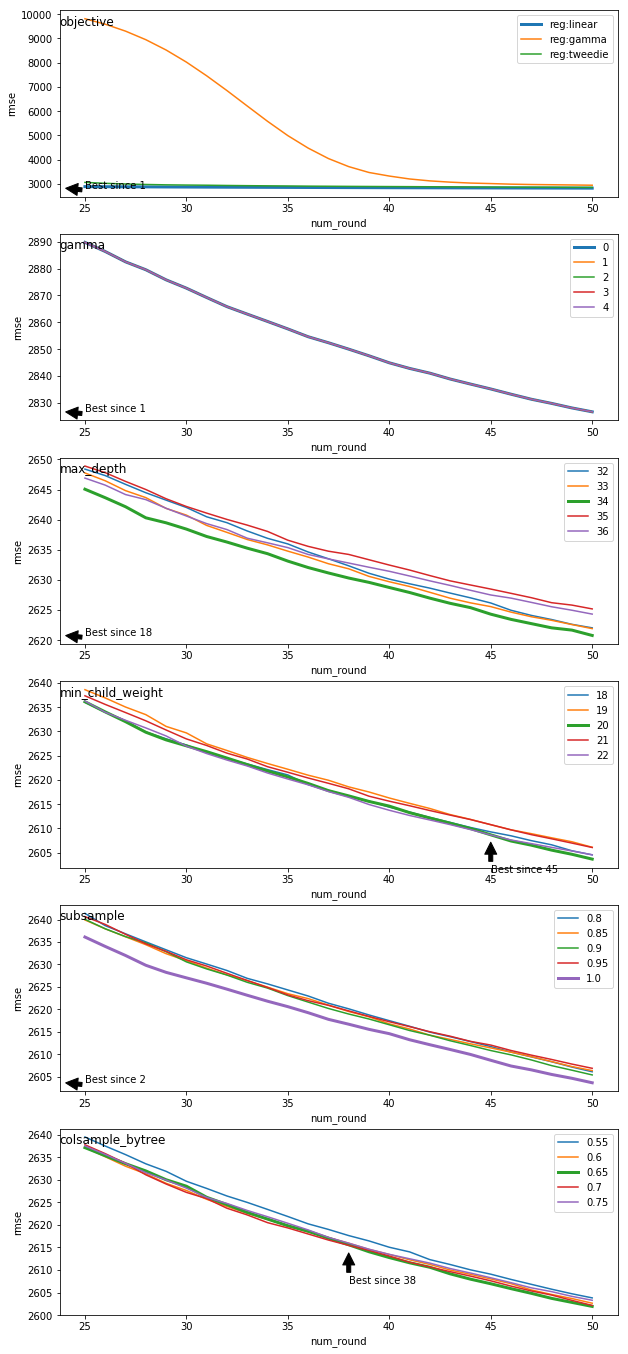

In [23]:
fig, ax = plt.subplots(len(pars)-1, 1, figsize = (10, 4*(len(pars)-1)))
i = 0
startat = 24 # starting position; actual num_round = startat+1
for par in pars[:-1]:
    
    # Retrieving the parameter range
    par_range = tuning_results[par]['par_range'] 
    
    # Retrieving the best value for the parameter
    best_par = tuning_results[par]['best_parameter'] 
    
    # 'first_in_range', 'last_in_range' and 'where_in_range' will be set, then adjusted, so that we can plot the best parameter curve, and the curves around it
    first_in_range = 0 
    last_in_range = len(par_range)-1
    where_in_range = int(np.argwhere(par_range == best_par))
    interval = min(5, len(par_range)) # the number of lines to be plotted will be 5, or all if the parameter has less than 5 values in the range
    if interval == 5:
        if where_in_range < first_in_range + (interval-1)/2:
            last_in_range = 5
        elif (where_in_range >= first_in_range + (interval-1)/2) and (where_in_range <= last_in_range - (interval-1)/2):
            first_in_range = int(where_in_range - (interval-1)/2)
            last_in_range = int(where_in_range + 1 + (interval-1)/2)
            where_in_range = 2
        elif where_in_range > last_in_range - (interval-1)/2:
            last_in_range += 1
            first_in_range = last_in_range - interval
            where_in_range = where_in_range - first_in_range
        par_range = par_range[first_in_range:last_in_range]
        
        # 'cvs' will contain the cross validation results for the parameter values to be plotted
        cvs = tuning_results[par]['cv_results'][first_in_range:last_in_range]
    else:
        cvs = tuning_results[par]['cv_results']

    # 'new_cvs' will extract from 'cvs' only the cv values for the 'test-rmse-mean' column, which corresponds to the validation set mean RMSE
    new_cvs = pd.DataFrame()
    for elem in range(0, len(cvs)):
        new_cv = cvs[elem]['test-rmse-mean']
        new_cvs = pd.concat([new_cvs, new_cv], axis = 1, ignore_index = True)

    # The next code snippet intends to check in each column of 'new_cvs' (which corresponds each to a different parameter value) the position of the lowest RMSE in the last row (last iteration)
    compare = new_cvs.iloc[len(new_cvs)-1, :].reset_index(drop = True)
    sort = list(compare.argsort().argsort())
    which = sort.index(0)

    # The next code snippet will track, from bottom up in 'new_cvs', from which row (which iteration) the corresponding column (parameter value) kept its status as best parameter value
    for row in np.arange(len(new_cvs)-2, -1, -1):
        compare = new_cvs.iloc[row, :].reset_index(drop = True)
        sort = list(compare.argsort().argsort())
        this_which = sort.index(0)
        if this_which != which:
            break
    row += 1
    rmse_row = new_cvs.iloc[row, which]
            
    # Plotting!
    for j in range(0, new_cvs.shape[1]):
        y = new_cvs.iloc[:, j][startat:]
        if j == where_in_range: # Special plotting conditions for best parameter value
            ax[i].plot(y.index+1, y, linewidth = 3)
            annotation = 'Best since '+str(row)
            if row > startat:
                ax[i].annotate(annotation, xy = (row, rmse_row), xytext = (row, rmse_row-(max(y)-min(y))*0.2), arrowprops = dict(facecolor = 'black', shrink = 0.05))
            else:
                ax[i].annotate(annotation, xy = (startat, min(y)), xytext = (startat+1, min(y)), arrowprops = dict(facecolor = 'black', shrink = 0.05))
        else: 
            ax[i].plot(y.index+1, y)
        ax[i].set_title(par, loc = 'left', pad = -15)
        ax[i].set_xlabel('num_round')
        ax[i].set_ylabel('rmse')
        
        ax[i].legend(par_range)
    i += 1

What do we see here? <br> 
Well, first there are some parameters that are adequately tuned very early on. `objective` and `gamma` were best tuned from the first iteration (as a fact the RMSE for the gamma parameter did not change at all); `subsample` from the second. <br> 
Then some needed intermediary iteration steps, like `max_depth` at 18 and `colsample_bytree` at 38. <br>
Finally, `min_child_weight` was only best tuned quite close to the end of the suggested process, at iteration 45. <br>
But then, even for the late tuners, we can observe that any improvement is minimal when comparing to the other parameter values: `min_child_weight` shows that lines corresponding to 18 and 22 pretty much overlap with that of the best value, 20, throughout the plotted data, and `colsample_bytree` shows the same for lines 0.6 and 0.7 around the best value 0.65.

### Conclusion
Choosing the number of iterations is critical in the sense that this parameter directly converts to processing time. In a cross-validation process, the impact is even higher, since the number of iterations run will be multiplied by the number of folds. In the end, for this dataset, I would say two things impact the final decision for the number of iterations: time availabity and precision. If time is not a constraint and/or the highest precision is necessary, then we would be safer choosing a higher number of iterations. Otherwise, cutting the value we first chose by half is a reasonable decision.



Now for my [second aim](#my_aim_here): observe how final RMSE evolves depending on the parameter values tested. Is there any visible pattern there? I chose to scale all y axes in the plots with the same minimum and maximum values, so that we can better inspect visually how each tuning step affects the overall performance of the model.

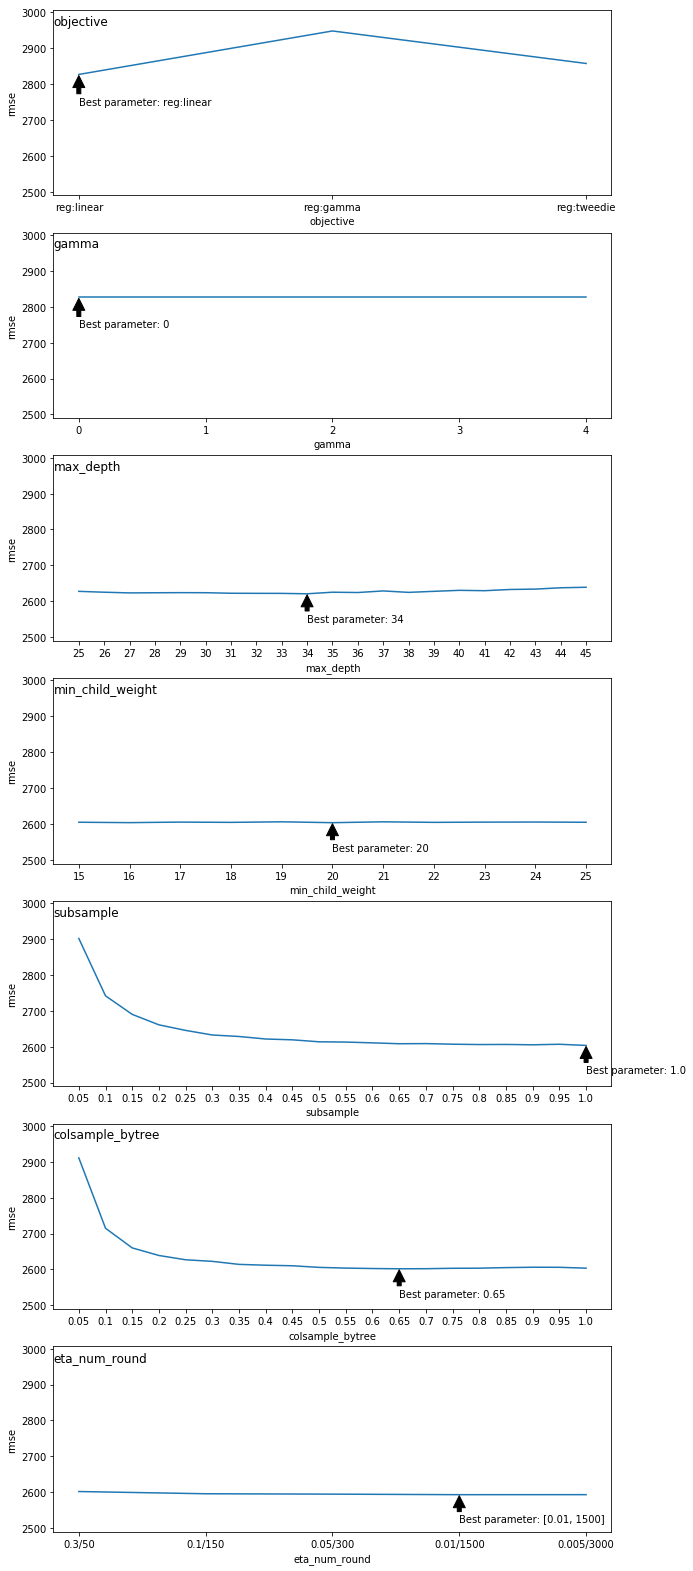

In [24]:
fig, ax = plt.subplots(len(pars), 1, figsize = (10, 4*len(pars)))
i = 0

# 'results' will store the validation set mean RMSE for each parameter value tested
results = pd.DataFrame()
for par in pars:
    if par == 'eta':
        par = 'eta_num_round'
    result = pd.Series(tuning_results[par]['end_results'])
    results = pd.concat([results, result], axis = 1, ignore_index = True)

    # I will use min_results and max_results to scale the y axis
min_results = min(results.min())
max_results = max(results.max())

# Plotting!
for par in pars:
    if par == 'eta':
        par = 'eta_num_round'
    
    # Retrieving the parameter range
    par_range = tuning_results[par]['par_range']
    
    # Retrieving the parameter end results
    results = tuning_results[par]['end_results']
    
    # Where in 'results' is the best result?
    argmin = np.argmin(results)
    
    ax[i].plot(par_range, results)
    ax[i].set_ylim([min_results*0.96, max_results*1.02])
    ax[i].set_title(par, loc = 'left', pad = -15)
    ax[i].set_xticks(par_range)
    ax[i].set_xticklabels(par_range)
    ax[i].set_xlabel(par)
    ax[i].set_ylabel('rmse')
    annotation = 'Best parameter: ' + str(tuning_results[par]['best_parameter'])
    ax[i].annotate(annotation, xy = (par_range[argmin], results[argmin]), xytext = (par_range[argmin], results[argmin]*0.97), arrowprops = dict(facecolor = 'black', shrink = 0.05))
    i += 1

We see that some parameters have a high impact on the performance of the model: `objective`, `subsample` and `colsample_bytree`. But then, I must also notice that I chose very large value ranges for `subsample` and `colsample_bytree`, which is not that common. If I reduced this range to the second half, the variation in performance would also be small. 

### Conclusion
That considered, I could suggest an order in which the parameters of this model, for this dataset, should be tuned. `objective` is the most impactful parameter and should go first. Then, the order does not seem to matter much; if anything, I could place `max_depth` second, and `gamma` second to last. One should remember that ETA/number of iterations should be the last parameter to be tuned, because we will be increasing the number of iterations considerably, so this will be the most time consuming step. If tuned earlier, all subsequent steps will take that same long. Not a wise decision!

### (Serious) limitations
I must emphasize that these conclusions apply, at first, exclusively to the model and the dataset considered. If the final aim is to previously decide on initial parameter values, parameter ranges and order of tuning, this exercise would be quite useless, because such a decision depends on the parameters themselves - first use them, then decide which is best. But my aim was actually (and for the first time in my life as a data scientist) to inspect the relationships described above. I am satisfied with the insights this exercise provided. Any generalization to other models/datasets should only be made after comparing these results with, well, those of other models/datasets. I did not intend to do that here, but maybe someday... In the end, parameter tuning still seems as mystical and time consuming as in the beginning, but the whole Data Science community would be better off if such an attempt would be taken seriously. As a matter of fact, I believe it is already somewhere out there! Time will tell...

### And then...

Well, let us train the proper model with the parameters tuned above! Now I am using the whole train set to train, and that separated validation set to measure its performance.

In [25]:
param = {
    'objective': my_vars['objective'],
    'gamma': my_vars['gamma'],
    'max_depth': my_vars['max_depth'],
    'min_child_weight': my_vars['min_child_weight'],
    'subsample': my_vars['subsample'],
    'colsample_bytree': my_vars['colsample_bytree'],
    'eta': my_vars['eta'],
    'nthread': 3, # might need to adjust according to your computational resources
    'verbosity': 1,
    'eval_metric': 'rmse'
}
num_round = my_vars['num_round']
evallist = [(dtrain, 'eval'), (dval, 'train')]

In [26]:
model = xgb.train(param, dtrain, num_round, evallist)

[23:15:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=34
[0]	eval-rmse:10444.5	train-rmse:10426.3
[23:15:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1172 extra nodes, 0 pruned nodes, max_depth=34
[1]	eval-rmse:10350	train-rmse:10332
[23:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1116 extra nodes, 0 pruned nodes, max_depth=34
[2]	eval-rmse:10254.7	train-rmse:10236.8
[23:15:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1014 extra nodes, 0 pruned nodes, max_depth=34
[3]	eval-rmse:10161.3	train-rmse:10143.6
[23:15:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1098 extra nodes, 0 pruned nodes, max_depth=34
[4]	eval-rmse:10071.3	train-rmse:10053.7
[23:15:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1030 extra nodes, 0 pruned nodes, max_depth=34
[5]	eval-rmse:9979.01	train-rmse:9961.61
[23:15:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[23:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2658 extra nodes, 0 pruned nodes, max_depth=34
[53]	eval-rmse:6587.74	train-rmse:6580.78
[23:16:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2548 extra nodes, 0 pruned nodes, max_depth=34
[54]	eval-rmse:6533.46	train-rmse:6526.77
[23:16:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1842 extra nodes, 0 pruned nodes, max_depth=34
[55]	eval-rmse:6481.57	train-rmse:6475.06
[23:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2424 extra nodes, 0 pruned nodes, max_depth=34
[56]	eval-rmse:6429.22	train-rmse:6422.99
[23:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2516 extra nodes, 0 pruned nodes, max_depth=34
[57]	eval-rmse:6377.29	train-rmse:6371.36
[23:16:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2152 extra nodes, 0 pruned nodes, max_depth=34
[58]	eval-rmse:6325.73	train-rmse:6320.08
[23:16:20] src/tree/updater_prune.cc:74: tree pruning end,

[23:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3622 extra nodes, 0 pruned nodes, max_depth=34
[106]	eval-rmse:4481.87	train-rmse:4492.32
[23:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3218 extra nodes, 0 pruned nodes, max_depth=34
[107]	eval-rmse:4453.7	train-rmse:4464.57
[23:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4138 extra nodes, 0 pruned nodes, max_depth=34
[108]	eval-rmse:4425.98	train-rmse:4437.28
[23:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4502 extra nodes, 0 pruned nodes, max_depth=34
[109]	eval-rmse:4398.47	train-rmse:4410.27
[23:17:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2882 extra nodes, 0 pruned nodes, max_depth=34
[110]	eval-rmse:4372.45	train-rmse:4384.63
[23:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2668 extra nodes, 0 pruned nodes, max_depth=34
[111]	eval-rmse:4345.54	train-rmse:4358.07
[23:17:24] src/tree/updater_prune.cc:74: tree pruning

[23:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2676 extra nodes, 0 pruned nodes, max_depth=34
[158]	eval-rmse:3437.6	train-rmse:3470
[23:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5010 extra nodes, 0 pruned nodes, max_depth=34
[159]	eval-rmse:3424.02	train-rmse:3456.98
[23:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4350 extra nodes, 0 pruned nodes, max_depth=34
[160]	eval-rmse:3410.38	train-rmse:3443.87
[23:18:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5970 extra nodes, 0 pruned nodes, max_depth=34
[161]	eval-rmse:3397.36	train-rmse:3431.46
[23:18:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5550 extra nodes, 0 pruned nodes, max_depth=34
[162]	eval-rmse:3384.5	train-rmse:3419.13
[23:18:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4428 extra nodes, 0 pruned nodes, max_depth=34
[163]	eval-rmse:3372	train-rmse:3407.15
[23:18:28] src/tree/updater_prune.cc:74: tree pruning end, 1

[23:19:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4112 extra nodes, 0 pruned nodes, max_depth=34
[210]	eval-rmse:2948.46	train-rmse:3003.85
[23:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4284 extra nodes, 0 pruned nodes, max_depth=34
[211]	eval-rmse:2942.18	train-rmse:2997.98
[23:19:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4118 extra nodes, 0 pruned nodes, max_depth=34
[212]	eval-rmse:2936.24	train-rmse:2992.44
[23:19:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3548 extra nodes, 0 pruned nodes, max_depth=34
[213]	eval-rmse:2930.83	train-rmse:2987.46
[23:19:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3956 extra nodes, 0 pruned nodes, max_depth=34
[214]	eval-rmse:2925.24	train-rmse:2982.19
[23:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3382 extra nodes, 0 pruned nodes, max_depth=34
[215]	eval-rmse:2919.49	train-rmse:2976.8
[23:19:31] src/tree/updater_prune.cc:74: tree pruning

[23:20:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5010 extra nodes, 0 pruned nodes, max_depth=34
[262]	eval-rmse:2733.42	train-rmse:2807.65
[23:20:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3608 extra nodes, 0 pruned nodes, max_depth=34
[263]	eval-rmse:2730.8	train-rmse:2805.28
[23:20:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2866 extra nodes, 0 pruned nodes, max_depth=34
[264]	eval-rmse:2728.33	train-rmse:2803.02
[23:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5156 extra nodes, 0 pruned nodes, max_depth=34
[265]	eval-rmse:2725.83	train-rmse:2800.95
[23:20:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4680 extra nodes, 0 pruned nodes, max_depth=34
[266]	eval-rmse:2723.16	train-rmse:2798.61
[23:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4754 extra nodes, 0 pruned nodes, max_depth=34
[267]	eval-rmse:2720.62	train-rmse:2796.4
[23:20:33] src/tree/updater_prune.cc:74: tree pruning 

[23:21:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3934 extra nodes, 0 pruned nodes, max_depth=34
[314]	eval-rmse:2635.73	train-rmse:2723.98
[23:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3466 extra nodes, 0 pruned nodes, max_depth=34
[315]	eval-rmse:2634.37	train-rmse:2722.91
[23:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5750 extra nodes, 0 pruned nodes, max_depth=34
[316]	eval-rmse:2632.99	train-rmse:2721.91
[23:21:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2814 extra nodes, 0 pruned nodes, max_depth=34
[317]	eval-rmse:2631.79	train-rmse:2720.85
[23:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1716 extra nodes, 0 pruned nodes, max_depth=34
[318]	eval-rmse:2630.76	train-rmse:2719.91
[23:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4072 extra nodes, 0 pruned nodes, max_depth=34
[319]	eval-rmse:2629.61	train-rmse:2718.98
[23:21:36] src/tree/updater_prune.cc:74: tree prunin

[23:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3612 extra nodes, 0 pruned nodes, max_depth=34
[366]	eval-rmse:2588.29	train-rmse:2686.6
[23:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2842 extra nodes, 0 pruned nodes, max_depth=34
[367]	eval-rmse:2587.61	train-rmse:2686.15
[23:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1620 extra nodes, 0 pruned nodes, max_depth=34
[368]	eval-rmse:2587.07	train-rmse:2685.67
[23:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3934 extra nodes, 0 pruned nodes, max_depth=34
[369]	eval-rmse:2586.36	train-rmse:2685.19
[23:22:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2102 extra nodes, 0 pruned nodes, max_depth=34
[370]	eval-rmse:2585.82	train-rmse:2684.72
[23:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4520 extra nodes, 0 pruned nodes, max_depth=34
[371]	eval-rmse:2585.04	train-rmse:2684.27
[23:22:41] src/tree/updater_prune.cc:74: tree pruning

[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2066 extra nodes, 0 pruned nodes, max_depth=34
[418]	eval-rmse:2563.07	train-rmse:2667.51
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1626 extra nodes, 0 pruned nodes, max_depth=34
[419]	eval-rmse:2562.73	train-rmse:2667.23
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3606 extra nodes, 0 pruned nodes, max_depth=34
[420]	eval-rmse:2562.3	train-rmse:2666.94
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4022 extra nodes, 0 pruned nodes, max_depth=34
[421]	eval-rmse:2561.8	train-rmse:2666.67
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 0 pruned nodes, max_depth=34
[422]	eval-rmse:2561.51	train-rmse:2666.44
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3032 extra nodes, 0 pruned nodes, max_depth=34
[423]	eval-rmse:2561.04	train-rmse:2666.15
[23:23:37] src/tree/updater_prune.cc:74: tree pruning e

[23:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=34
[471]	eval-rmse:2546.42	train-rmse:2655.56
[23:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2948 extra nodes, 0 pruned nodes, max_depth=34
[472]	eval-rmse:2545.95	train-rmse:2655.31
[23:24:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=34
[473]	eval-rmse:2545.78	train-rmse:2655.15
[23:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1634 extra nodes, 0 pruned nodes, max_depth=34
[474]	eval-rmse:2545.52	train-rmse:2654.97
[23:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=34
[475]	eval-rmse:2545.35	train-rmse:2654.82
[23:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=34
[476]	eval-rmse:2545.11	train-rmse:2654.64
[23:24:34] src/tree/updater_prune.cc:74: tree pruning en

[23:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=34
[524]	eval-rmse:2535.23	train-rmse:2647.2
[23:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1062 extra nodes, 0 pruned nodes, max_depth=34
[525]	eval-rmse:2535.02	train-rmse:2647.05
[23:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1116 extra nodes, 0 pruned nodes, max_depth=34
[526]	eval-rmse:2534.81	train-rmse:2646.93
[23:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=34
[527]	eval-rmse:2534.66	train-rmse:2646.79
[23:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=34
[528]	eval-rmse:2534.47	train-rmse:2646.64
[23:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=34
[529]	eval-rmse:2534.31	train-rmse:2646.5
[23:25:35] src/tree/updater_prune.cc:74: tree pruning end,

[23:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=34
[577]	eval-rmse:2527.33	train-rmse:2640.62
[23:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=34
[578]	eval-rmse:2527.23	train-rmse:2640.53
[23:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[579]	eval-rmse:2527.13	train-rmse:2640.45
[23:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[580]	eval-rmse:2527.03	train-rmse:2640.36
[23:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=34
[581]	eval-rmse:2526.93	train-rmse:2640.28
[23:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=34
[582]	eval-rmse:2526.83	train-rmse:2640.19
[23:27:01] src/tree/updater_prune.cc:74: tree pruning end,

[23:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=34
[630]	eval-rmse:2521.95	train-rmse:2635.96
[23:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 716 extra nodes, 0 pruned nodes, max_depth=34
[631]	eval-rmse:2521.82	train-rmse:2635.87
[23:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[632]	eval-rmse:2521.73	train-rmse:2635.81
[23:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[633]	eval-rmse:2521.65	train-rmse:2635.73
[23:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=34
[634]	eval-rmse:2521.57	train-rmse:2635.66
[23:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[635]	eval-rmse:2521.49	train-rmse:2635.59
[23:28:32] src/tree/updater_prune.cc:74: tree pruning end,

[23:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=34
[683]	eval-rmse:2517	train-rmse:2631.84
[23:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=34
[684]	eval-rmse:2516.92	train-rmse:2631.76
[23:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[685]	eval-rmse:2516.83	train-rmse:2631.69
[23:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=34
[686]	eval-rmse:2516.75	train-rmse:2631.62
[23:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=34
[687]	eval-rmse:2516.65	train-rmse:2631.53
[23:29:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=34
[688]	eval-rmse:2516.55	train-rmse:2631.46
[23:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 

[23:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=34
[736]	eval-rmse:2512.39	train-rmse:2628.13
[23:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=34
[737]	eval-rmse:2512.27	train-rmse:2628.04
[23:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=34
[738]	eval-rmse:2512.18	train-rmse:2627.95
[23:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=34
[739]	eval-rmse:2512.05	train-rmse:2627.88
[23:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[740]	eval-rmse:2511.98	train-rmse:2627.82
[23:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=34
[741]	eval-rmse:2511.87	train-rmse:2627.73
[23:31:10] src/tree/updater_prune.cc:74: tree pruning end,

[23:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=34
[789]	eval-rmse:2507.92	train-rmse:2624.64
[23:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=34
[790]	eval-rmse:2507.8	train-rmse:2624.54
[23:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=34
[791]	eval-rmse:2507.72	train-rmse:2624.48
[23:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=34
[792]	eval-rmse:2507.65	train-rmse:2624.43
[23:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=34
[793]	eval-rmse:2507.57	train-rmse:2624.36
[23:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=34
[794]	eval-rmse:2507.49	train-rmse:2624.3
[23:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1

[23:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[842]	eval-rmse:2503.73	train-rmse:2621.33
[23:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=34
[843]	eval-rmse:2503.66	train-rmse:2621.28
[23:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[844]	eval-rmse:2503.59	train-rmse:2621.22
[23:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, max_depth=34
[845]	eval-rmse:2503.48	train-rmse:2621.15
[23:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=34
[846]	eval-rmse:2503.33	train-rmse:2621.04
[23:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=34
[847]	eval-rmse:2503.23	train-rmse:2620.95
[23:33:24] src/tree/updater_prune.cc:74: tree pruning end,

[23:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=34
[895]	eval-rmse:2499.65	train-rmse:2618.15
[23:34:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=34
[896]	eval-rmse:2499.57	train-rmse:2618.08
[23:34:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[897]	eval-rmse:2499.5	train-rmse:2618.04
[23:34:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 0 pruned nodes, max_depth=34
[898]	eval-rmse:2499.36	train-rmse:2617.94
[23:34:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=34
[899]	eval-rmse:2499.3	train-rmse:2617.89
[23:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=34
[900]	eval-rmse:2499.2	train-rmse:2617.81
[23:34:31] src/tree/updater_prune.cc:74: tree pruning end, 1 

[23:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=34
[948]	eval-rmse:2495.64	train-rmse:2615.16
[23:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[949]	eval-rmse:2495.58	train-rmse:2615.12
[23:35:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=34
[950]	eval-rmse:2495.47	train-rmse:2615.04
[23:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=34
[951]	eval-rmse:2495.41	train-rmse:2614.98
[23:35:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=34
[952]	eval-rmse:2495.34	train-rmse:2614.94
[23:35:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=34
[953]	eval-rmse:2495.27	train-rmse:2614.89
[23:35:47] src/tree/updater_prune.cc:74: tree pruning end,

[23:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[1001]	eval-rmse:2491.79	train-rmse:2612.36
[23:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=34
[1002]	eval-rmse:2491.72	train-rmse:2612.3
[23:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=34
[1003]	eval-rmse:2491.66	train-rmse:2612.26
[23:36:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=34
[1004]	eval-rmse:2491.6	train-rmse:2612.21
[23:36:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=34
[1005]	eval-rmse:2491.49	train-rmse:2612.15
[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[1006]	eval-rmse:2491.43	train-rmse:2612.11
[23:37:00] src/tree/updater_prune.cc:74: tree pruning 

[23:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=34
[1053]	eval-rmse:2488.3	train-rmse:2609.8
[23:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=34
[1054]	eval-rmse:2488.21	train-rmse:2609.75
[23:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=34
[1055]	eval-rmse:2488.15	train-rmse:2609.7
[23:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=34
[1056]	eval-rmse:2488.08	train-rmse:2609.66
[23:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=34
[1057]	eval-rmse:2487.97	train-rmse:2609.61
[23:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=34
[1058]	eval-rmse:2487.92	train-rmse:2609.57
[23:38:11] src/tree/updater_prune.cc:74: tree pruning e

[23:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1105]	eval-rmse:2484.86	train-rmse:2607.29
[23:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=34
[1106]	eval-rmse:2484.8	train-rmse:2607.25
[23:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=34
[1107]	eval-rmse:2484.74	train-rmse:2607.2
[23:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=34
[1108]	eval-rmse:2484.65	train-rmse:2607.14
[23:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=34
[1109]	eval-rmse:2484.59	train-rmse:2607.1
[23:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=34
[1110]	eval-rmse:2484.53	train-rmse:2607.07
[23:39:18] src/tree/updater_prune.cc:74: tree pruning e

[23:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=34
[1157]	eval-rmse:2481.44	train-rmse:2604.86
[23:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=34
[1158]	eval-rmse:2481.38	train-rmse:2604.82
[23:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=34
[1159]	eval-rmse:2481.32	train-rmse:2604.79
[23:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=34
[1160]	eval-rmse:2481.26	train-rmse:2604.75
[23:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=34
[1161]	eval-rmse:2481.16	train-rmse:2604.69
[23:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=34
[1162]	eval-rmse:2481.1	train-rmse:2604.65
[23:40:31] src/tree/updater_prune.cc:74: tree pruning

[23:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=34
[1209]	eval-rmse:2478.26	train-rmse:2602.6
[23:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=34
[1210]	eval-rmse:2478.2	train-rmse:2602.56
[23:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=34
[1211]	eval-rmse:2478.15	train-rmse:2602.52
[23:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=34
[1212]	eval-rmse:2478.11	train-rmse:2602.48
[23:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=34
[1213]	eval-rmse:2478.05	train-rmse:2602.43
[23:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=34
[1214]	eval-rmse:2478	train-rmse:2602.39
[23:41:40] src/tree/updater_prune.cc:74: tree pruning end

[23:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=34
[1261]	eval-rmse:2475.23	train-rmse:2600.45
[23:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=34
[1262]	eval-rmse:2475.19	train-rmse:2600.42
[23:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=34
[1263]	eval-rmse:2475.14	train-rmse:2600.38
[23:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=34
[1264]	eval-rmse:2475.09	train-rmse:2600.34
[23:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=34
[1265]	eval-rmse:2475.03	train-rmse:2600.31
[23:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=34
[1266]	eval-rmse:2474.98	train-rmse:2600.27
[23:42:48] src/tree/updater_prune.cc:74: tree prunin

[23:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=34
[1313]	eval-rmse:2472.31	train-rmse:2598.41
[23:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=34
[1314]	eval-rmse:2472.23	train-rmse:2598.36
[23:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=34
[1315]	eval-rmse:2472.18	train-rmse:2598.32
[23:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=34
[1316]	eval-rmse:2472.12	train-rmse:2598.27
[23:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 680 extra nodes, 0 pruned nodes, max_depth=34
[1317]	eval-rmse:2472.02	train-rmse:2598.2
[23:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=34
[1318]	eval-rmse:2471.96	train-rmse:2598.17
[23:43:54] src/tree/updater_prune.cc:74: tree pruning

[23:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=34
[1365]	eval-rmse:2469.44	train-rmse:2596.37
[23:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=34
[1366]	eval-rmse:2469.35	train-rmse:2596.31
[23:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=34
[1367]	eval-rmse:2469.31	train-rmse:2596.27
[23:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=34
[1368]	eval-rmse:2469.27	train-rmse:2596.23
[23:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=34
[1369]	eval-rmse:2469.2	train-rmse:2596.2
[23:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=34
[1370]	eval-rmse:2469.15	train-rmse:2596.17
[23:45:05] src/tree/updater_prune.cc:74: tree pruning 

[23:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=34
[1417]	eval-rmse:2466.81	train-rmse:2594.55
[23:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=34
[1418]	eval-rmse:2466.7	train-rmse:2594.47
[23:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=34
[1419]	eval-rmse:2466.66	train-rmse:2594.44
[23:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=34
[1420]	eval-rmse:2466.59	train-rmse:2594.4
[23:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=34
[1421]	eval-rmse:2466.54	train-rmse:2594.37
[23:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=34
[1422]	eval-rmse:2466.5	train-rmse:2594.34
[23:46:08] src/tree/updater_prune.cc:74: tree pruning e

[23:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=34
[1469]	eval-rmse:2464.19	train-rmse:2592.66
[23:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1470]	eval-rmse:2464.15	train-rmse:2592.63
[23:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=34
[1471]	eval-rmse:2464.1	train-rmse:2592.6
[23:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=34
[1472]	eval-rmse:2464.05	train-rmse:2592.55
[23:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=34
[1473]	eval-rmse:2464.01	train-rmse:2592.52
[23:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=34
[1474]	eval-rmse:2463.97	train-rmse:2592.49
[23:47:23] src/tree/updater_prune.cc:74: tree pruning 

And then, let us predict the Purchase Amount for the validation set.

In [27]:
y_pred = model.predict(dval)

Finally, since this is my first regression model ever, I want to have some visual inspection of what I did. I am choosing to plot the actual results from the validation set against the predicted results. Since there are way too many datapoints (and such a plot would be illegible), I am plotting only at every 500 points. And voilà!

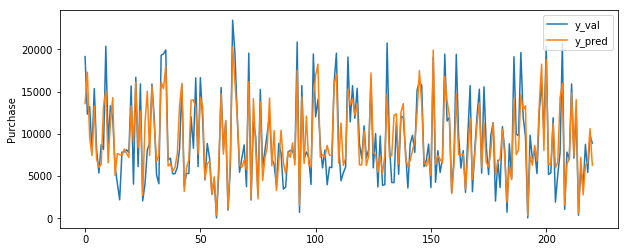

In [28]:
plot_every = 500
fig = plt.figure(figsize = (10, 4))

plt.plot(y_val[::plot_every])
plt.plot(y_pred[::plot_every])
plt.ylabel('Purchase')
plt.legend(['y_val', 'y_pred'], loc = 'upper right')

There it is! Obviously both curves are not coincidental (if they were, my model would be perfect), but we can observe a general tendency towards coincidence. The difference between the curves is what is actually measured by RMSE. Looks interesting to me!

I do not intend to predict for the test set itself, as it would be useless here. Such results were only expected if they were to be submitted to the hackaton.

And that is that! [Arh-wooooooooo!](https://www.urbandictionary.com/define.php?term=Howl)